In [1]:
%pip install git+https://github.com/metadriverse/metadrive.git
!pip install stable-baselines3  # For PPO experiments
!pip install gym  # Ensure gym is installed


  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-tp765pei
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-tp765pei
  Resolved https://github.com/metadriverse/metadrive.git to commit b908149e422f2e7715207ca1eb81380342de5681
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.7 MB/s eta 0:00:00
  Created wheel for metadrive-simulator: filename=metadrive_simulator-0.4.3-py3-none-any.whl size=55022091 sha256=69faf

In [3]:
!apt-get install -y xvfb python-opengl ffmpeg

!pip install pyvirtualdisplay

!sudo apt-get update
!sudo apt-get install -y xvfb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,364 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,550 kB]
Get:12

In [4]:
import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


In [5]:
class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True


In [6]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": "C", "traffic_density": 0.1, "random_lane_width": False, "use_render": render,
                            #  "out_of_road_penalty": 30.0,  # Increased penalty
                #  "out_of_road_cost":


                 },
        "medium": {"map": "C", "traffic_density": 0.3, "random_lane_width": True, "use_render": render,
                              #  "out_of_road_penalty": 30.0,  # Increased penalty

                   },
        "hard": {"map": "C", "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

In [7]:
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=4096) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger

In [8]:
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models

In [10]:
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models

In [11]:
# Run the curriculum experiments
difficulty_order = ["easy", ]#"medium"#, "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


Training on easy difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[WARNING] Assets folder doesn't exist. Begin to download assets... (base_engine.py:773)
[INFO] Pull assets from https://github.com/metadriverse/metadrive/releases/download/MetaDrive-0.4.3/assets.zip to /usr/local/lib/python3.10/dist-packages/metadrive/assets.zip

[INFO] Extracting assets.
[INFO] Successfully download assets, version: 0.4.3. MetaDrive version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario In

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.46e+03 |
|    ep_rew_mean     | 12.8     |
| time/              |          |
|    fps             | 236      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.42e+03    |
|    ep_rew_mean          | 30.9        |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 2           |
|    time_elapsed         | 33          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011227528 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.00927     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0262      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00939    |
|    std                  | 0.997       |
|    value_loss           | 0.14        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.26e+03   |
|    ep_rew_mean          | 16.8       |
| time/                   |            |
|    fps                  | 250        |
|    iterations           | 3          |
|    time_elapsed         | 49         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.02016594 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.79      |
|    explained_variance   | 0.0166     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0187     |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.0205    |
|    std                  | 0.964      |
|    value_loss           | 0.104      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.24e+03   |
|    ep_rew_mean          | 23.4       |
| time/                   |            |
|    fps                  | 250        |
|    iterations           | 4          |
|    time_elapsed         | 65         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01315197 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.75      |
|    explained_variance   | 0.0114     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.51       |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.00796   |
|    std                  | 0.953      |
|    value_loss           | 0.417      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 925         |
|    ep_rew_mean          | 20.8        |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 5           |
|    time_elapsed         | 82          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.010665817 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.0263      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.158       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0081     |
|    std                  | 0.935       |
|    value_loss           | 0.438       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 696         |
|    ep_rew_mean          | 18.4        |
| time/                   |             |
|    fps                  | 241         |
|    iterations           | 6           |
|    time_elapsed         | 101         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.012082677 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | -0.029      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.484       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00844    |
|    std                  | 0.918       |
|    value_loss           | 0.822       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 530         |
|    ep_rew_mean          | 16.1        |
| time/                   |             |
|    fps                  | 235         |
|    iterations           | 7           |
|    time_elapsed         | 121         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.006769455 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.592       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00457    |
|    std                  | 0.903       |
|    value_loss           | 1.15        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 420         |
|    ep_rew_mean          | 14.4        |
| time/                   |             |
|    fps                  | 229         |
|    iterations           | 8           |
|    time_elapsed         | 143         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.006185588 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.423       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.87        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00108    |
|    std                  | 0.895       |
|    value_loss           | 1.22        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 385        |
|    ep_rew_mean          | 14.8       |
| time/                   |            |
|    fps                  | 226        |
|    iterations           | 9          |
|    time_elapsed         | 163        |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 0.00496412 |
|    clip_fraction        | 0.0417     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.6       |
|    explained_variance   | 0.705      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.338      |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.00176   |
|    std                  | 0.887      |
|    value_loss           | 0.966      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 210         |
|    ep_rew_mean          | 13.8        |
| time/                   |             |
|    fps                  | 222         |
|    iterations           | 10          |
|    time_elapsed         | 184         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010932336 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.664       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.47        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00652    |
|    std                  | 0.871       |
|    value_loss           | 1.62        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 14.8        |
| time/                   |             |
|    fps                  | 218         |
|    iterations           | 11          |
|    time_elapsed         | 206         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.010271252 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.83        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00703    |
|    std                  | 0.86        |
|    value_loss           | 2.81        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | 17.7        |
| time/                   |             |
|    fps                  | 215         |
|    iterations           | 12          |
|    time_elapsed         | 227         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.008994307 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.696       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.41        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00997    |
|    std                  | 0.845       |
|    value_loss           | 3.25        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 20.6        |
| time/                   |             |
|    fps                  | 214         |
|    iterations           | 13          |
|    time_elapsed         | 248         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.010355028 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.87        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00819    |
|    std                  | 0.834       |
|    value_loss           | 4.25        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 156         |
|    ep_rew_mean          | 22.4        |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 14          |
|    time_elapsed         | 270         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013376885 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.449       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.14        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00187    |
|    std                  | 0.823       |
|    value_loss           | 4.42        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 27.2        |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 15          |
|    time_elapsed         | 290         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.009530142 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.44       |
|    explained_variance   | 0.398       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.39        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00756    |
|    std                  | 0.82        |
|    value_loss           | 7.31        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 195         |
|    ep_rew_mean          | 36.5        |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 16          |
|    time_elapsed         | 310         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.014853429 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.551       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.04        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00461    |
|    std                  | 0.805       |
|    value_loss           | 6.28        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 49.1     |
|    ep_rew_mean          | 4.75     |
| time/                   |          |
|    fps                  | 208      |
|    iterations           | 17       |
|    time_elapsed         | 333      |
|    total_timesteps      | 69632    |
| train/                  |          |
|    approx_kl            | 0.030416 |
|    clip_fraction        | 0.161    |
|    clip_range           | 0.2      |
|    entropy_loss         | -2.39    |
|    explained_variance   | 0.171    |
|    learning_rate        | 0.0003   |
|    loss                 | 3.7      |
|    n_updates            | 160      |
|    policy_gradient_loss | -0.00118 |
|    std                  | 0.797    |
|    value_loss           | 8.89     |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60.2        |
|    ep_rew_mean          | 6.93        |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 18          |
|    time_elapsed         | 356         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.023112906 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.37       |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.31        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0149     |
|    std                  | 0.795       |
|    value_loss           | 14          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92.4        |
|    ep_rew_mean          | 16.7        |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 19          |
|    time_elapsed         | 378         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.019215224 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.554       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.29        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0214     |
|    std                  | 0.785       |
|    value_loss           | 11.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 127         |
|    ep_rew_mean          | 27.5        |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 20          |
|    time_elapsed         | 398         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.018089293 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.32       |
|    explained_variance   | 0.497       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.58        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0119     |
|    std                  | 0.765       |
|    value_loss           | 9.58        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 149          |
|    ep_rew_mean          | 35.3         |
| time/                   |              |
|    fps                  | 204          |
|    iterations           | 21           |
|    time_elapsed         | 420          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0077192043 |
|    clip_fraction        | 0.147        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.28        |
|    explained_variance   | 0.392        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.89         |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00356     |
|    std                  | 0.751        |
|    value_loss           | 10.4         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 46.7        |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 22          |
|    time_elapsed         | 440         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.031026717 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.213       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.31        |
|    n_updates            | 210         |
|    policy_gradient_loss | 0.00268     |
|    std                  | 0.74        |
|    value_loss           | 17.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 206        |
|    ep_rew_mean          | 60.2       |
| time/                   |            |
|    fps                  | 204        |
|    iterations           | 23         |
|    time_elapsed         | 460        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.02170567 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.21      |
|    explained_variance   | 0.31       |
|    learning_rate        | 0.0003     |
|    loss                 | 5.11       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.00109   |
|    std                  | 0.721      |
|    value_loss           | 14.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 226        |
|    ep_rew_mean          | 73.5       |
| time/                   |            |
|    fps                  | 205        |
|    iterations           | 24         |
|    time_elapsed         | 479        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.02283559 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.15      |
|    explained_variance   | 0.223      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.97       |
|    n_updates            | 230        |
|    policy_gradient_loss | 0.00494    |
|    std                  | 0.703      |
|    value_loss           | 15.4       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 237         |
|    ep_rew_mean          | 85.5        |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 25          |
|    time_elapsed         | 499         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.025650647 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.98        |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.00488     |
|    std                  | 0.683       |
|    value_loss           | 18.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 231         |
|    ep_rew_mean          | 90.4        |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 26          |
|    time_elapsed         | 521         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.045358192 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.24        |
|    n_updates            | 250         |
|    policy_gradient_loss | 0.00385     |
|    std                  | 0.668       |
|    value_loss           | 24.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 245         |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 27          |
|    time_elapsed         | 542         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.010664461 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.02       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.5        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00319    |
|    std                  | 0.661       |
|    value_loss           | 43.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 242         |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 28          |
|    time_elapsed         | 563         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.010024884 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.19        |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 270         |
|    policy_gradient_loss | 0.00775     |
|    std                  | 0.653       |
|    value_loss           | 40.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 214         |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 29          |
|    time_elapsed         | 584         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.011675148 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 0.333       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.2        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00191    |
|    std                  | 0.645       |
|    value_loss           | 44.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 212         |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 30          |
|    time_elapsed         | 605         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.009309447 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.3        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.00377     |
|    std                  | 0.646       |
|    value_loss           | 50.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 227         |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 31          |
|    time_elapsed         | 625         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.025225578 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.426       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.00223     |
|    std                  | 0.64        |
|    value_loss           | 41.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 238         |
|    ep_rew_mean          | 136         |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 32          |
|    time_elapsed         | 645         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.014075409 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.0003      |
|    loss                 | 24          |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.00916     |
|    std                  | 0.633       |
|    value_loss           | 42.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 226        |
|    ep_rew_mean          | 134        |
| time/                   |            |
|    fps                  | 202        |
|    iterations           | 33         |
|    time_elapsed         | 667        |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.02707006 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.91      |
|    explained_variance   | 0.361      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.1       |
|    n_updates            | 320        |
|    policy_gradient_loss | 0.0148     |
|    std                  | 0.625      |
|    value_loss           | 46         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 198        |
|    ep_rew_mean          | 116        |
| time/                   |            |
|    fps                  | 201        |
|    iterations           | 34         |
|    time_elapsed         | 691        |
|    total_timesteps      | 139264     |
| train/                  |            |
|    approx_kl            | 0.28398675 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.9       |
|    explained_variance   | 0.242      |
|    learning_rate        | 0.0003     |
|    loss                 | 43.2       |
|    n_updates            | 330        |
|    policy_gradient_loss | 0.0175     |
|    std                  | 0.626      |
|    value_loss           | 72.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 77.3        |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 35          |
|    time_elapsed         | 715         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.018785402 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.284       |
|    learning_rate        | 0.0003      |
|    loss                 | 74.2        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00846    |
|    std                  | 0.619       |
|    value_loss           | 107         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 132        |
|    ep_rew_mean          | 69.6       |
| time/                   |            |
|    fps                  | 199        |
|    iterations           | 36         |
|    time_elapsed         | 738        |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.04194767 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.87      |
|    explained_variance   | 0.307      |
|    learning_rate        | 0.0003     |
|    loss                 | 48.2       |
|    n_updates            | 350        |
|    policy_gradient_loss | -0.00656   |
|    std                  | 0.615      |
|    value_loss           | 103        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 85.9        |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 37          |
|    time_elapsed         | 759         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.008247605 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.5        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.00114    |
|    std                  | 0.604       |
|    value_loss           | 80.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 167          |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 199          |
|    iterations           | 38           |
|    time_elapsed         | 780          |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0076285764 |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.81        |
|    explained_variance   | 0.295        |
|    learning_rate        | 0.0003       |
|    loss                 | 40           |
|    n_updates            | 370          |
|    policy_gradient_loss | 0.00556      |
|    std                  | 0.594        |
|    value_loss           | 65.3         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 182         |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 39          |
|    time_elapsed         | 802         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.013158032 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.87        |
|    n_updates            | 380         |
|    policy_gradient_loss | 0.00627     |
|    std                  | 0.579       |
|    value_loss           | 53.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 197        |
|    ep_rew_mean          | 144        |
| time/                   |            |
|    fps                  | 198        |
|    iterations           | 40         |
|    time_elapsed         | 824        |
|    total_timesteps      | 163840     |
| train/                  |            |
|    approx_kl            | 0.06499444 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.71      |
|    explained_variance   | 0.282      |
|    learning_rate        | 0.0003     |
|    loss                 | 54.3       |
|    n_updates            | 390        |
|    policy_gradient_loss | 0.0167     |
|    std                  | 0.567      |
|    value_loss           | 88.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 207         |
|    ep_rew_mean          | 159         |
| time/                   |             |
|    fps                  | 198         |
|    iterations           | 41          |
|    time_elapsed         | 845         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.026266469 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.341       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.6        |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.0103      |
|    std                  | 0.559       |
|    value_loss           | 74.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 202         |
|    ep_rew_mean          | 159         |
| time/                   |             |
|    fps                  | 198         |
|    iterations           | 42          |
|    time_elapsed         | 867         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.014528494 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.6        |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.0116      |
|    std                  | 0.554       |
|    value_loss           | 76.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 199         |
|    ep_rew_mean          | 158         |
| time/                   |             |
|    fps                  | 198         |
|    iterations           | 43          |
|    time_elapsed         | 889         |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.021524008 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.5        |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.007       |
|    std                  | 0.549       |
|    value_loss           | 105         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 198        |
|    ep_rew_mean          | 159        |
| time/                   |            |
|    fps                  | 197        |
|    iterations           | 44         |
|    time_elapsed         | 911        |
|    total_timesteps      | 180224     |
| train/                  |            |
|    approx_kl            | 0.10143597 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.61      |
|    explained_variance   | 0.426      |
|    learning_rate        | 0.0003     |
|    loss                 | 35.4       |
|    n_updates            | 430        |
|    policy_gradient_loss | 0.0299     |
|    std                  | 0.541      |
|    value_loss           | 91.4       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 197         |
|    ep_rew_mean          | 162         |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 45          |
|    time_elapsed         | 932         |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.045757376 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.443       |
|    learning_rate        | 0.0003      |
|    loss                 | 39.8        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00864     |
|    std                  | 0.535       |
|    value_loss           | 100         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 197         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 46          |
|    time_elapsed         | 954         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.017494425 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.51        |
|    learning_rate        | 0.0003      |
|    loss                 | 49.8        |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.00173     |
|    std                  | 0.524       |
|    value_loss           | 103         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 47          |
|    time_elapsed         | 976         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.018998496 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.1        |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.00544     |
|    std                  | 0.522       |
|    value_loss           | 78.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 180        |
|    ep_rew_mean          | 153        |
| time/                   |            |
|    fps                  | 196        |
|    iterations           | 48         |
|    time_elapsed         | 999        |
|    total_timesteps      | 196608     |
| train/                  |            |
|    approx_kl            | 0.03463742 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.5       |
|    explained_variance   | 0.602      |
|    learning_rate        | 0.0003     |
|    loss                 | 24.5       |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.000442  |
|    std                  | 0.513      |
|    value_loss           | 88.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 136         |
| time/                   |             |
|    fps                  | 196         |
|    iterations           | 49          |
|    time_elapsed         | 1023        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.011100523 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 69.2        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0017     |
|    std                  | 0.51        |
|    value_loss           | 160         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 50          |
|    time_elapsed         | 1046        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.012256252 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.41        |
|    learning_rate        | 0.0003      |
|    loss                 | 89.3        |
|    n_updates            | 490         |
|    policy_gradient_loss | 0.00428     |
|    std                  | 0.503       |
|    value_loss           | 152         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 145         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 51          |
|    time_elapsed         | 1068        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.027319822 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.425       |
|    learning_rate        | 0.0003      |
|    loss                 | 51.9        |
|    n_updates            | 500         |
|    policy_gradient_loss | 0.00252     |
|    std                  | 0.501       |
|    value_loss           | 147         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 52          |
|    time_elapsed         | 1092        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.025567746 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.482       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.2        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.0119      |
|    std                  | 0.493       |
|    value_loss           | 73.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 53          |
|    time_elapsed         | 1114        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.014018272 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.354       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.9        |
|    n_updates            | 520         |
|    policy_gradient_loss | 0.00451     |
|    std                  | 0.491       |
|    value_loss           | 186         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 135         |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 54          |
|    time_elapsed         | 1137        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.008891417 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.45        |
|    learning_rate        | 0.0003      |
|    loss                 | 46.2        |
|    n_updates            | 530         |
|    policy_gradient_loss | 0.00186     |
|    std                  | 0.488       |
|    value_loss           | 113         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 156         |
|    ep_rew_mean          | 148         |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 55          |
|    time_elapsed         | 1160        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.014207792 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.0003      |
|    loss                 | 51          |
|    n_updates            | 540         |
|    policy_gradient_loss | 0.00788     |
|    std                  | 0.476       |
|    value_loss           | 79.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 193         |
|    iterations           | 56          |
|    time_elapsed         | 1183        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.016962204 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | 84.5        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.00518     |
|    std                  | 0.47        |
|    value_loss           | 99.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 185        |
|    ep_rew_mean          | 195        |
| time/                   |            |
|    fps                  | 193        |
|    iterations           | 57         |
|    time_elapsed         | 1205       |
|    total_timesteps      | 233472     |
| train/                  |            |
|    approx_kl            | 0.08354291 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.27      |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.0003     |
|    loss                 | 18.8       |
|    n_updates            | 560        |
|    policy_gradient_loss | 0.0184     |
|    std                  | 0.466      |
|    value_loss           | 51.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 181        |
|    ep_rew_mean          | 190        |
| time/                   |            |
|    fps                  | 193        |
|    iterations           | 58         |
|    time_elapsed         | 1229       |
|    total_timesteps      | 237568     |
| train/                  |            |
|    approx_kl            | 0.04816419 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.28      |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.8       |
|    n_updates            | 570        |
|    policy_gradient_loss | 0.0337     |
|    std                  | 0.47       |
|    value_loss           | 51.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 189        |
|    ep_rew_mean          | 203        |
| time/                   |            |
|    fps                  | 193        |
|    iterations           | 59         |
|    time_elapsed         | 1251       |
|    total_timesteps      | 241664     |
| train/                  |            |
|    approx_kl            | 0.14988571 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.27      |
|    explained_variance   | 0.617      |
|    learning_rate        | 0.0003     |
|    loss                 | 33.5       |
|    n_updates            | 580        |
|    policy_gradient_loss | 0.0096     |
|    std                  | 0.472      |
|    value_loss           | 147        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 190         |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 60          |
|    time_elapsed         | 1274        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.030324757 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 55.9        |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.0106      |
|    std                  | 0.467       |
|    value_loss           | 63          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 182         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 61          |
|    time_elapsed         | 1297        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.032672092 |
|    clip_fraction        | 0.459       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.5        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.0804      |
|    std                  | 0.472       |
|    value_loss           | 29.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 182         |
|    ep_rew_mean          | 195         |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 62          |
|    time_elapsed         | 1320        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.007282449 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.0003      |
|    loss                 | 76.9        |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.00126     |
|    std                  | 0.469       |
|    value_loss           | 133         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 179         |
|    ep_rew_mean          | 191         |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 63          |
|    time_elapsed         | 1344        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.009857725 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.7        |
|    n_updates            | 620         |
|    policy_gradient_loss | 0.00578     |
|    std                  | 0.466       |
|    value_loss           | 84.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 171        |
|    ep_rew_mean          | 182        |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 64         |
|    time_elapsed         | 1367       |
|    total_timesteps      | 262144     |
| train/                  |            |
|    approx_kl            | 0.04821114 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.24      |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.0003     |
|    loss                 | 27.6       |
|    n_updates            | 630        |
|    policy_gradient_loss | 0.00951    |
|    std                  | 0.469      |
|    value_loss           | 105        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 28.1     |
|    ep_rew_mean          | -2.88    |
| time/                   |          |
|    fps                  | 191      |
|    iterations           | 65       |
|    time_elapsed         | 1389     |
|    total_timesteps      | 266240   |
| train/                  |          |
|    approx_kl            | 12.98971 |
|    clip_fraction        | 0.877    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.25    |
|    explained_variance   | 0.801    |
|    learning_rate        | 0.0003   |
|    loss                 | 35       |
|    n_updates            | 640      |
|    policy_gradient_loss | 0.225    |
|    std                  | 0.47     |
|    value_loss           | 85.5     |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28           |
|    ep_rew_mean          | -2.88        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 66           |
|    time_elapsed         | 1410         |
|    total_timesteps      | 270336       |
| train/                  |              |
|    approx_kl            | 0.0045409366 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | -0.565       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.368        |
|    n_updates            | 650          |
|    policy_gradient_loss | 0.00551      |
|    std                  | 0.465        |
|    value_loss           | 22.6         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28          |
|    ep_rew_mean          | -2.88       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 67          |
|    time_elapsed         | 1431        |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.004955432 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | -2.21       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0583      |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.00526     |
|    std                  | 0.465       |
|    value_loss           | 2.74        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28          |
|    ep_rew_mean          | -2.89       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 68          |
|    time_elapsed         | 1453        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.008701668 |
|    clip_fraction        | 0.0997      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | -1.8        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0468      |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.00512     |
|    std                  | 0.468       |
|    value_loss           | 0.178       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28          |
|    ep_rew_mean          | -2.88       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 69          |
|    time_elapsed         | 1474        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.004781679 |
|    clip_fraction        | 0.0733      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.517       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0147      |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.000906    |
|    std                  | 0.478       |
|    value_loss           | 0.0154      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.1         |
|    ep_rew_mean          | -2.88        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 70           |
|    time_elapsed         | 1495         |
|    total_timesteps      | 286720       |
| train/                  |              |
|    approx_kl            | 0.0041087503 |
|    clip_fraction        | 0.0533       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0147       |
|    n_updates            | 690          |
|    policy_gradient_loss | 0.000761     |
|    std                  | 0.482        |
|    value_loss           | 0.00284      |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.1         |
|    ep_rew_mean          | -2.88        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 71           |
|    time_elapsed         | 1517         |
|    total_timesteps      | 290816       |
| train/                  |              |
|    approx_kl            | 0.0040946323 |
|    clip_fraction        | 0.055        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.999        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0128      |
|    n_updates            | 700          |
|    policy_gradient_loss | 0.000855     |
|    std                  | 0.484        |
|    value_loss           | 0.0017       |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28          |
|    ep_rew_mean          | -2.88       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 72          |
|    time_elapsed         | 1538        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.006962073 |
|    clip_fraction        | 0.0528      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 1           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00421    |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.000664    |
|    std                  | 0.483       |
|    value_loss           | 0.00176     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.1         |
|    ep_rew_mean          | -2.88        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 73           |
|    time_elapsed         | 1560         |
|    total_timesteps      | 299008       |
| train/                  |              |
|    approx_kl            | 0.0042599225 |
|    clip_fraction        | 0.0514       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00869      |
|    n_updates            | 720          |
|    policy_gradient_loss | 0.00143      |
|    std                  | 0.483        |
|    value_loss           | 0.00206      |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.1         |
|    ep_rew_mean          | -2.88        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 74           |
|    time_elapsed         | 1581         |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 0.0059424695 |
|    clip_fraction        | 0.0567       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00731      |
|    n_updates            | 730          |
|    policy_gradient_loss | 0.000362     |
|    std                  | 0.483        |
|    value_loss           | 0.00177      |
------------------------------------------
Performance for easy difficulty:


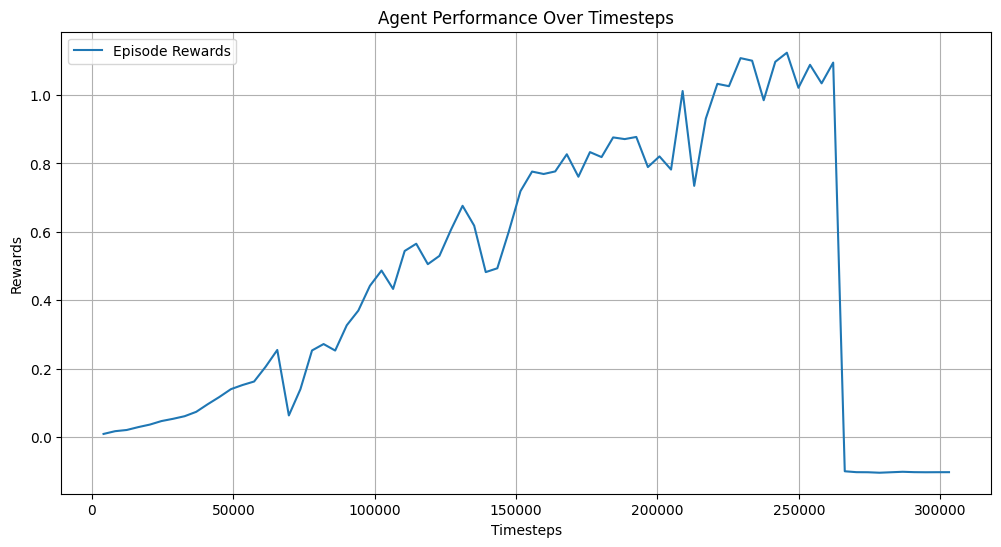

In [12]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=300_000)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


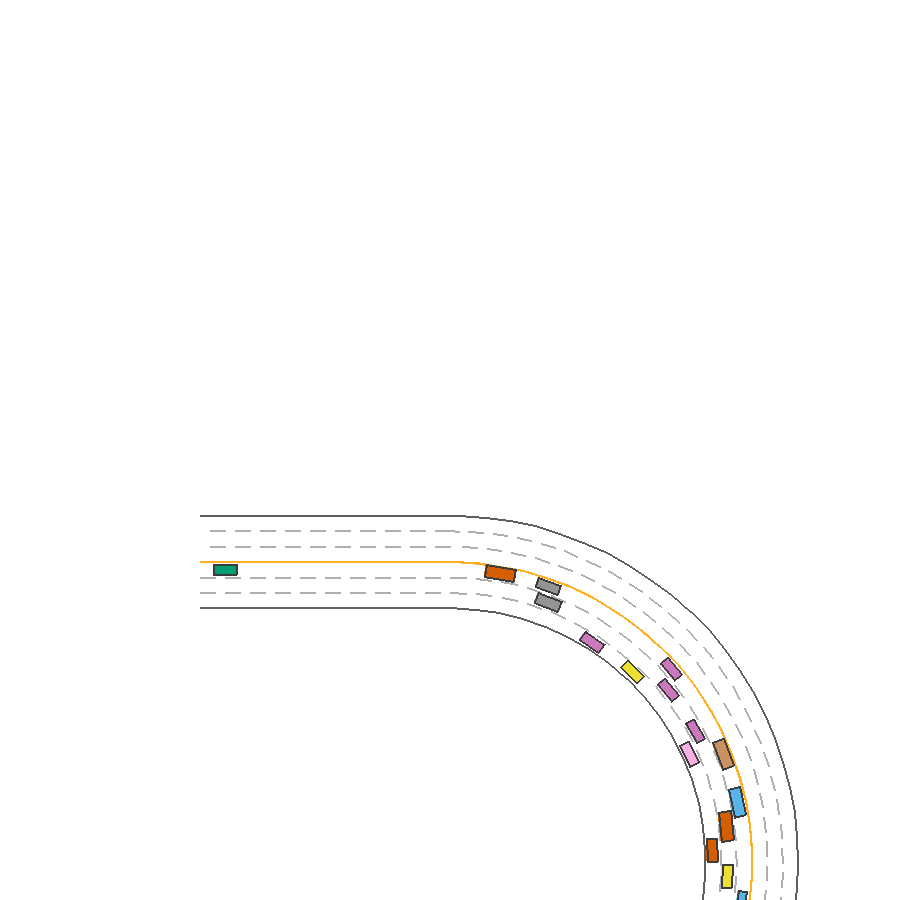

In [13]:
model = models[0][1]

env = create_environment('easy', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE

Training on easy difficulty (With Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 305  |
|    iterations      | 1    |
|    time_elapsed    | 13   |
|    total_timesteps | 4096 |
-----------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.65e+03    |
|    ep_rew_mean          | 39.5        |
| time/                   |             |
|    fps                  | 270         |
|    iterations           | 2           |
|    time_elapsed         | 30          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.015375784 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.014       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0472     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0268     |
|    std                  | 0.977       |
|    value_loss           | 0.0126      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.55e+03    |
|    ep_rew_mean          | 24.9        |
| time/                   |             |
|    fps                  | 257         |
|    iterations           | 3           |
|    time_elapsed         | 47          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.017014641 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.0154      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0741      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0167     |
|    std                  | 0.958       |
|    value_loss           | 0.197       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.12e+03    |
|    ep_rew_mean          | 22.3        |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 4           |
|    time_elapsed         | 66          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014338821 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.0177      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0806      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0103     |
|    std                  | 0.944       |
|    value_loss           | 0.268       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 880         |
|    ep_rew_mean          | 20.7        |
| time/                   |             |
|    fps                  | 240         |
|    iterations           | 5           |
|    time_elapsed         | 85          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.013686917 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.00871     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.109       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0103     |
|    std                  | 0.928       |
|    value_loss           | 0.529       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 699         |
|    ep_rew_mean          | 19.6        |
| time/                   |             |
|    fps                  | 232         |
|    iterations           | 6           |
|    time_elapsed         | 105         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.011695273 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.66       |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.708       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0064     |
|    std                  | 0.909       |
|    value_loss           | 0.708       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 548         |
|    ep_rew_mean          | 17.8        |
| time/                   |             |
|    fps                  | 226         |
|    iterations           | 7           |
|    time_elapsed         | 126         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.008393224 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.423       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0037     |
|    std                  | 0.888       |
|    value_loss           | 0.932       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 504          |
|    ep_rew_mean          | 19.2         |
| time/                   |              |
|    fps                  | 222          |
|    iterations           | 8            |
|    time_elapsed         | 147          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0077506816 |
|    clip_fraction        | 0.0944       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.59        |
|    explained_variance   | 0.516        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.224        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00571     |
|    std                  | 0.881        |
|    value_loss           | 1.24         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 447          |
|    ep_rew_mean          | 18.5         |
| time/                   |              |
|    fps                  | 215          |
|    iterations           | 9            |
|    time_elapsed         | 171          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0029356014 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.55        |
|    explained_variance   | 0.441        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.54         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00243     |
|    std                  | 0.862        |
|    value_loss           | 1.52         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 254         |
|    ep_rew_mean          | 15.3        |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 10          |
|    time_elapsed         | 195         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.009245487 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.326       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00851    |
|    std                  | 0.842       |
|    value_loss           | 0.998       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 204         |
|    ep_rew_mean          | 15.5        |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 11          |
|    time_elapsed         | 217         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.008745443 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | 0.551       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.32        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0019     |
|    std                  | 0.828       |
|    value_loss           | 3.57        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 14.4        |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 12          |
|    time_elapsed         | 242         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.011695975 |
|    clip_fraction        | 0.0973      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.42       |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.617       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00628    |
|    std                  | 0.808       |
|    value_loss           | 2.21        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 15.8        |
| time/                   |             |
|    fps                  | 198         |
|    iterations           | 13          |
|    time_elapsed         | 268         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.011780184 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.746       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0103     |
|    std                  | 0.795       |
|    value_loss           | 2.32        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 156        |
|    ep_rew_mean          | 19.7       |
| time/                   |            |
|    fps                  | 196        |
|    iterations           | 14         |
|    time_elapsed         | 292        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.00840233 |
|    clip_fraction        | 0.0768     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.35      |
|    explained_variance   | 0.466      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.54       |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.00533   |
|    std                  | 0.783      |
|    value_loss           | 5.37       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 23.1        |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 15          |
|    time_elapsed         | 315         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.024400286 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.47        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00519    |
|    std                  | 0.765       |
|    value_loss           | 4.03        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 179         |
|    ep_rew_mean          | 27.9        |
| time/                   |             |
|    fps                  | 193         |
|    iterations           | 16          |
|    time_elapsed         | 338         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.007078304 |
|    clip_fraction        | 0.0921      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.26       |
|    explained_variance   | 0.482       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.02        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00361    |
|    std                  | 0.744       |
|    value_loss           | 5.58        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 194         |
|    ep_rew_mean          | 33.7        |
| time/                   |             |
|    fps                  | 193         |
|    iterations           | 17          |
|    time_elapsed         | 359         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.015914852 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.32        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00544    |
|    std                  | 0.727       |
|    value_loss           | 6.14        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 210         |
|    ep_rew_mean          | 42.7        |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 18          |
|    time_elapsed         | 382         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012516657 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.15       |
|    explained_variance   | 0.199       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.94        |
|    n_updates            | 170         |
|    policy_gradient_loss | 0.00275     |
|    std                  | 0.706       |
|    value_loss           | 7.91        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 215         |
|    ep_rew_mean          | 48.6        |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 19          |
|    time_elapsed         | 407         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.027032806 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.11       |
|    explained_variance   | 0.342       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.99        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00456    |
|    std                  | 0.692       |
|    value_loss           | 14          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 202         |
|    ep_rew_mean          | 51.1        |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 20          |
|    time_elapsed         | 432         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.010916184 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.56        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00846    |
|    std                  | 0.679       |
|    value_loss           | 10.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 207         |
|    ep_rew_mean          | 57.6        |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 21          |
|    time_elapsed         | 455         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.026642054 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.04       |
|    explained_variance   | 0.49        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.35        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00591    |
|    std                  | 0.67        |
|    value_loss           | 16.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 210         |
|    ep_rew_mean          | 64          |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 22          |
|    time_elapsed         | 476         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.022959957 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.366       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.23        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00488    |
|    std                  | 0.651       |
|    value_loss           | 15.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 212        |
|    ep_rew_mean          | 69.8       |
| time/                   |            |
|    fps                  | 187        |
|    iterations           | 23         |
|    time_elapsed         | 502        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.01339454 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | 0.0565     |
|    learning_rate        | 0.0003     |
|    loss                 | 7.07       |
|    n_updates            | 220        |
|    policy_gradient_loss | 0.0057     |
|    std                  | 0.633      |
|    value_loss           | 17.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 209         |
|    ep_rew_mean          | 75.6        |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 24          |
|    time_elapsed         | 527         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.014023034 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.131       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.3        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00518    |
|    std                  | 0.622       |
|    value_loss           | 32.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 217         |
|    ep_rew_mean          | 85.6        |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 25          |
|    time_elapsed         | 551         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.010028722 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.167       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0044     |
|    std                  | 0.613       |
|    value_loss           | 30.9        |
-----------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer)...
Continuing training with transfer learning...


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 202      |
|    ep_rew_mean     | 99.6     |
| time/              |          |
|    fps             | 193      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 195          |
|    ep_rew_mean          | 99.9         |
| time/                   |              |
|    fps                  | 182          |
|    iterations           | 2            |
|    time_elapsed         | 44           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0133780055 |
|    clip_fraction        | 0.209        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | 0.199        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.5         |
|    n_updates            | 260          |
|    policy_gradient_loss | 0.00364      |
|    std                  | 0.587        |
|    value_loss           | 45.6         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 214         |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 3           |
|    time_elapsed         | 68          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.021148525 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.3        |
|    n_updates            | 270         |
|    policy_gradient_loss | 0.00194     |
|    std                  | 0.578       |
|    value_loss           | 52.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 212         |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 176         |
|    iterations           | 4           |
|    time_elapsed         | 92          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014050975 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.7        |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.00875     |
|    std                  | 0.565       |
|    value_loss           | 41.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 204         |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 172         |
|    iterations           | 5           |
|    time_elapsed         | 118         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.025828224 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.208       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.6        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.00344     |
|    std                  | 0.558       |
|    value_loss           | 61.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 204         |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 171         |
|    iterations           | 6           |
|    time_elapsed         | 143         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.017319314 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.4        |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.0111      |
|    std                  | 0.553       |
|    value_loss           | 68.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 213         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 172         |
|    iterations           | 7           |
|    time_elapsed         | 165         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.008109696 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.309       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.3        |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.00108     |
|    std                  | 0.546       |
|    value_loss           | 66.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 99.3        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 8           |
|    time_elapsed         | 201         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.020973824 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.29        |
|    learning_rate        | 0.0003      |
|    loss                 | 27.4        |
|    n_updates            | 320         |
|    policy_gradient_loss | 0.00234     |
|    std                  | 0.538       |
|    value_loss           | 62.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 155         |
|    ep_rew_mean          | 88.1        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 9           |
|    time_elapsed         | 227         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.039094318 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | -0.0534     |
|    learning_rate        | 0.0003      |
|    loss                 | 44.5        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.0114      |
|    std                  | 0.531       |
|    value_loss           | 74.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 87.7        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 10          |
|    time_elapsed         | 252         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010021881 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.468       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.2        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.00386     |
|    std                  | 0.526       |
|    value_loss           | 74.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 155        |
|    ep_rew_mean          | 95         |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 11         |
|    time_elapsed         | 277        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.01822726 |
|    clip_fraction        | 0.157      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.54      |
|    explained_variance   | 0.18       |
|    learning_rate        | 0.0003     |
|    loss                 | 40.3       |
|    n_updates            | 350        |
|    policy_gradient_loss | -0.000669  |
|    std                  | 0.523      |
|    value_loss           | 80.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 157         |
|    ep_rew_mean          | 100         |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 12          |
|    time_elapsed         | 303         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.013939476 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.138       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.3        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.0064      |
|    std                  | 0.523       |
|    value_loss           | 64.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 53.9        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 13          |
|    time_elapsed         | 331         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.015507139 |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.1        |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.0181      |
|    std                  | 0.52        |
|    value_loss           | 118         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 96.9       |
|    ep_rew_mean          | 50         |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 14         |
|    time_elapsed         | 357        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.11458074 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.52      |
|    explained_variance   | 0.256      |
|    learning_rate        | 0.0003     |
|    loss                 | 68.5       |
|    n_updates            | 380        |
|    policy_gradient_loss | -0.00014   |
|    std                  | 0.517      |
|    value_loss           | 123        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 112         |
|    ep_rew_mean          | 66.5        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 15          |
|    time_elapsed         | 383         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.012432614 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.326       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.3        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.000536   |
|    std                  | 0.503       |
|    value_loss           | 78          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 86.7        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 16          |
|    time_elapsed         | 409         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.010030476 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.3        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00468    |
|    std                  | 0.496       |
|    value_loss           | 87.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 17          |
|    time_elapsed         | 434         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.045198794 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.3        |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.00564     |
|    std                  | 0.49        |
|    value_loss           | 79.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 152         |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 18          |
|    time_elapsed         | 460         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.014006525 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.2        |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.00582     |
|    std                  | 0.48        |
|    value_loss           | 103         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 19          |
|    time_elapsed         | 485         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.013807273 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 97.4        |
|    n_updates            | 430         |
|    policy_gradient_loss | 0.00463     |
|    std                  | 0.476       |
|    value_loss           | 114         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 161       |
|    ep_rew_mean          | 134       |
| time/                   |           |
|    fps                  | 159       |
|    iterations           | 20        |
|    time_elapsed         | 512       |
|    total_timesteps      | 81920     |
| train/                  |           |
|    approx_kl            | 0.0340299 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.33     |
|    explained_variance   | 0.346     |
|    learning_rate        | 0.0003    |
|    loss                 | 76.6      |
|    n_updates            | 440       |
|    policy_gradient_loss | 0.017     |
|    std                  | 0.469     |
|    value_loss           | 104       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 21          |
|    time_elapsed         | 538         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.013253102 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.352       |
|    learning_rate        | 0.0003      |
|    loss                 | 49.5        |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.00241     |
|    std                  | 0.466       |
|    value_loss           | 124         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 145         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 22          |
|    time_elapsed         | 563         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.012557273 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.364       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.2        |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.0152      |
|    std                  | 0.465       |
|    value_loss           | 125         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 141         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 23          |
|    time_elapsed         | 588         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.011184974 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.448       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.8        |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.0131      |
|    std                  | 0.459       |
|    value_loss           | 122         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 147         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 24          |
|    time_elapsed         | 613         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.017068766 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.00235     |
|    std                  | 0.455       |
|    value_loss           | 113         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 157         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 25          |
|    time_elapsed         | 637         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.012486482 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.561       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.3        |
|    n_updates            | 490         |
|    policy_gradient_loss | 0.0102      |
|    std                  | 0.454       |
|    value_loss           | 123         |
-----------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Continuing training with transfer learning...


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 147      |
|    ep_rew_mean     | 138      |
| time/              |          |
|    fps             | 181      |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 2           |
|    time_elapsed         | 48          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.026005458 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.389       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.6        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.011       |
|    std                  | 0.444       |
|    value_loss           | 167         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 3           |
|    time_elapsed         | 76          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.011302821 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.281       |
|    learning_rate        | 0.0003      |
|    loss                 | 108         |
|    n_updates            | 520         |
|    policy_gradient_loss | 0.00751     |
|    std                  | 0.444       |
|    value_loss           | 266         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 4           |
|    time_elapsed         | 103         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012956778 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.4         |
|    learning_rate        | 0.0003      |
|    loss                 | 86.1        |
|    n_updates            | 530         |
|    policy_gradient_loss | -1.54e-05   |
|    std                  | 0.44        |
|    value_loss           | 166         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 5           |
|    time_elapsed         | 129         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.015421677 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.1        |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.00358    |
|    std                  | 0.436       |
|    value_loss           | 106         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 6           |
|    time_elapsed         | 155         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.013166894 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.676       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.3        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.0221      |
|    std                  | 0.43        |
|    value_loss           | 78.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 149         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 7           |
|    time_elapsed         | 180         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.021616735 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.8        |
|    n_updates            | 560         |
|    policy_gradient_loss | 0.00706     |
|    std                  | 0.433       |
|    value_loss           | 63.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 159         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 8           |
|    time_elapsed         | 205         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.009159081 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.505       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.4        |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.00711     |
|    std                  | 0.431       |
|    value_loss           | 71.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 170        |
|    ep_rew_mean          | 179        |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 9          |
|    time_elapsed         | 230        |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 0.01953635 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.08      |
|    explained_variance   | 0.507      |
|    learning_rate        | 0.0003     |
|    loss                 | 23         |
|    n_updates            | 580        |
|    policy_gradient_loss | 0.0191     |
|    std                  | 0.425      |
|    value_loss           | 57.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 166        |
|    ep_rew_mean          | 176        |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 10         |
|    time_elapsed         | 256        |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.04791382 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.05      |
|    explained_variance   | 0.668      |
|    learning_rate        | 0.0003     |
|    loss                 | 46.2       |
|    n_updates            | 590        |
|    policy_gradient_loss | 0.00912    |
|    std                  | 0.419      |
|    value_loss           | 68.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 164        |
|    ep_rew_mean          | 177        |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 11         |
|    time_elapsed         | 281        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.01371059 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | 0.424      |
|    learning_rate        | 0.0003     |
|    loss                 | 70.4       |
|    n_updates            | 600        |
|    policy_gradient_loss | 0.00407    |
|    std                  | 0.416      |
|    value_loss           | 142        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 157         |
|    ep_rew_mean          | 166         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 12          |
|    time_elapsed         | 308         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.042972352 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.699       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.2        |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.0106      |
|    std                  | 0.416       |
|    value_loss           | 96.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 164         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 13          |
|    time_elapsed         | 334         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.050278194 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.624       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 620         |
|    policy_gradient_loss | 0.0131      |
|    std                  | 0.412       |
|    value_loss           | 146         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 179         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 14          |
|    time_elapsed         | 359         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013021915 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.977      |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.9        |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.00966     |
|    std                  | 0.405       |
|    value_loss           | 101         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 160      |
|    ep_rew_mean          | 176      |
| time/                   |          |
|    fps                  | 159      |
|    iterations           | 15       |
|    time_elapsed         | 384      |
|    total_timesteps      | 61440    |
| train/                  |          |
|    approx_kl            | 0.018319 |
|    clip_fraction        | 0.184    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.951   |
|    explained_variance   | 0.683    |
|    learning_rate        | 0.0003   |
|    loss                 | 70.3     |
|    n_updates            | 640      |
|    policy_gradient_loss | 0.00592  |
|    std                  | 0.402    |
|    value_loss           | 126      |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode end

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 163        |
|    ep_rew_mean          | 185        |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 16         |
|    time_elapsed         | 409        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.06176757 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.923     |
|    explained_variance   | 0.654      |
|    learning_rate        | 0.0003     |
|    loss                 | 50.8       |
|    n_updates            | 650        |
|    policy_gradient_loss | 0.0125     |
|    std                  | 0.399      |
|    value_loss           | 128        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 17          |
|    time_elapsed         | 435         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.048106804 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.9        |
|    explained_variance   | 0.76        |
|    learning_rate        | 0.0003      |
|    loss                 | 17.1        |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.0276      |
|    std                  | 0.396       |
|    value_loss           | 98.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 133         |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 18          |
|    time_elapsed         | 462         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.051327948 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.878      |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.2        |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.00889     |
|    std                  | 0.392       |
|    value_loss           | 122         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.4        |
|    ep_rew_mean          | 69.2        |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 19          |
|    time_elapsed         | 490         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.014687444 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.871      |
|    explained_variance   | 0.161       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.00453     |
|    std                  | 0.394       |
|    value_loss           | 275         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 84.8       |
|    ep_rew_mean          | 58.8       |
| time/                   |            |
|    fps                  | 156        |
|    iterations           | 20         |
|    time_elapsed         | 524        |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.02112764 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.883     |
|    explained_variance   | 0.538      |
|    learning_rate        | 0.0003     |
|    loss                 | 130        |
|    n_updates            | 690        |
|    policy_gradient_loss | 0.0139     |
|    std                  | 0.399      |
|    value_loss           | 188        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92.2        |
|    ep_rew_mean          | 69.2        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 21          |
|    time_elapsed         | 552         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.018548116 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.901      |
|    explained_variance   | 0.553       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.1        |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.00119     |
|    std                  | 0.401       |
|    value_loss           | 152         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 92.5        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 22          |
|    time_elapsed         | 579         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.025442323 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.913      |
|    explained_variance   | 0.509       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.5        |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.00673     |
|    std                  | 0.403       |
|    value_loss           | 146         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 23          |
|    time_elapsed         | 605         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.059593167 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.914      |
|    explained_variance   | 0.513       |
|    learning_rate        | 0.0003      |
|    loss                 | 79          |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.0143      |
|    std                  | 0.4         |
|    value_loss           | 145         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 142         |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 24          |
|    time_elapsed         | 631         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.028096387 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.891      |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.0003      |
|    loss                 | 39.6        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.0196      |
|    std                  | 0.397       |
|    value_loss           | 130         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 147        |
|    ep_rew_mean          | 166        |
| time/                   |            |
|    fps                  | 155        |
|    iterations           | 25         |
|    time_elapsed         | 657        |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.01784837 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.882     |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.0003     |
|    loss                 | 92.3       |
|    n_updates            | 740        |
|    policy_gradient_loss | 0.0162     |
|    std                  | 0.397      |
|    value_loss           | 158        |
----------------------------------------
Performance for easy difficulty:


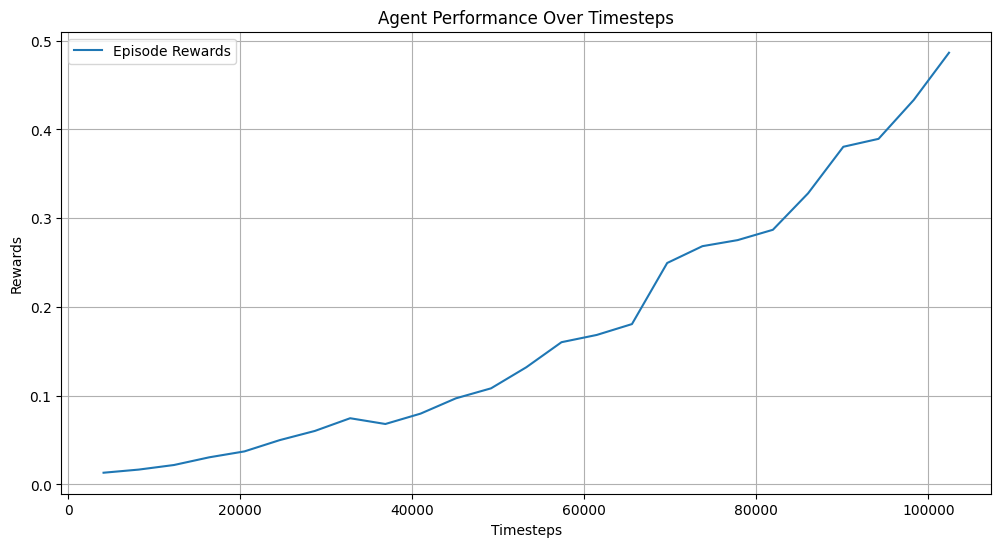

Performance for medium difficulty:


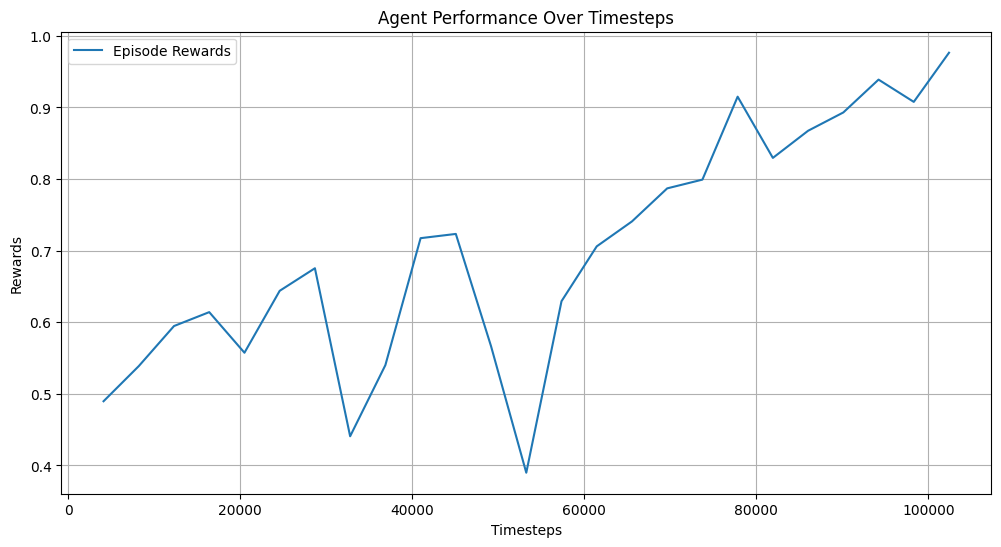

Performance for hard difficulty:


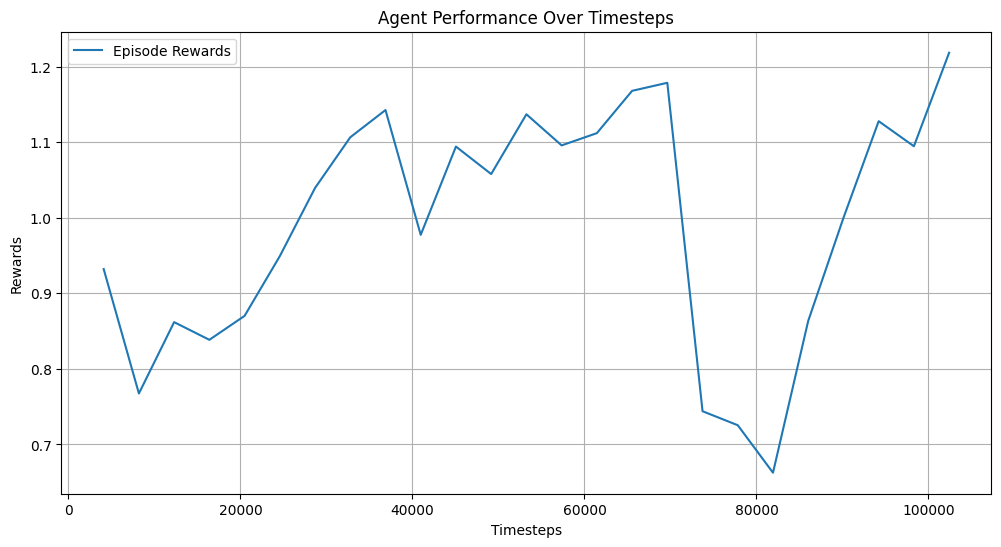

In [ ]:
difficulty_order = ["easy", "medium", "hard"]
results, models = curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=100_000)


In [ ]:
model = models[2][1]

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


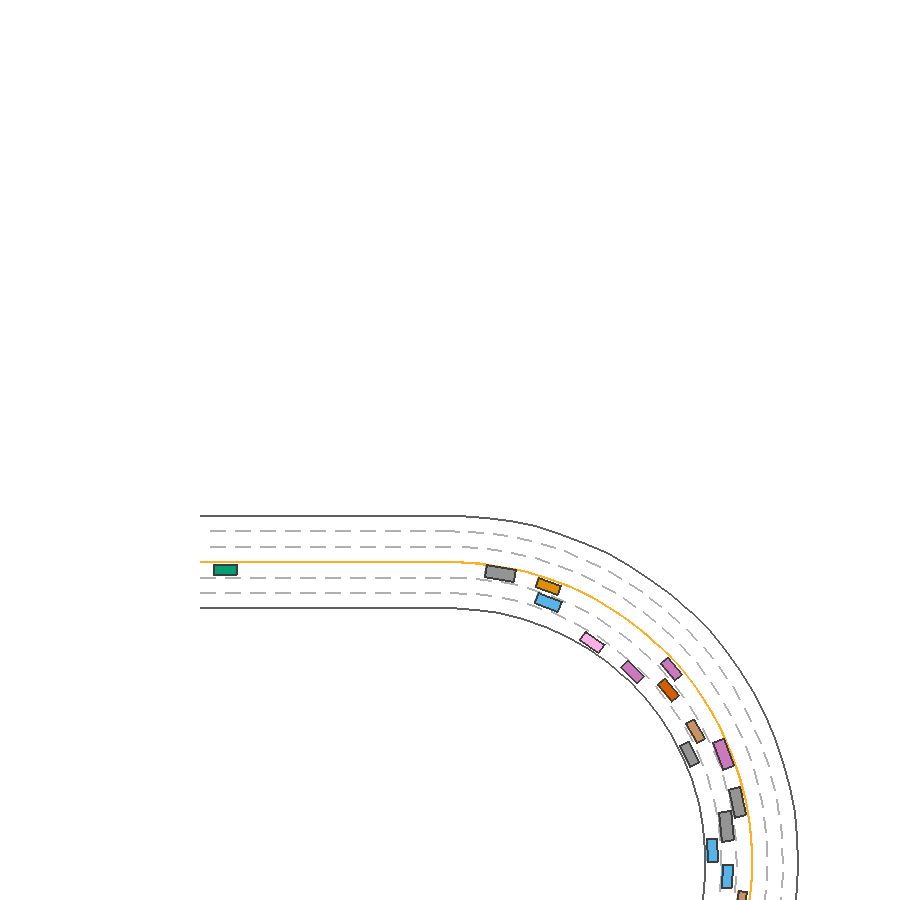

In [ ]:

env = create_environment('hard', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 874      |
|    ep_rew_mean     | 5.35     |
| time/              |          |
|    fps             | 305      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 15.4        |
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 2           |
|    time_elapsed         | 29          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014740182 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.00673     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.26        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.011      |
|    std                  | 0.987       |
|    value_loss           | 0.118       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.34e+03    |
|    ep_rew_mean          | 22.2        |
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 3           |
|    time_elapsed         | 47          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.017153181 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.0617      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.041      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0172     |
|    std                  | 0.965       |
|    value_loss           | 0.127       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 889         |
|    ep_rew_mean          | 16.3        |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 4           |
|    time_elapsed         | 66          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012783472 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.0746      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00519     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0116     |
|    std                  | 0.954       |
|    value_loss           | 0.369       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 923         |
|    ep_rew_mean          | 21.5        |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 5           |
|    time_elapsed         | 83          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008540807 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.0114      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.47        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0064     |
|    std                  | 0.942       |
|    value_loss           | 0.623       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 744         |
|    ep_rew_mean          | 23.7        |
| time/                   |             |
|    fps                  | 237         |
|    iterations           | 6           |
|    time_elapsed         | 103         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.020098938 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.0487      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00847     |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0168     |
|    std                  | 0.897       |
|    value_loss           | 0.433       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 470         |
|    ep_rew_mean          | 16.9        |
| time/                   |             |
|    fps                  | 230         |
|    iterations           | 7           |
|    time_elapsed         | 124         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.012699958 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.61       |
|    explained_variance   | 0.0539      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.829       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00687    |
|    std                  | 0.891       |
|    value_loss           | 1.53        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 413         |
|    ep_rew_mean          | 17.1        |
| time/                   |             |
|    fps                  | 223         |
|    iterations           | 8           |
|    time_elapsed         | 146         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011711538 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.123       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.45        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00807    |
|    std                  | 0.88        |
|    value_loss           | 3.08        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 350         |
|    ep_rew_mean          | 17.3        |
| time/                   |             |
|    fps                  | 219         |
|    iterations           | 9           |
|    time_elapsed         | 167         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.007674328 |
|    clip_fraction        | 0.0731      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | 0.159       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.665       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00405    |
|    std                  | 0.869       |
|    value_loss           | 1.89        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 256         |
|    ep_rew_mean          | 19.4        |
| time/                   |             |
|    fps                  | 216         |
|    iterations           | 10          |
|    time_elapsed         | 189         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008544197 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | 0.475       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00608    |
|    std                  | 0.862       |
|    value_loss           | 2.69        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 201         |
|    ep_rew_mean          | 19.9        |
| time/                   |             |
|    fps                  | 212         |
|    iterations           | 11          |
|    time_elapsed         | 212         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.008869262 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.668       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.787       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00386    |
|    std                  | 0.84        |
|    value_loss           | 2.24        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 176         |
|    ep_rew_mean          | 19.9        |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 12          |
|    time_elapsed         | 236         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.022925813 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.21        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00705    |
|    std                  | 0.829       |
|    value_loss           | 3.73        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 181         |
|    ep_rew_mean          | 23.3        |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 13          |
|    time_elapsed         | 258         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.012256393 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.96        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0121     |
|    std                  | 0.821       |
|    value_loss           | 4.29        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 28.1        |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 14          |
|    time_elapsed         | 282         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.010571159 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.78        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00581    |
|    std                  | 0.796       |
|    value_loss           | 5.06        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 29.5        |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 15          |
|    time_elapsed         | 306         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.010703608 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.332       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.99        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00195    |
|    std                  | 0.784       |
|    value_loss           | 9.01        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 187         |
|    ep_rew_mean          | 38.2        |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 16          |
|    time_elapsed         | 327         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.025888903 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.65        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00373    |
|    std                  | 0.778       |
|    value_loss           | 9.38        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 48.8        |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 17          |
|    time_elapsed         | 349         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.012710544 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.27        |
|    learning_rate        | 0.0003      |
|    loss                 | 4.35        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00189    |
|    std                  | 0.763       |
|    value_loss           | 10.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 224         |
|    ep_rew_mean          | 59.5        |
| time/                   |             |
|    fps                  | 198         |
|    iterations           | 18          |
|    time_elapsed         | 371         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012617153 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.27       |
|    explained_variance   | 0.291       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.2         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.000352   |
|    std                  | 0.745       |
|    value_loss           | 12.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 234         |
|    ep_rew_mean          | 71.2        |
| time/                   |             |
|    fps                  | 198         |
|    iterations           | 19          |
|    time_elapsed         | 391         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.010776606 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.289       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.17        |
|    n_updates            | 180         |
|    policy_gradient_loss | 0.00258     |
|    std                  | 0.727       |
|    value_loss           | 15.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 229        |
|    ep_rew_mean          | 78.6       |
| time/                   |            |
|    fps                  | 197        |
|    iterations           | 20         |
|    time_elapsed         | 415        |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.01386604 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.16      |
|    explained_variance   | 0.233      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.76       |
|    n_updates            | 190        |
|    policy_gradient_loss | 0.00703    |
|    std                  | 0.706      |
|    value_loss           | 15.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 236         |
|    ep_rew_mean          | 88.1        |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 21          |
|    time_elapsed         | 439         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.010112565 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.14       |
|    explained_variance   | 0.21        |
|    learning_rate        | 0.0003      |
|    loss                 | 17.4        |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.0041      |
|    std                  | 0.705       |
|    value_loss           | 40.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 239        |
|    ep_rew_mean          | 98.3       |
| time/                   |            |
|    fps                  | 195        |
|    iterations           | 22         |
|    time_elapsed         | 460        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.01615072 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.13      |
|    explained_variance   | 0.26       |
|    learning_rate        | 0.0003     |
|    loss                 | 13.4       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0025    |
|    std                  | 0.699      |
|    value_loss           | 33.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 242         |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 23          |
|    time_elapsed         | 482         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.008995636 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 220         |
|    policy_gradient_loss | 0.0061      |
|    std                  | 0.687       |
|    value_loss           | 29.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 234         |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 24          |
|    time_elapsed         | 505         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.008610886 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.306       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.98        |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00139     |
|    std                  | 0.676       |
|    value_loss           | 34.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 229         |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 25          |
|    time_elapsed         | 527         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.016121259 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0.244       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.00678     |
|    std                  | 0.657       |
|    value_loss           | 40.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 199         |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 26          |
|    time_elapsed         | 553         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.035092223 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.9        |
|    n_updates            | 250         |
|    policy_gradient_loss | 0.0149      |
|    std                  | 0.65        |
|    value_loss           | 39.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 151         |
|    ep_rew_mean          | 73.7        |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 27          |
|    time_elapsed         | 579         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.015848167 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.8        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0041     |
|    std                  | 0.65        |
|    value_loss           | 114         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 62.9        |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 28          |
|    time_elapsed         | 603         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.014005327 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.5        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.000316   |
|    std                  | 0.643       |
|    value_loss           | 82          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 151         |
|    ep_rew_mean          | 76.7        |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 29          |
|    time_elapsed         | 624         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.039420918 |
|    clip_fraction        | 0.315       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.426       |
|    learning_rate        | 0.0003      |
|    loss                 | 25          |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.014       |
|    std                  | 0.64        |
|    value_loss           | 56.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 175         |
|    ep_rew_mean          | 95.7        |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 30          |
|    time_elapsed         | 647         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.014984809 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.322       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.5        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.0054      |
|    std                  | 0.63        |
|    value_loss           | 46.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | 117        |
| time/                   |            |
|    fps                  | 189        |
|    iterations           | 31         |
|    time_elapsed         | 670        |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.02894158 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.89      |
|    explained_variance   | 0.468      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.8       |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.000918   |
|    std                  | 0.616      |
|    value_loss           | 55.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | 141         |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 32          |
|    time_elapsed         | 691         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.009078087 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | 0.599       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.0116      |
|    std                  | 0.623       |
|    value_loss           | 41.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 243        |
|    ep_rew_mean          | 161        |
| time/                   |            |
|    fps                  | 188        |
|    iterations           | 33         |
|    time_elapsed         | 715        |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.03212233 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.86      |
|    explained_variance   | 0.696      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.89       |
|    n_updates            | 320        |
|    policy_gradient_loss | 0.0152     |
|    std                  | 0.609      |
|    value_loss           | 30.6       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 253         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 34          |
|    time_elapsed         | 738         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.014414303 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.648       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.1        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.00929     |
|    std                  | 0.603       |
|    value_loss           | 46.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 254         |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 35          |
|    time_elapsed         | 760         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.012181433 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | 0.423       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.3        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.0169      |
|    std                  | 0.594       |
|    value_loss           | 76.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 119        |
|    ep_rew_mean          | 73.5       |
| time/                   |            |
|    fps                  | 187        |
|    iterations           | 36         |
|    time_elapsed         | 786        |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.33440542 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.76      |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.0003     |
|    loss                 | 13         |
|    n_updates            | 350        |
|    policy_gradient_loss | 0.0282     |
|    std                  | 0.583      |
|    value_loss           | 30.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75.8        |
|    ep_rew_mean          | 30.7        |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 37          |
|    time_elapsed         | 812         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.010191424 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | -0.0109     |
|    learning_rate        | 0.0003      |
|    loss                 | 80.2        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.00615    |
|    std                  | 0.582       |
|    value_loss           | 207         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 57.7        |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 38          |
|    time_elapsed         | 836         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.010573672 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.372       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.4        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0111     |
|    std                  | 0.575       |
|    value_loss           | 142         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 86.1        |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 39          |
|    time_elapsed         | 859         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.013271547 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.448       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.8        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00419    |
|    std                  | 0.562       |
|    value_loss           | 85.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 40          |
|    time_elapsed         | 883         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.012348337 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.557       |
|    learning_rate        | 0.0003      |
|    loss                 | 35          |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.00569     |
|    std                  | 0.552       |
|    value_loss           | 71.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 141        |
|    ep_rew_mean          | 99.8       |
| time/                   |            |
|    fps                  | 184        |
|    iterations           | 41         |
|    time_elapsed         | 910        |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.20117113 |
|    clip_fraction        | 0.419      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.63      |
|    explained_variance   | 0.715      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.82       |
|    n_updates            | 400        |
|    policy_gradient_loss | 0.0565     |
|    std                  | 0.553      |
|    value_loss           | 29.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 81           |
|    ep_rew_mean          | 36           |
| time/                   |              |
|    fps                  | 182          |
|    iterations           | 42           |
|    time_elapsed         | 940          |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0056030294 |
|    clip_fraction        | 0.0506       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | -0.139       |
|    learning_rate        | 0.0003       |
|    loss                 | 32.3         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00499     |
|    std                  | 0.549        |
|    value_loss           | 134          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.5        |
|    ep_rew_mean          | 45          |
| time/                   |             |
|    fps                  | 181         |
|    iterations           | 43          |
|    time_elapsed         | 967         |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.013029462 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.8        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0132     |
|    std                  | 0.543       |
|    value_loss           | 103         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | 64.3        |
| time/                   |             |
|    fps                  | 181         |
|    iterations           | 44          |
|    time_elapsed         | 994         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.016709633 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.2        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0106     |
|    std                  | 0.534       |
|    value_loss           | 75.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 84.5        |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 45          |
|    time_elapsed         | 1019        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.023907699 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.4        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.526       |
|    value_loss           | 64.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 141         |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 46          |
|    time_elapsed         | 1045        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.014455806 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.192       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.3        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00401    |
|    std                  | 0.517       |
|    value_loss           | 74          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 155        |
|    ep_rew_mean          | 123        |
| time/                   |            |
|    fps                  | 179        |
|    iterations           | 47         |
|    time_elapsed         | 1071       |
|    total_timesteps      | 192512     |
| train/                  |            |
|    approx_kl            | 0.03799728 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.45      |
|    explained_variance   | 0.28       |
|    learning_rate        | 0.0003     |
|    loss                 | 41.5       |
|    n_updates            | 460        |
|    policy_gradient_loss | 0.00438    |
|    std                  | 0.507      |
|    value_loss           | 72.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 137         |
| time/                   |             |
|    fps                  | 179         |
|    iterations           | 48          |
|    time_elapsed         | 1096        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.014034651 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.384       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.5        |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.000191   |
|    std                  | 0.499       |
|    value_loss           | 98.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 167        |
|    ep_rew_mean          | 144        |
| time/                   |            |
|    fps                  | 179        |
|    iterations           | 49         |
|    time_elapsed         | 1120       |
|    total_timesteps      | 200704     |
| train/                  |            |
|    approx_kl            | 0.01773895 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.38      |
|    explained_variance   | 0.512      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.9       |
|    n_updates            | 480        |
|    policy_gradient_loss | 0.000127   |
|    std                  | 0.491      |
|    value_loss           | 90.5       |
----------------------------------------
Performance for easy difficulty:


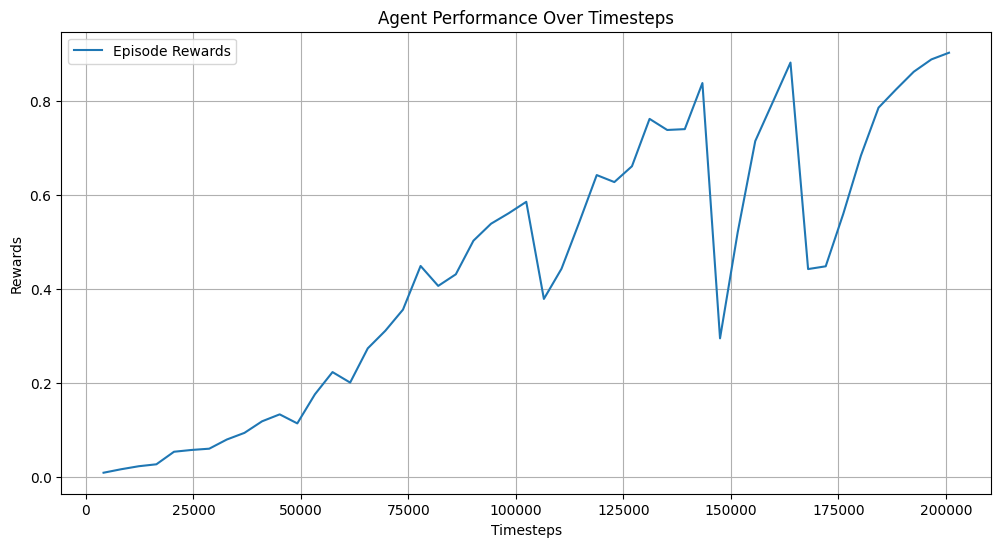

In [ ]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=200_000)

# Curriculum Learning on New Environment (Exhaustive Run)


In [14]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 2, "traffic_density": 0.1, "random_lane_width": False, "use_render": render,
                            #  "out_of_road_penalty": 30.0,  # Increased penalty
                #  "out_of_road_cost":


                 },
        "medium": {"map": 3, "traffic_density": 0.3, "random_lane_width": True, "use_render": render,
                              #  "out_of_road_penalty": 30.0,  # Increased penalty

                   },
        "hard": {"map": 4, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (With Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.98e+03 |
|    ep_rew_mean     | 18.1     |
| time/              |          |
|    fps             | 242      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.36e+03    |
|    ep_rew_mean          | 14.4        |
| time/                   |             |
|    fps                  | 230         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.016579527 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.00168     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0015      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0189     |
|    std                  | 0.979       |
|    value_loss           | 0.0701      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.34e+03    |
|    ep_rew_mean          | 21          |
| time/                   |             |
|    fps                  | 221         |
|    iterations           | 3           |
|    time_elapsed         | 55          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.014708212 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | 0.00477     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.364       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0118     |
|    std                  | 0.968       |
|    value_loss           | 0.212       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | 19          |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 4           |
|    time_elapsed         | 77          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013120532 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.0367      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00957    |
|    std                  | 0.954       |
|    value_loss           | 0.366       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 812         |
|    ep_rew_mean          | 17.2        |
| time/                   |             |
|    fps                  | 202         |
|    iterations           | 5           |
|    time_elapsed         | 101         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.014201365 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | -0.00774    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.174       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0101     |
|    std                  | 0.921       |
|    value_loss           | 0.589       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 702         |
|    ep_rew_mean          | 19.4        |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 6           |
|    time_elapsed         | 127         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.010355422 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.00102     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.462       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00866    |
|    std                  | 0.901       |
|    value_loss           | 0.767       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 559         |
|    ep_rew_mean          | 18.6        |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 7           |
|    time_elapsed         | 154         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.012570639 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | 0.0581      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.34        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0109     |
|    std                  | 0.885       |
|    value_loss           | 1.16        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 441        |
|    ep_rew_mean          | 17.4       |
| time/                   |            |
|    fps                  | 177        |
|    iterations           | 8          |
|    time_elapsed         | 184        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.00911758 |
|    clip_fraction        | 0.0696     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.57      |
|    explained_variance   | 0.212      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.955      |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.00445   |
|    std                  | 0.872      |
|    value_loss           | 1.9        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 276         |
|    ep_rew_mean          | 15.5        |
| time/                   |             |
|    fps                  | 172         |
|    iterations           | 9           |
|    time_elapsed         | 213         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.006300967 |
|    clip_fraction        | 0.0593      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.803       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00411    |
|    std                  | 0.857       |
|    value_loss           | 2.13        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 167        |
|    ep_rew_mean          | 14.7       |
| time/                   |            |
|    fps                  | 167        |
|    iterations           | 10         |
|    time_elapsed         | 243        |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.00732659 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.51      |
|    explained_variance   | 0.325      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.37       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0081    |
|    std                  | 0.846      |
|    value_loss           | 4.58       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | 15.2        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 11          |
|    time_elapsed         | 274         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.008956843 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.04        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00509    |
|    std                  | 0.843       |
|    value_loss           | 3.06        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 140        |
|    ep_rew_mean          | 17.8       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 12         |
|    time_elapsed         | 304        |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.01592685 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.48      |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.77       |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.0104    |
|    std                  | 0.832      |
|    value_loss           | 4.31       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 153         |
|    ep_rew_mean          | 22.4        |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 13          |
|    time_elapsed         | 336         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.007888144 |
|    clip_fraction        | 0.0707      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.58        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.000764   |
|    std                  | 0.823       |
|    value_loss           | 5.31        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 134          |
|    ep_rew_mean          | 20.6         |
| time/                   |              |
|    fps                  | 156          |
|    iterations           | 14           |
|    time_elapsed         | 367          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0120736975 |
|    clip_fraction        | 0.0786       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.43        |
|    explained_variance   | 0.6          |
|    learning_rate        | 0.0003       |
|    loss                 | 2.44         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00135     |
|    std                  | 0.81         |
|    value_loss           | 5.74         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 22.5        |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 15          |
|    time_elapsed         | 398         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.013267837 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.4        |
|    explained_variance   | 0.653       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.75        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00965    |
|    std                  | 0.798       |
|    value_loss           | 8.07        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 137          |
|    ep_rew_mean          | 25.6         |
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 16           |
|    time_elapsed         | 427          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0075760623 |
|    clip_fraction        | 0.0971       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.58         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00198     |
|    std                  | 0.785        |
|    value_loss           | 7.95         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 151         |
|    ep_rew_mean          | 33.6        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 17          |
|    time_elapsed         | 458         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.010963287 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.32       |
|    explained_variance   | 0.503       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.05        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.005      |
|    std                  | 0.766       |
|    value_loss           | 9.94        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 44.1        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 18          |
|    time_elapsed         | 488         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.008445279 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.27       |
|    explained_variance   | 0.214       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.65        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00176    |
|    std                  | 0.746       |
|    value_loss           | 14.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 182         |
|    ep_rew_mean          | 51.5        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 19          |
|    time_elapsed         | 519         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.008699451 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.305       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.08        |
|    n_updates            | 180         |
|    policy_gradient_loss | 0.00213     |
|    std                  | 0.737       |
|    value_loss           | 13.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 190          |
|    ep_rew_mean          | 59           |
| time/                   |              |
|    fps                  | 148          |
|    iterations           | 20           |
|    time_elapsed         | 550          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0126843285 |
|    clip_fraction        | 0.188        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.2         |
|    explained_variance   | 0.316        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.2         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00659     |
|    std                  | 0.721        |
|    value_loss           | 24.5         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 197         |
|    ep_rew_mean          | 67.7        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 21          |
|    time_elapsed         | 580         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.008705229 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.295       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.45        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00146    |
|    std                  | 0.707       |
|    value_loss           | 26          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 194      |
|    ep_rew_mean          | 70.2     |
| time/                   |          |
|    fps                  | 147      |
|    iterations           | 22       |
|    time_elapsed         | 611      |
|    total_timesteps      | 90112    |
| train/                  |          |
|    approx_kl            | 0.031399 |
|    clip_fraction        | 0.18     |
|    clip_range           | 0.2      |
|    entropy_loss         | -2.13    |
|    explained_variance   | 0.186    |
|    learning_rate        | 0.0003   |
|    loss                 | 7.43     |
|    n_updates            | 210      |
|    policy_gradient_loss | 0.00535  |
|    std                  | 0.695    |
|    value_loss           | 25.6     |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 197        |
|    ep_rew_mean          | 79         |
| time/                   |            |
|    fps                  | 146        |
|    iterations           | 23         |
|    time_elapsed         | 645        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.02254112 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.09      |
|    explained_variance   | 0.231      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.14       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.000907  |
|    std                  | 0.681      |
|    value_loss           | 25.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 215         |
|    ep_rew_mean          | 94.3        |
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 24          |
|    time_elapsed         | 676         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.005873032 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.2        |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00208     |
|    std                  | 0.669       |
|    value_loss           | 40          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 220         |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 144         |
|    iterations           | 25          |
|    time_elapsed         | 708         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.010202405 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.99        |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.0015      |
|    std                  | 0.664       |
|    value_loss           | 41          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 226         |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 26          |
|    time_elapsed         | 739         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.012040442 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.1        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00246    |
|    std                  | 0.655       |
|    value_loss           | 55          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 233       |
|    ep_rew_mean          | 127       |
| time/                   |           |
|    fps                  | 143       |
|    iterations           | 27        |
|    time_elapsed         | 770       |
|    total_timesteps      | 110592    |
| train/                  |           |
|    approx_kl            | 0.0200091 |
|    clip_fraction        | 0.226     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.97     |
|    explained_variance   | 0.194     |
|    learning_rate        | 0.0003    |
|    loss                 | 22        |
|    n_updates            | 260       |
|    policy_gradient_loss | 0.00989   |
|    std                  | 0.643     |
|    value_loss           | 44.9      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 215        |
|    ep_rew_mean          | 122        |
| time/                   |            |
|    fps                  | 143        |
|    iterations           | 28         |
|    time_elapsed         | 801        |
|    total_timesteps      | 114688     |
| train/                  |            |
|    approx_kl            | 0.02027098 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | 0.29       |
|    learning_rate        | 0.0003     |
|    loss                 | 20.2       |
|    n_updates            | 270        |
|    policy_gradient_loss | 0.0114     |
|    std                  | 0.633      |
|    value_loss           | 55.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | 135         |
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 29          |
|    time_elapsed         | 832         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.014042534 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.313       |
|    learning_rate        | 0.0003      |
|    loss                 | 41.7        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00374    |
|    std                  | 0.626       |
|    value_loss           | 77.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 221         |
|    ep_rew_mean          | 137         |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 30          |
|    time_elapsed         | 865         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.013557663 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.2        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.00509     |
|    std                  | 0.622       |
|    value_loss           | 61.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 230        |
|    ep_rew_mean          | 150        |
| time/                   |            |
|    fps                  | 141        |
|    iterations           | 31         |
|    time_elapsed         | 898        |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.00605031 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.87      |
|    explained_variance   | 0.251      |
|    learning_rate        | 0.0003     |
|    loss                 | 38.1       |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.00697    |
|    std                  | 0.614      |
|    value_loss           | 67.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 228         |
|    ep_rew_mean          | 154         |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 32          |
|    time_elapsed         | 930         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.019902878 |
|    clip_fraction        | 0.294       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.321       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.2        |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.0259      |
|    std                  | 0.606       |
|    value_loss           | 67.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 228         |
|    ep_rew_mean          | 160         |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 33          |
|    time_elapsed         | 962         |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.025954273 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.3        |
|    n_updates            | 320         |
|    policy_gradient_loss | 0.00317     |
|    std                  | 0.602       |
|    value_loss           | 86.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 237         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 34          |
|    time_elapsed         | 995         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.036814887 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.0003      |
|    loss                 | 22          |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.014       |
|    std                  | 0.6         |
|    value_loss           | 92.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 239         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 35          |
|    time_elapsed         | 1027        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.008545695 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | 0.347       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.1        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.00217     |
|    std                  | 0.597       |
|    value_loss           | 101         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 228        |
|    ep_rew_mean          | 171        |
| time/                   |            |
|    fps                  | 139        |
|    iterations           | 36         |
|    time_elapsed         | 1060       |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.10432717 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.78      |
|    explained_variance   | 0.381      |
|    learning_rate        | 0.0003     |
|    loss                 | 67.4       |
|    n_updates            | 350        |
|    policy_gradient_loss | 0.0151     |
|    std                  | 0.587      |
|    value_loss           | 98.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 217         |
|    ep_rew_mean          | 166         |
| time/                   |             |
|    fps                  | 138         |
|    iterations           | 37          |
|    time_elapsed         | 1093        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.009060384 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.341       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.9        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.00302     |
|    std                  | 0.584       |
|    value_loss           | 113         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 211         |
|    ep_rew_mean          | 163         |
| time/                   |             |
|    fps                  | 138         |
|    iterations           | 38          |
|    time_elapsed         | 1125        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.015511016 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.339       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.00734     |
|    std                  | 0.576       |
|    value_loss           | 119         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 211         |
|    ep_rew_mean          | 169         |
| time/                   |             |
|    fps                  | 138         |
|    iterations           | 39          |
|    time_elapsed         | 1157        |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.024421964 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.191       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.3        |
|    n_updates            | 380         |
|    policy_gradient_loss | 0.0315      |
|    std                  | 0.573       |
|    value_loss           | 132         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 197         |
|    ep_rew_mean          | 157         |
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 40          |
|    time_elapsed         | 1190        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.015381981 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.0003      |
|    loss                 | 105         |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.0314      |
|    std                  | 0.567       |
|    value_loss           | 125         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 195         |
|    ep_rew_mean          | 157         |
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 41          |
|    time_elapsed         | 1222        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.012235326 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 64          |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.0126      |
|    std                  | 0.568       |
|    value_loss           | 159         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 195         |
|    ep_rew_mean          | 158         |
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 42          |
|    time_elapsed         | 1255        |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.013354398 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.291       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.9        |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.0115      |
|    std                  | 0.563       |
|    value_loss           | 151         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 174         |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 43          |
|    time_elapsed         | 1287        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.021732714 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.366       |
|    learning_rate        | 0.0003      |
|    loss                 | 41.1        |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.00396     |
|    std                  | 0.556       |
|    value_loss           | 141         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 204         |
|    ep_rew_mean          | 173         |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 44          |
|    time_elapsed         | 1320        |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.028998487 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.354       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.8        |
|    n_updates            | 430         |
|    policy_gradient_loss | 0.0115      |
|    std                  | 0.554       |
|    value_loss           | 99.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 179         |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 45          |
|    time_elapsed         | 1353        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.015088045 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.324       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.1        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.548       |
|    value_loss           | 117         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 193       |
|    ep_rew_mean          | 164       |
| time/                   |           |
|    fps                  | 135       |
|    iterations           | 46        |
|    time_elapsed         | 1386      |
|    total_timesteps      | 188416    |
| train/                  |           |
|    approx_kl            | 0.0908936 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.61     |
|    explained_variance   | 0.357     |
|    learning_rate        | 0.0003    |
|    loss                 | 125       |
|    n_updates            | 450       |
|    policy_gradient_loss | 0.0106    |
|    std                  | 0.548     |
|    value_loss           | 160       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 172        |
|    ep_rew_mean          | 141        |
| time/                   |            |
|    fps                  | 135        |
|    iterations           | 47         |
|    time_elapsed         | 1419       |
|    total_timesteps      | 192512     |
| train/                  |            |
|    approx_kl            | 0.17365763 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.61      |
|    explained_variance   | 0.203      |
|    learning_rate        | 0.0003     |
|    loss                 | 85.1       |
|    n_updates            | 460        |
|    policy_gradient_loss | 0.018      |
|    std                  | 0.546      |
|    value_loss           | 200        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 172         |
|    ep_rew_mean          | 142         |
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 48          |
|    time_elapsed         | 1452        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.013623992 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.317       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.2        |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.000912    |
|    std                  | 0.539       |
|    value_loss           | 173         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 179         |
|    ep_rew_mean          | 154         |
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 49          |
|    time_elapsed         | 1486        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.010211452 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.396       |
|    learning_rate        | 0.0003      |
|    loss                 | 67          |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.000543    |
|    std                  | 0.532       |
|    value_loss           | 153         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 189         |
|    ep_rew_mean          | 170         |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 50          |
|    time_elapsed         | 1519        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.023720842 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.6        |
|    n_updates            | 490         |
|    policy_gradient_loss | 0.0422      |
|    std                  | 0.527       |
|    value_loss           | 112         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 205         |
|    ep_rew_mean          | 191         |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 51          |
|    time_elapsed         | 1553        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.007042655 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.3        |
|    n_updates            | 500         |
|    policy_gradient_loss | 0.0173      |
|    std                  | 0.522       |
|    value_loss           | 123         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 219         |
|    ep_rew_mean          | 210         |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 52          |
|    time_elapsed         | 1586        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.033467684 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.552       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.6        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.0116      |
|    std                  | 0.516       |
|    value_loss           | 133         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 224        |
|    ep_rew_mean          | 220        |
| time/                   |            |
|    fps                  | 134        |
|    iterations           | 53         |
|    time_elapsed         | 1619       |
|    total_timesteps      | 217088     |
| train/                  |            |
|    approx_kl            | 0.03022725 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.47      |
|    explained_variance   | 0.587      |
|    learning_rate        | 0.0003     |
|    loss                 | 53.8       |
|    n_updates            | 520        |
|    policy_gradient_loss | 0.0199     |
|    std                  | 0.507      |
|    value_loss           | 127        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | 223         |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 54          |
|    time_elapsed         | 1651        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.015940838 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.533       |
|    learning_rate        | 0.0003      |
|    loss                 | 110         |
|    n_updates            | 530         |
|    policy_gradient_loss | 0.0158      |
|    std                  | 0.503       |
|    value_loss           | 159         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | 224         |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 55          |
|    time_elapsed         | 1684        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.043913234 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.527       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.7        |
|    n_updates            | 540         |
|    policy_gradient_loss | 0.00947     |
|    std                  | 0.506       |
|    value_loss           | 147         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 217        |
|    ep_rew_mean          | 213        |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 56         |
|    time_elapsed         | 1715       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.04787921 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.43      |
|    explained_variance   | 0.537      |
|    learning_rate        | 0.0003     |
|    loss                 | 69.7       |
|    n_updates            | 550        |
|    policy_gradient_loss | 0.0068     |
|    std                  | 0.503      |
|    value_loss           | 143        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 215        |
|    ep_rew_mean          | 212        |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 57         |
|    time_elapsed         | 1749       |
|    total_timesteps      | 233472     |
| train/                  |            |
|    approx_kl            | 0.05236482 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | 0.222      |
|    learning_rate        | 0.0003     |
|    loss                 | 87         |
|    n_updates            | 560        |
|    policy_gradient_loss | 0.019      |
|    std                  | 0.498      |
|    value_loss           | 171        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 213          |
|    ep_rew_mean          | 209          |
| time/                   |              |
|    fps                  | 133          |
|    iterations           | 58           |
|    time_elapsed         | 1782         |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0124155395 |
|    clip_fraction        | 0.222        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.557        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.5         |
|    n_updates            | 570          |
|    policy_gradient_loss | 0.0103       |
|    std                  | 0.499        |
|    value_loss           | 146          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 220      |
|    ep_rew_mean          | 218      |
| time/                   |          |
|    fps                  | 133      |
|    iterations           | 59       |
|    time_elapsed         | 1815     |
|    total_timesteps      | 241664   |
| train/                  |          |
|    approx_kl            | 0.023952 |
|    clip_fraction        | 0.227    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.38    |
|    explained_variance   | 0.631    |
|    learning_rate        | 0.0003   |
|    loss                 | 47.1     |
|    n_updates            | 580      |
|    policy_gradient_loss | 0.0123   |
|    std                  | 0.493    |
|    value_loss           | 132      |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 222         |
|    ep_rew_mean          | 222         |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 60          |
|    time_elapsed         | 1848        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.026854858 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.0003      |
|    loss                 | 90.8        |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.0162      |
|    std                  | 0.487       |
|    value_loss           | 74.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 227         |
|    ep_rew_mean          | 230         |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 61          |
|    time_elapsed         | 1881        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.022868773 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.8        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.0337      |
|    std                  | 0.482       |
|    value_loss           | 71.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 234         |
|    ep_rew_mean          | 243         |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 62          |
|    time_elapsed         | 1915        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.015018055 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.0003      |
|    loss                 | 49          |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.012       |
|    std                  | 0.475       |
|    value_loss           | 67.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 242         |
|    ep_rew_mean          | 258         |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 63          |
|    time_elapsed         | 1949        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.015026991 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.7        |
|    n_updates            | 620         |
|    policy_gradient_loss | 0.00385     |
|    std                  | 0.475       |
|    value_loss           | 98.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 243         |
|    ep_rew_mean          | 262         |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 64          |
|    time_elapsed         | 1983        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.037873294 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.5        |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.0315      |
|    std                  | 0.473       |
|    value_loss           | 69.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 239         |
|    ep_rew_mean          | 259         |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 65          |
|    time_elapsed         | 2016        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.010122948 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.8        |
|    n_updates            | 640         |
|    policy_gradient_loss | 0.00702     |
|    std                  | 0.469       |
|    value_loss           | 103         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 235         |
|    ep_rew_mean          | 255         |
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 66          |
|    time_elapsed         | 2050        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.031231718 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.2        |
|    n_updates            | 650         |
|    policy_gradient_loss | 0.0102      |
|    std                  | 0.466       |
|    value_loss           | 104         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 218        |
|    ep_rew_mean          | 232        |
| time/                   |            |
|    fps                  | 131        |
|    iterations           | 67         |
|    time_elapsed         | 2084       |
|    total_timesteps      | 274432     |
| train/                  |            |
|    approx_kl            | 0.17487068 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.25      |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.2       |
|    n_updates            | 660        |
|    policy_gradient_loss | 0.0355     |
|    std                  | 0.46       |
|    value_loss           | 50.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 216        |
|    ep_rew_mean          | 229        |
| time/                   |            |
|    fps                  | 131        |
|    iterations           | 68         |
|    time_elapsed         | 2118       |
|    total_timesteps      | 278528     |
| train/                  |            |
|    approx_kl            | 0.01531374 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.427      |
|    learning_rate        | 0.0003     |
|    loss                 | 101        |
|    n_updates            | 670        |
|    policy_gradient_loss | 0.00167    |
|    std                  | 0.458      |
|    value_loss           | 225        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 216        |
|    ep_rew_mean          | 232        |
| time/                   |            |
|    fps                  | 131        |
|    iterations           | 69         |
|    time_elapsed         | 2152       |
|    total_timesteps      | 282624     |
| train/                  |            |
|    approx_kl            | 0.01129458 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.0003     |
|    loss                 | 119        |
|    n_updates            | 680        |
|    policy_gradient_loss | 0.00318    |
|    std                  | 0.459      |
|    value_loss           | 105        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 199         |
|    ep_rew_mean          | 207         |
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 70          |
|    time_elapsed         | 2186        |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.018843096 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.3        |
|    n_updates            | 690         |
|    policy_gradient_loss | 0.043       |
|    std                  | 0.453       |
|    value_loss           | 75.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 197          |
|    ep_rew_mean          | 206          |
| time/                   |              |
|    fps                  | 131          |
|    iterations           | 71           |
|    time_elapsed         | 2219         |
|    total_timesteps      | 290816       |
| train/                  |              |
|    approx_kl            | 0.0151757505 |
|    clip_fraction        | 0.185        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.448        |
|    learning_rate        | 0.0003       |
|    loss                 | 99.4         |
|    n_updates            | 700          |
|    policy_gradient_loss | 0.00633      |
|    std                  | 0.449        |
|    value_loss           | 192          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 210         |
|    ep_rew_mean          | 225         |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 72          |
|    time_elapsed         | 2253        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.038990527 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 19          |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.0198      |
|    std                  | 0.448       |
|    value_loss           | 119         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 207         |
|    ep_rew_mean          | 223         |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 73          |
|    time_elapsed         | 2288        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.029657349 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.6        |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.0155      |
|    std                  | 0.446       |
|    value_loss           | 112         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 205         |
|    ep_rew_mean          | 223         |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 74          |
|    time_elapsed         | 2322        |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.011781232 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.3        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.0254      |
|    std                  | 0.441       |
|    value_loss           | 125         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 217         |
|    ep_rew_mean          | 242         |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 75          |
|    time_elapsed         | 2356        |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.017011512 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.5        |
|    n_updates            | 740         |
|    policy_gradient_loss | 0.0172      |
|    std                  | 0.44        |
|    value_loss           | 61.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 220        |
|    ep_rew_mean          | 249        |
| time/                   |            |
|    fps                  | 130        |
|    iterations           | 76         |
|    time_elapsed         | 2391       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.03274648 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.12      |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.0003     |
|    loss                 | 85.2       |
|    n_updates            | 750        |
|    policy_gradient_loss | 0.049      |
|    std                  | 0.437      |
|    value_loss           | 84.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 220         |
|    ep_rew_mean          | 253         |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 77          |
|    time_elapsed         | 2425        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.019007545 |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.04        |
|    n_updates            | 760         |
|    policy_gradient_loss | 0.0323      |
|    std                  | 0.437       |
|    value_loss           | 63.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 151        |
|    ep_rew_mean          | 152        |
| time/                   |            |
|    fps                  | 130        |
|    iterations           | 78         |
|    time_elapsed         | 2457       |
|    total_timesteps      | 319488     |
| train/                  |            |
|    approx_kl            | 0.08931166 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.0003     |
|    loss                 | 20.2       |
|    n_updates            | 770        |
|    policy_gradient_loss | 0.0158     |
|    std                  | 0.431      |
|    value_loss           | 65.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 82.6       |
|    ep_rew_mean          | 49.7       |
| time/                   |            |
|    fps                  | 130        |
|    iterations           | 79         |
|    time_elapsed         | 2488       |
|    total_timesteps      | 323584     |
| train/                  |            |
|    approx_kl            | 0.04658381 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.08      |
|    explained_variance   | -0.323     |
|    learning_rate        | 0.0003     |
|    loss                 | 215        |
|    n_updates            | 780        |
|    policy_gradient_loss | 0.00159    |
|    std                  | 0.428      |
|    value_loss           | 246        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 46.2        |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 80          |
|    time_elapsed         | 2520        |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.040410217 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.528       |
|    learning_rate        | 0.0003      |
|    loss                 | 68          |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.00156    |
|    std                  | 0.428       |
|    value_loss           | 169         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.4        |
|    ep_rew_mean          | 45.7        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 81          |
|    time_elapsed         | 2552        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.033811174 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.1        |
|    n_updates            | 800         |
|    policy_gradient_loss | 0.0197      |
|    std                  | 0.424       |
|    value_loss           | 67          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 84.5        |
|    ep_rew_mean          | 50.6        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 82          |
|    time_elapsed         | 2584        |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.027026374 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.77        |
|    n_updates            | 810         |
|    policy_gradient_loss | 0.00456     |
|    std                  | 0.424       |
|    value_loss           | 35.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 93.2       |
|    ep_rew_mean          | 60.7       |
| time/                   |            |
|    fps                  | 129        |
|    iterations           | 83         |
|    time_elapsed         | 2617       |
|    total_timesteps      | 339968     |
| train/                  |            |
|    approx_kl            | 0.04296098 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.07      |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.5       |
|    n_updates            | 820        |
|    policy_gradient_loss | 0.000886   |
|    std                  | 0.429      |
|    value_loss           | 31.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.8        |
|    ep_rew_mean          | 66.9        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 84          |
|    time_elapsed         | 2650        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.019523565 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.706       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.5        |
|    n_updates            | 830         |
|    policy_gradient_loss | 0.00119     |
|    std                  | 0.433       |
|    value_loss           | 46.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 75.5        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 85          |
|    time_elapsed         | 2684        |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.009642615 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.8        |
|    n_updates            | 840         |
|    policy_gradient_loss | 0.00566     |
|    std                  | 0.434       |
|    value_loss           | 38.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | 92.2        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 86          |
|    time_elapsed         | 2717        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.017244004 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.9        |
|    n_updates            | 850         |
|    policy_gradient_loss | 0.00639     |
|    std                  | 0.432       |
|    value_loss           | 85.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 87          |
|    time_elapsed         | 2752        |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.008169415 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.632       |
|    learning_rate        | 0.0003      |
|    loss                 | 49          |
|    n_updates            | 860         |
|    policy_gradient_loss | 0.0121      |
|    std                  | 0.433       |
|    value_loss           | 125         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 116         |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 88          |
|    time_elapsed         | 2784        |
|    total_timesteps      | 360448      |
| train/                  |             |
|    approx_kl            | 0.020808987 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 89          |
|    n_updates            | 870         |
|    policy_gradient_loss | 0.00513     |
|    std                  | 0.43        |
|    value_loss           | 112         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 79.8        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 89          |
|    time_elapsed         | 2817        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.029112387 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.0003      |
|    loss                 | 83.9        |
|    n_updates            | 880         |
|    policy_gradient_loss | 0.00122     |
|    std                  | 0.428       |
|    value_loss           | 205         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.9        |
|    ep_rew_mean          | 70.9        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 90          |
|    time_elapsed         | 2849        |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.029919479 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.7        |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00125    |
|    std                  | 0.425       |
|    value_loss           | 163         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 94.7      |
|    ep_rew_mean          | 70        |
| time/                   |           |
|    fps                  | 129       |
|    iterations           | 91        |
|    time_elapsed         | 2882      |
|    total_timesteps      | 372736    |
| train/                  |           |
|    approx_kl            | 0.0845979 |
|    clip_fraction        | 0.217     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.04     |
|    explained_variance   | 0.541     |
|    learning_rate        | 0.0003    |
|    loss                 | 117       |
|    n_updates            | 900       |
|    policy_gradient_loss | 0.00222   |
|    std                  | 0.422     |
|    value_loss           | 137       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 85.2        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 92          |
|    time_elapsed         | 2916        |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.011167941 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.19        |
|    learning_rate        | 0.0003      |
|    loss                 | 91          |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00476     |
|    std                  | 0.426       |
|    value_loss           | 228         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 109         |
|    ep_rew_mean          | 95.9        |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 93          |
|    time_elapsed         | 2950        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.017050918 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.402       |
|    learning_rate        | 0.0003      |
|    loss                 | 104         |
|    n_updates            | 920         |
|    policy_gradient_loss | 0.0146      |
|    std                  | 0.419       |
|    value_loss           | 196         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 94          |
|    time_elapsed         | 2984        |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.010306847 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.986      |
|    explained_variance   | 0.381       |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.00269    |
|    std                  | 0.414       |
|    value_loss           | 213         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 129         |
|    ep_rew_mean          | 128         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 95          |
|    time_elapsed         | 3018        |
|    total_timesteps      | 389120      |
| train/                  |             |
|    approx_kl            | 0.008803692 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.956      |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.6        |
|    n_updates            | 940         |
|    policy_gradient_loss | 0.0122      |
|    std                  | 0.41        |
|    value_loss           | 180         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 145         |
|    ep_rew_mean          | 156         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 96          |
|    time_elapsed         | 3053        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.045907505 |
|    clip_fraction        | 0.315       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.921      |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.4        |
|    n_updates            | 950         |
|    policy_gradient_loss | 0.0184      |
|    std                  | 0.404       |
|    value_loss           | 127         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 124        |
|    ep_rew_mean          | 129        |
| time/                   |            |
|    fps                  | 128        |
|    iterations           | 97         |
|    time_elapsed         | 3085       |
|    total_timesteps      | 397312     |
| train/                  |            |
|    approx_kl            | 0.10018207 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.89      |
|    explained_variance   | 0.655      |
|    learning_rate        | 0.0003     |
|    loss                 | 28.3       |
|    n_updates            | 960        |
|    policy_gradient_loss | 0.0281     |
|    std                  | 0.4        |
|    value_loss           | 102        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 97.7        |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 98          |
|    time_elapsed         | 3119        |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.079087615 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.872      |
|    explained_variance   | 0.118       |
|    learning_rate        | 0.0003      |
|    loss                 | 177         |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.0008     |
|    std                  | 0.398       |
|    value_loss           | 313         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 89.5        |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 99          |
|    time_elapsed         | 3152        |
|    total_timesteps      | 405504      |
| train/                  |             |
|    approx_kl            | 0.009065507 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.846      |
|    explained_variance   | 0.418       |
|    learning_rate        | 0.0003      |
|    loss                 | 159         |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.00356    |
|    std                  | 0.393       |
|    value_loss           | 210         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 113         |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 100         |
|    time_elapsed         | 3186        |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.018025793 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.816      |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.0003      |
|    loss                 | 117         |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.0067     |
|    std                  | 0.387       |
|    value_loss           | 238         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 101         |
|    time_elapsed         | 3221        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.013091842 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.786      |
|    explained_variance   | 0.638       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.3        |
|    n_updates            | 1000        |
|    policy_gradient_loss | 0.00478     |
|    std                  | 0.385       |
|    value_loss           | 122         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | 152         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 102         |
|    time_elapsed         | 3256        |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.014333141 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.763      |
|    explained_variance   | 0.621       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.8        |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.0106      |
|    std                  | 0.382       |
|    value_loss           | 119         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 153         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 103         |
|    time_elapsed         | 3290        |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.016901787 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.756      |
|    explained_variance   | 0.663       |
|    learning_rate        | 0.0003      |
|    loss                 | 43.1        |
|    n_updates            | 1020        |
|    policy_gradient_loss | 0.00795     |
|    std                  | 0.382       |
|    value_loss           | 115         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 195         |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 104         |
|    time_elapsed         | 3325        |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.018127091 |
|    clip_fraction        | 0.307       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.753      |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.9        |
|    n_updates            | 1030        |
|    policy_gradient_loss | 0.0311      |
|    std                  | 0.385       |
|    value_loss           | 138         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 196         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 105         |
|    time_elapsed         | 3360        |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.032016017 |
|    clip_fraction        | 0.327       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.75       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.5        |
|    n_updates            | 1040        |
|    policy_gradient_loss | 0.0374      |
|    std                  | 0.383       |
|    value_loss           | 94.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 209         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 106         |
|    time_elapsed         | 3395        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.012210553 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.743      |
|    explained_variance   | 0.643       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.5        |
|    n_updates            | 1050        |
|    policy_gradient_loss | 0.00404     |
|    std                  | 0.385       |
|    value_loss           | 170         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 214         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 107         |
|    time_elapsed         | 3430        |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.027941108 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.755      |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 41.5        |
|    n_updates            | 1060        |
|    policy_gradient_loss | 0.0476      |
|    std                  | 0.39        |
|    value_loss           | 61.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 210         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 108         |
|    time_elapsed         | 3465        |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.057594463 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.763      |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.0003      |
|    loss                 | 18          |
|    n_updates            | 1070        |
|    policy_gradient_loss | 0.00476     |
|    std                  | 0.39        |
|    value_loss           | 137         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | 213         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 109         |
|    time_elapsed         | 3500        |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.007548728 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.753      |
|    explained_variance   | 0.716       |
|    learning_rate        | 0.0003      |
|    loss                 | 98.7        |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.00351     |
|    std                  | 0.387       |
|    value_loss           | 167         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 164        |
|    ep_rew_mean          | 205        |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 110        |
|    time_elapsed         | 3535       |
|    total_timesteps      | 450560     |
| train/                  |            |
|    approx_kl            | 0.00823502 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.73      |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.0003     |
|    loss                 | 145        |
|    n_updates            | 1090       |
|    policy_gradient_loss | 0.00724    |
|    std                  | 0.382      |
|    value_loss           | 154        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 111         |
|    time_elapsed         | 3570        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.019421913 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.706      |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.5        |
|    n_updates            | 1100        |
|    policy_gradient_loss | 0.0137      |
|    std                  | 0.381       |
|    value_loss           | 146         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 157       |
|    ep_rew_mean          | 197       |
| time/                   |           |
|    fps                  | 127       |
|    iterations           | 112       |
|    time_elapsed         | 3605      |
|    total_timesteps      | 458752    |
| train/                  |           |
|    approx_kl            | 0.3083296 |
|    clip_fraction        | 0.304     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.68     |
|    explained_variance   | 0.739     |
|    learning_rate        | 0.0003    |
|    loss                 | 46.4      |
|    n_updates            | 1110      |
|    policy_gradient_loss | 0.0262    |
|    std                  | 0.375     |
|    value_loss           | 170       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 187         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 113         |
|    time_elapsed         | 3640        |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.010821978 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.658      |
|    explained_variance   | 0.704       |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 1120        |
|    policy_gradient_loss | 0.00316     |
|    std                  | 0.372       |
|    value_loss           | 198         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 163         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 114         |
|    time_elapsed         | 3674        |
|    total_timesteps      | 466944      |
| train/                  |             |
|    approx_kl            | 0.018094938 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.616      |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.0003      |
|    loss                 | 186         |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.000248   |
|    std                  | 0.363       |
|    value_loss           | 253         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 58.5      |
|    ep_rew_mean          | 36.4      |
| time/                   |           |
|    fps                  | 127       |
|    iterations           | 115       |
|    time_elapsed         | 3705      |
|    total_timesteps      | 471040    |
| train/                  |           |
|    approx_kl            | 0.4173107 |
|    clip_fraction        | 0.26      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.584    |
|    explained_variance   | 0.66      |
|    learning_rate        | 0.0003    |
|    loss                 | 140       |
|    n_updates            | 1140      |
|    policy_gradient_loss | 0.0213    |
|    std                  | 0.361     |
|    value_loss           | 229       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.7        |
|    ep_rew_mean          | 24.3        |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 116         |
|    time_elapsed         | 3736        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.008583686 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.562      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.3        |
|    n_updates            | 1150        |
|    policy_gradient_loss | 0.00452     |
|    std                  | 0.359       |
|    value_loss           | 77.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 68.3        |
|    ep_rew_mean          | 47.8        |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 117         |
|    time_elapsed         | 3769        |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.017389791 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.557      |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.4        |
|    n_updates            | 1160        |
|    policy_gradient_loss | -0.0136     |
|    std                  | 0.358       |
|    value_loss           | 65          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89          |
|    ep_rew_mean          | 81.4        |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 118         |
|    time_elapsed         | 3802        |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.015109874 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.54       |
|    explained_variance   | 0.472       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.8        |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.00764    |
|    std                  | 0.355       |
|    value_loss           | 133         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 119         |
|    time_elapsed         | 3836        |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.017991882 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.3        |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.00941    |
|    std                  | 0.355       |
|    value_loss           | 144         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | 126          |
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 120          |
|    time_elapsed         | 3869         |
|    total_timesteps      | 491520       |
| train/                  |              |
|    approx_kl            | 0.0063445736 |
|    clip_fraction        | 0.128        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.485       |
|    explained_variance   | 0.563        |
|    learning_rate        | 0.0003       |
|    loss                 | 103          |
|    n_updates            | 1190         |
|    policy_gradient_loss | 0.000985     |
|    std                  | 0.35         |
|    value_loss           | 151          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 137         |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 121         |
|    time_elapsed         | 3903        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.007874176 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.448      |
|    explained_variance   | 0.575       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.1        |
|    n_updates            | 1200        |
|    policy_gradient_loss | 0.00339     |
|    std                  | 0.346       |
|    value_loss           | 142         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 156          |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 122          |
|    time_elapsed         | 3937         |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 0.0155096855 |
|    clip_fraction        | 0.189        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.431       |
|    explained_variance   | 0.572        |
|    learning_rate        | 0.0003       |
|    loss                 | 80.3         |
|    n_updates            | 1210         |
|    policy_gradient_loss | 0.00861      |
|    std                  | 0.345        |
|    value_loss           | 154          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 123         |
|    time_elapsed         | 3972        |
|    total_timesteps      | 503808      |
| train/                  |             |
|    approx_kl            | 0.029597841 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.7        |
|    n_updates            | 1220        |
|    policy_gradient_loss | 0.0263      |
|    std                  | 0.344       |
|    value_loss           | 143         |
-----------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer)...
Continuing training with transfer learning...


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] E

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 159      |
|    ep_rew_mean     | 219      |
| time/              |          |
|    fps             | 127      |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 229         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 2           |
|    time_elapsed         | 67          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.025026303 |
|    clip_fraction        | 0.285       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.368      |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.0003      |
|    loss                 | 43.7        |
|    n_updates            | 1240        |
|    policy_gradient_loss | 0.0287      |
|    std                  | 0.34        |
|    value_loss           | 122         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.3        |
|    ep_rew_mean          | 92.6        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 3           |
|    time_elapsed         | 97          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.042877004 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.366      |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.46        |
|    n_updates            | 1250        |
|    policy_gradient_loss | 0.0182      |
|    std                  | 0.342       |
|    value_loss           | 90.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75.1        |
|    ep_rew_mean          | 62.5        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 4           |
|    time_elapsed         | 131         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011954322 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.367      |
|    explained_variance   | 0.0846      |
|    learning_rate        | 0.0003      |
|    loss                 | 151         |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.012      |
|    std                  | 0.342       |
|    value_loss           | 371         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 85.9        |
|    ep_rew_mean          | 81.1        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 5           |
|    time_elapsed         | 164         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.009629235 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.368      |
|    explained_variance   | 0.48        |
|    learning_rate        | 0.0003      |
|    loss                 | 124         |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00894    |
|    std                  | 0.341       |
|    value_loss           | 284         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87          |
|    ep_rew_mean          | 82.2        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 6           |
|    time_elapsed         | 197         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.010292375 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.37       |
|    explained_variance   | 0.431       |
|    learning_rate        | 0.0003      |
|    loss                 | 219         |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.00875    |
|    std                  | 0.342       |
|    value_loss           | 325         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 105        |
|    ep_rew_mean          | 118        |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 7          |
|    time_elapsed         | 232        |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.04607845 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.318      |
|    learning_rate        | 0.0003     |
|    loss                 | 134        |
|    n_updates            | 1290       |
|    policy_gradient_loss | -0.00367   |
|    std                  | 0.341      |
|    value_loss           | 298        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 139         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 8           |
|    time_elapsed         | 266         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011035076 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.352      |
|    explained_variance   | 0.505       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.2        |
|    n_updates            | 1300        |
|    policy_gradient_loss | 0.0151      |
|    std                  | 0.34        |
|    value_loss           | 102         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 9           |
|    time_elapsed         | 301         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.048691045 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.351      |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.0003      |
|    loss                 | 96.6        |
|    n_updates            | 1310        |
|    policy_gradient_loss | 0.00661     |
|    std                  | 0.342       |
|    value_loss           | 215         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 142        |
|    ep_rew_mean          | 191        |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 10         |
|    time_elapsed         | 336        |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.11054858 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.347     |
|    explained_variance   | 0.705      |
|    learning_rate        | 0.0003     |
|    loss                 | 36.1       |
|    n_updates            | 1320       |
|    policy_gradient_loss | 0.0202     |
|    std                  | 0.34       |
|    value_loss           | 132        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 202         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 11          |
|    time_elapsed         | 371         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.015398741 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 72          |
|    n_updates            | 1330        |
|    policy_gradient_loss | 0.00837     |
|    std                  | 0.335       |
|    value_loss           | 155         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 63.5       |
|    ep_rew_mean          | 54.7       |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 12         |
|    time_elapsed         | 402        |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.59487087 |
|    clip_fraction        | 0.611      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.331     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.0003     |
|    loss                 | 40.4       |
|    n_updates            | 1340       |
|    policy_gradient_loss | 0.124      |
|    std                  | 0.339      |
|    value_loss           | 91.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 58.5         |
|    ep_rew_mean          | 39.9         |
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 13           |
|    time_elapsed         | 434          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0076961834 |
|    clip_fraction        | 0.135        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.354       |
|    explained_variance   | -0.0392      |
|    learning_rate        | 0.0003       |
|    loss                 | 117          |
|    n_updates            | 1350         |
|    policy_gradient_loss | -0.013       |
|    std                  | 0.339        |
|    value_loss           | 351          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 73.1        |
|    ep_rew_mean          | 59.9        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 14          |
|    time_elapsed         | 467         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.012674119 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.346      |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.7        |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.018      |
|    std                  | 0.337       |
|    value_loss           | 221         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 85.2       |
|    ep_rew_mean          | 79.6       |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 15         |
|    time_elapsed         | 500        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.01719891 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.0003     |
|    loss                 | 22         |
|    n_updates            | 1370       |
|    policy_gradient_loss | -0.000238  |
|    std                  | 0.335      |
|    value_loss           | 96.6       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.8        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 16          |
|    time_elapsed         | 534         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.019515688 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.6        |
|    n_updates            | 1380        |
|    policy_gradient_loss | -0.000775   |
|    std                  | 0.331       |
|    value_loss           | 60.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 132         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 17          |
|    time_elapsed         | 568         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.017339937 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.4        |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.00319    |
|    std                  | 0.327       |
|    value_loss           | 99.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | 151         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 18          |
|    time_elapsed         | 602         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.011313538 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 0.549       |
|    learning_rate        | 0.0003      |
|    loss                 | 55.7        |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.00148    |
|    std                  | 0.326       |
|    value_loss           | 91.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | 161         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 19          |
|    time_elapsed         | 636         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.008131422 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.3        |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.00476     |
|    std                  | 0.325       |
|    value_loss           | 103         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 126        |
|    ep_rew_mean          | 162        |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 20         |
|    time_elapsed         | 671        |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.06213935 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.176     |
|    explained_variance   | 0.64       |
|    learning_rate        | 0.0003     |
|    loss                 | 51.8       |
|    n_updates            | 1420       |
|    policy_gradient_loss | 0.0035     |
|    std                  | 0.324      |
|    value_loss           | 132        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 21          |
|    time_elapsed         | 706         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.013371868 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.5        |
|    n_updates            | 1430        |
|    policy_gradient_loss | 0.00355     |
|    std                  | 0.327       |
|    value_loss           | 136         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 124        |
|    ep_rew_mean          | 161        |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 22         |
|    time_elapsed         | 740        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.22916704 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.159     |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.0003     |
|    loss                 | 99.4       |
|    n_updates            | 1440       |
|    policy_gradient_loss | 0.0146     |
|    std                  | 0.32       |
|    value_loss           | 155        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 149         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 23          |
|    time_elapsed         | 775         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.033272035 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.128      |
|    explained_variance   | 0.558       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.4        |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.0022     |
|    std                  | 0.316       |
|    value_loss           | 179         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 116         |
|    ep_rew_mean          | 145         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 24          |
|    time_elapsed         | 810         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.017228581 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.107      |
|    explained_variance   | 0.731       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.1        |
|    n_updates            | 1460        |
|    policy_gradient_loss | 0.00662     |
|    std                  | 0.317       |
|    value_loss           | 130         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 124         |
|    ep_rew_mean          | 161         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 25          |
|    time_elapsed         | 846         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.023321118 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.107      |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.8        |
|    n_updates            | 1470        |
|    policy_gradient_loss | -0.00126    |
|    std                  | 0.317       |
|    value_loss           | 173         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 26          |
|    time_elapsed         | 881         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.008695122 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.112      |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 75.2        |
|    n_updates            | 1480        |
|    policy_gradient_loss | 0.00875     |
|    std                  | 0.32        |
|    value_loss           | 159         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 134         |
|    ep_rew_mean          | 182         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 27          |
|    time_elapsed         | 917         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.014153021 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.117      |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.9        |
|    n_updates            | 1490        |
|    policy_gradient_loss | 0.00788     |
|    std                  | 0.322       |
|    value_loss           | 169         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 134         |
|    ep_rew_mean          | 182         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 28          |
|    time_elapsed         | 952         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.048697304 |
|    clip_fraction        | 0.294       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.112      |
|    explained_variance   | 0.713       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.4        |
|    n_updates            | 1500        |
|    policy_gradient_loss | 0.0269      |
|    std                  | 0.321       |
|    value_loss           | 133         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 140        |
|    ep_rew_mean          | 195        |
| time/                   |            |
|    fps                  | 120        |
|    iterations           | 29         |
|    time_elapsed         | 987        |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.03290937 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0957    |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.0003     |
|    loss                 | 119        |
|    n_updates            | 1510       |
|    policy_gradient_loss | 0.00247    |
|    std                  | 0.318      |
|    value_loss           | 239        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 202         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 30          |
|    time_elapsed         | 1023        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.018223356 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0635     |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.8        |
|    n_updates            | 1520        |
|    policy_gradient_loss | 0.0192      |
|    std                  | 0.313       |
|    value_loss           | 136         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 24.1      |
|    ep_rew_mean          | 2.18      |
| time/                   |           |
|    fps                  | 120       |
|    iterations           | 31        |
|    time_elapsed         | 1051      |
|    total_timesteps      | 126976    |
| train/                  |           |
|    approx_kl            | 0.3592971 |
|    clip_fraction        | 0.355     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0436   |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.0003    |
|    loss                 | 90.2      |
|    n_updates            | 1530      |
|    policy_gradient_loss | 0.0315    |
|    std                  | 0.313     |
|    value_loss           | 121       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.1        |
|    ep_rew_mean          | 7.03        |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 32          |
|    time_elapsed         | 1081        |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.017096523 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0255     |
|    explained_variance   | -0.329      |
|    learning_rate        | 0.0003      |
|    loss                 | 63.3        |
|    n_updates            | 1540        |
|    policy_gradient_loss | 0.0135      |
|    std                  | 0.31        |
|    value_loss           | 103         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36.9        |
|    ep_rew_mean          | 14.3        |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 33          |
|    time_elapsed         | 1111        |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.057623398 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0367     |
|    explained_variance   | -0.00934    |
|    learning_rate        | 0.0003      |
|    loss                 | 19.7        |
|    n_updates            | 1550        |
|    policy_gradient_loss | 0.0161      |
|    std                  | 0.315       |
|    value_loss           | 38          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.7        |
|    ep_rew_mean          | 19.7        |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 34          |
|    time_elapsed         | 1143        |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.020436406 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0373     |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.0003      |
|    loss                 | 19.1        |
|    n_updates            | 1560        |
|    policy_gradient_loss | -0.0226     |
|    std                  | 0.314       |
|    value_loss           | 46          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.4        |
|    ep_rew_mean          | 31.5        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 35          |
|    time_elapsed         | 1174        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.032929778 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.012      |
|    explained_variance   | 0.48        |
|    learning_rate        | 0.0003      |
|    loss                 | 31          |
|    n_updates            | 1570        |
|    policy_gradient_loss | -0.0278     |
|    std                  | 0.312       |
|    value_loss           | 58          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 62         |
|    ep_rew_mean          | 47.7       |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 36         |
|    time_elapsed         | 1206       |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.01622433 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.00492    |
|    explained_variance   | 0.493      |
|    learning_rate        | 0.0003     |
|    loss                 | 42.4       |
|    n_updates            | 1580       |
|    policy_gradient_loss | -0.0228    |
|    std                  | 0.314      |
|    value_loss           | 77         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 74.6        |
|    ep_rew_mean          | 65.7        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 37          |
|    time_elapsed         | 1240        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.011688657 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0333      |
|    explained_variance   | 0.476       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.9        |
|    n_updates            | 1590        |
|    policy_gradient_loss | -0.00853    |
|    std                  | 0.31        |
|    value_loss           | 60          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.4        |
|    ep_rew_mean          | 75.8        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 38          |
|    time_elapsed         | 1272        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.020504713 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0525      |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.000682   |
|    std                  | 0.31        |
|    value_loss           | 27.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 86.2       |
|    ep_rew_mean          | 86.7       |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 39         |
|    time_elapsed         | 1306       |
|    total_timesteps      | 159744     |
| train/                  |            |
|    approx_kl            | 0.01847006 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0733     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.0003     |
|    loss                 | 17.6       |
|    n_updates            | 1610       |
|    policy_gradient_loss | -0.00292   |
|    std                  | 0.312      |
|    value_loss           | 47.6       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.2        |
|    ep_rew_mean          | 97          |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 40          |
|    time_elapsed         | 1339        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.040516388 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.09        |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.2        |
|    n_updates            | 1620        |
|    policy_gradient_loss | 0.00283     |
|    std                  | 0.31        |
|    value_loss           | 37.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.8        |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 41          |
|    time_elapsed         | 1373        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.011012195 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.114       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.7        |
|    n_updates            | 1630        |
|    policy_gradient_loss | -0.00533    |
|    std                  | 0.31        |
|    value_loss           | 64.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 82.4      |
|    ep_rew_mean          | 83.5      |
| time/                   |           |
|    fps                  | 122       |
|    iterations           | 42        |
|    time_elapsed         | 1406      |
|    total_timesteps      | 172032    |
| train/                  |           |
|    approx_kl            | 0.0225817 |
|    clip_fraction        | 0.218     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.137     |
|    explained_variance   | 0.803     |
|    learning_rate        | 0.0003    |
|    loss                 | 12.3      |
|    n_updates            | 1640      |
|    policy_gradient_loss | 0.00229   |
|    std                  | 0.31      |
|    value_loss           | 54.5      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 84.3        |
|    ep_rew_mean          | 87.7        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 43          |
|    time_elapsed         | 1440        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.017749388 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.151       |
|    explained_variance   | 0.371       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.8        |
|    n_updates            | 1650        |
|    policy_gradient_loss | -0.00157    |
|    std                  | 0.31        |
|    value_loss           | 88.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.7        |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 44          |
|    time_elapsed         | 1474        |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.013152985 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.167       |
|    explained_variance   | 0.564       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.7        |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.00293    |
|    std                  | 0.31        |
|    value_loss           | 129         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 113         |
|    ep_rew_mean          | 143         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 45          |
|    time_elapsed         | 1508        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.007959578 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.183       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.5        |
|    n_updates            | 1670        |
|    policy_gradient_loss | 0.00454     |
|    std                  | 0.308       |
|    value_loss           | 94.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 115         |
|    ep_rew_mean          | 147         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 46          |
|    time_elapsed         | 1543        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.021376492 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.199       |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.0003      |
|    loss                 | 47          |
|    n_updates            | 1680        |
|    policy_gradient_loss | 0.00694     |
|    std                  | 0.309       |
|    value_loss           | 99.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 150         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 47          |
|    time_elapsed         | 1577        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.016067408 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.214       |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.6        |
|    n_updates            | 1690        |
|    policy_gradient_loss | 0.00272     |
|    std                  | 0.308       |
|    value_loss           | 122         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 150         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 48          |
|    time_elapsed         | 1611        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.016234651 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.23        |
|    explained_variance   | 0.833       |
|    learning_rate        | 0.0003      |
|    loss                 | 28          |
|    n_updates            | 1700        |
|    policy_gradient_loss | 0.0086      |
|    std                  | 0.308       |
|    value_loss           | 99.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 121         |
|    ep_rew_mean          | 160         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 49          |
|    time_elapsed         | 1645        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.058372024 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.248       |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.6        |
|    n_updates            | 1710        |
|    policy_gradient_loss | 0.00991     |
|    std                  | 0.306       |
|    value_loss           | 97.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 166         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 50          |
|    time_elapsed         | 1680        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.012295682 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.256       |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.0003      |
|    loss                 | 69          |
|    n_updates            | 1720        |
|    policy_gradient_loss | 0.0352      |
|    std                  | 0.308       |
|    value_loss           | 111         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 51          |
|    time_elapsed         | 1715        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.043682903 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.264       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 150         |
|    n_updates            | 1730        |
|    policy_gradient_loss | 0.00557     |
|    std                  | 0.308       |
|    value_loss           | 143         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 52          |
|    time_elapsed         | 1750        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.011795128 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.29        |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.1        |
|    n_updates            | 1740        |
|    policy_gradient_loss | 0.00812     |
|    std                  | 0.303       |
|    value_loss           | 109         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 53          |
|    time_elapsed         | 1785        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.068669386 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.319       |
|    explained_variance   | 0.743       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.8        |
|    n_updates            | 1750        |
|    policy_gradient_loss | 0.0144      |
|    std                  | 0.301       |
|    value_loss           | 139         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 201         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 54          |
|    time_elapsed         | 1820        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.027521944 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.34        |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 90.7        |
|    n_updates            | 1760        |
|    policy_gradient_loss | 0.0151      |
|    std                  | 0.299       |
|    value_loss           | 136         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 55          |
|    time_elapsed         | 1854        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.035656773 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.341       |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.3        |
|    n_updates            | 1770        |
|    policy_gradient_loss | 0.0113      |
|    std                  | 0.303       |
|    value_loss           | 148         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 194         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 56          |
|    time_elapsed         | 1890        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.029753214 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.353       |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 1780        |
|    policy_gradient_loss | 0.0265      |
|    std                  | 0.301       |
|    value_loss           | 151         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 196         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 57          |
|    time_elapsed         | 1925        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.010944894 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.367       |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.8        |
|    n_updates            | 1790        |
|    policy_gradient_loss | 0.011       |
|    std                  | 0.302       |
|    value_loss           | 119         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 58          |
|    time_elapsed         | 1960        |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.009686924 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.377       |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 1800        |
|    policy_gradient_loss | 0.0174      |
|    std                  | 0.3         |
|    value_loss           | 143         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 213         |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 59          |
|    time_elapsed         | 1996        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.010243934 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.375       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.4        |
|    n_updates            | 1810        |
|    policy_gradient_loss | 0.0567      |
|    std                  | 0.304       |
|    value_loss           | 136         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 28.1      |
|    ep_rew_mean          | 1.55      |
| time/                   |           |
|    fps                  | 121       |
|    iterations           | 60        |
|    time_elapsed         | 2023      |
|    total_timesteps      | 245760    |
| train/                  |           |
|    approx_kl            | 17.081099 |
|    clip_fraction        | 0.976     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.349     |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.0003    |
|    loss                 | 97.2      |
|    n_updates            | 1820      |
|    policy_gradient_loss | 0.23      |
|    std                  | 0.303     |
|    value_loss           | 151       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.6        |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 61          |
|    time_elapsed         | 2051        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.046785545 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.297       |
|    explained_variance   | -0.386      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.619       |
|    n_updates            | 1830        |
|    policy_gradient_loss | 0.0348      |
|    std                  | 0.308       |
|    value_loss           | 23.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.6        |
|    ep_rew_mean          | 2.26        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 62          |
|    time_elapsed         | 2079        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.014411423 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.312       |
|    explained_variance   | -1.11       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 1840        |
|    policy_gradient_loss | 0.0191      |
|    std                  | 0.307       |
|    value_loss           | 2.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.7        |
|    ep_rew_mean          | 2.07        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 63          |
|    time_elapsed         | 2108        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.011766426 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.319       |
|    explained_variance   | -0.0845     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000958   |
|    n_updates            | 1850        |
|    policy_gradient_loss | 0.0108      |
|    std                  | 0.308       |
|    value_loss           | 0.234       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.6        |
|    ep_rew_mean          | 2.1         |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 64          |
|    time_elapsed         | 2136        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.008280509 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.316       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0386      |
|    n_updates            | 1860        |
|    policy_gradient_loss | 0.00623     |
|    std                  | 0.309       |
|    value_loss           | 0.0339      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.6        |
|    ep_rew_mean          | 2.08        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 65          |
|    time_elapsed         | 2164        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.022348795 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.32        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00414     |
|    n_updates            | 1870        |
|    policy_gradient_loss | -0.00799    |
|    std                  | 0.308       |
|    value_loss           | 0.0229      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.9        |
|    ep_rew_mean          | 2.12        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 66          |
|    time_elapsed         | 2192        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.027719788 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.32        |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00971    |
|    n_updates            | 1880        |
|    policy_gradient_loss | -0.022      |
|    std                  | 0.313       |
|    value_loss           | 0.0196      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | 2.24        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 67          |
|    time_elapsed         | 2220        |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.021395113 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.31        |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0237      |
|    n_updates            | 1890        |
|    policy_gradient_loss | -0.0242     |
|    std                  | 0.313       |
|    value_loss           | 0.0218      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.9        |
|    ep_rew_mean          | 2.26        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 68          |
|    time_elapsed         | 2248        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.022364097 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.336       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0241     |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.0221     |
|    std                  | 0.309       |
|    value_loss           | 0.0218      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.1        |
|    ep_rew_mean          | 2.66        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 69          |
|    time_elapsed         | 2276        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.027171992 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.364       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0562     |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.0256     |
|    std                  | 0.306       |
|    value_loss           | 0.0209      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.2        |
|    ep_rew_mean          | 2.94        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 70          |
|    time_elapsed         | 2305        |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.015576581 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.375       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0189      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0179     |
|    std                  | 0.306       |
|    value_loss           | 0.0234      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.5        |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 71          |
|    time_elapsed         | 2333        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.019258557 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.378       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0171      |
|    n_updates            | 1930        |
|    policy_gradient_loss | -0.019      |
|    std                  | 0.304       |
|    value_loss           | 0.0282      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 29.8       |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 124        |
|    iterations           | 72         |
|    time_elapsed         | 2362       |
|    total_timesteps      | 294912     |
| train/                  |            |
|    approx_kl            | 0.02808388 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.373      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0162    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0203    |
|    std                  | 0.306      |
|    value_loss           | 0.0328     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.2        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 73          |
|    time_elapsed         | 2391        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.028516386 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.345       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00759     |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.0119     |
|    std                  | 0.31        |
|    value_loss           | 0.036       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.2        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 74          |
|    time_elapsed         | 2420        |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.028070476 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.315       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00268     |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.0145     |
|    std                  | 0.313       |
|    value_loss           | 0.0391      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.7        |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 75          |
|    time_elapsed         | 2449        |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.019450694 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.307       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.01       |
|    n_updates            | 1970        |
|    policy_gradient_loss | -0.025      |
|    std                  | 0.312       |
|    value_loss           | 0.044       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.8        |
|    ep_rew_mean          | 4.58        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 76          |
|    time_elapsed         | 2480        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.016676854 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.311       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00075     |
|    n_updates            | 1980        |
|    policy_gradient_loss | -0.016      |
|    std                  | 0.314       |
|    value_loss           | 0.0464      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 31.3       |
|    ep_rew_mean          | 4.99       |
| time/                   |            |
|    fps                  | 125        |
|    iterations           | 77         |
|    time_elapsed         | 2510       |
|    total_timesteps      | 315392     |
| train/                  |            |
|    approx_kl            | 0.02401798 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.314      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00391   |
|    n_updates            | 1990       |
|    policy_gradient_loss | -0.0233    |
|    std                  | 0.313      |
|    value_loss           | 0.0505     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.1        |
|    ep_rew_mean          | 4.78        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 78          |
|    time_elapsed         | 2540        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.026702588 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.328       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0325      |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0143     |
|    std                  | 0.312       |
|    value_loss           | 0.054       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.5        |
|    ep_rew_mean          | 5.22        |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 79          |
|    time_elapsed         | 2569        |
|    total_timesteps      | 323584      |
| train/                  |             |
|    approx_kl            | 0.026396744 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.337       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00369    |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.0207     |
|    std                  | 0.313       |
|    value_loss           | 0.0504      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.8        |
|    ep_rew_mean          | 5.51        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 80          |
|    time_elapsed         | 2599        |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.020080965 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.356       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0113      |
|    n_updates            | 2020        |
|    policy_gradient_loss | -0.0133     |
|    std                  | 0.311       |
|    value_loss           | 0.0615      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 31.8      |
|    ep_rew_mean          | 5.61      |
| time/                   |           |
|    fps                  | 126       |
|    iterations           | 81        |
|    time_elapsed         | 2629      |
|    total_timesteps      | 331776    |
| train/                  |           |
|    approx_kl            | 0.0246174 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.358     |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0431    |
|    n_updates            | 2030      |
|    policy_gradient_loss | -0.0183   |
|    std                  | 0.312     |
|    value_loss           | 0.0591    |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.7        |
|    ep_rew_mean          | 6.53        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 82          |
|    time_elapsed         | 2659        |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.018115252 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.36        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0958      |
|    n_updates            | 2040        |
|    policy_gradient_loss | -0.0148     |
|    std                  | 0.314       |
|    value_loss           | 0.0664      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.6        |
|    ep_rew_mean          | 7.32        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 83          |
|    time_elapsed         | 2689        |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.025794134 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.371       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000269   |
|    n_updates            | 2050        |
|    policy_gradient_loss | -0.0107     |
|    std                  | 0.313       |
|    value_loss           | 0.0984      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 34.1        |
|    ep_rew_mean          | 7.89        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 84          |
|    time_elapsed         | 2719        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.022528667 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.365       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0468      |
|    n_updates            | 2060        |
|    policy_gradient_loss | -0.0172     |
|    std                  | 0.313       |
|    value_loss           | 0.123       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 35.4        |
|    ep_rew_mean          | 9.29        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 85          |
|    time_elapsed         | 2748        |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.022084896 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.378       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0528      |
|    n_updates            | 2070        |
|    policy_gradient_loss | -0.0135     |
|    std                  | 0.31        |
|    value_loss           | 0.163       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 37.1        |
|    ep_rew_mean          | 11.1        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 86          |
|    time_elapsed         | 2779        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.020557672 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.378       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0766      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.308       |
|    value_loss           | 0.223       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.3        |
|    ep_rew_mean          | 14.7        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 87          |
|    time_elapsed         | 2810        |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.021877743 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.372       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.144       |
|    n_updates            | 2090        |
|    policy_gradient_loss | -0.00887    |
|    std                  | 0.307       |
|    value_loss           | 0.378       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 46.3       |
|    ep_rew_mean          | 23         |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 88         |
|    time_elapsed         | 2841       |
|    total_timesteps      | 360448     |
| train/                  |            |
|    approx_kl            | 0.05847556 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.378      |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.19       |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.306      |
|    value_loss           | 2.51       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 57.8        |
|    ep_rew_mean          | 40.3        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 89          |
|    time_elapsed         | 2873        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.010461453 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.382       |
|    explained_variance   | 0.46        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.44        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.0137     |
|    std                  | 0.306       |
|    value_loss           | 23.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 71          |
|    ep_rew_mean          | 60.4        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 90          |
|    time_elapsed         | 2906        |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.011637082 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.388       |
|    explained_variance   | 0.564       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.9        |
|    n_updates            | 2120        |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.305       |
|    value_loss           | 51.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.2         |
|    ep_rew_mean          | 73.7         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 91           |
|    time_elapsed         | 2939         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0071421824 |
|    clip_fraction        | 0.0972       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.393        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 19           |
|    n_updates            | 2130         |
|    policy_gradient_loss | -0.00587     |
|    std                  | 0.304        |
|    value_loss           | 53.2         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.4        |
|    ep_rew_mean          | 73.2        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 92          |
|    time_elapsed         | 2972        |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.026540618 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.404       |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 8           |
|    n_updates            | 2140        |
|    policy_gradient_loss | 0.00601     |
|    std                  | 0.303       |
|    value_loss           | 13.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 79.6        |
|    ep_rew_mean          | 72.2        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 93          |
|    time_elapsed         | 3005        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.013978701 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.404       |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.0018     |
|    std                  | 0.305       |
|    value_loss           | 32.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 82.4       |
|    ep_rew_mean          | 77.4       |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 94         |
|    time_elapsed         | 3039       |
|    total_timesteps      | 385024     |
| train/                  |            |
|    approx_kl            | 0.40998188 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.406      |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.08       |
|    n_updates            | 2160       |
|    policy_gradient_loss | 0.0143     |
|    std                  | 0.302      |
|    value_loss           | 24.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 85.6        |
|    ep_rew_mean          | 84.6        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 95          |
|    time_elapsed         | 3073        |
|    total_timesteps      | 389120      |
| train/                  |             |
|    approx_kl            | 0.083782434 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.411       |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.06        |
|    n_updates            | 2170        |
|    policy_gradient_loss | 0.0116      |
|    std                  | 0.303       |
|    value_loss           | 23.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87.6        |
|    ep_rew_mean          | 88.9        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 96          |
|    time_elapsed         | 3108        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.007891089 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.416       |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 2180        |
|    policy_gradient_loss | 0.00981     |
|    std                  | 0.304       |
|    value_loss           | 46.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 88.7        |
|    ep_rew_mean          | 92.5        |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 97          |
|    time_elapsed         | 3142        |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.029629653 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.411       |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.4        |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.0065      |
|    std                  | 0.302       |
|    value_loss           | 60.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 88.2       |
|    ep_rew_mean          | 95.1       |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 98         |
|    time_elapsed         | 3177       |
|    total_timesteps      | 401408     |
| train/                  |            |
|    approx_kl            | 0.03333416 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.409      |
|    explained_variance   | 0.613      |
|    learning_rate        | 0.0003     |
|    loss                 | 70.9       |
|    n_updates            | 2200       |
|    policy_gradient_loss | 0.00612    |
|    std                  | 0.301      |
|    value_loss           | 110        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.5        |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 99          |
|    time_elapsed         | 3212        |
|    total_timesteps      | 405504      |
| train/                  |             |
|    approx_kl            | 0.013852801 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.412       |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.2        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.0021     |
|    std                  | 0.3         |
|    value_loss           | 177         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 103        |
|    ep_rew_mean          | 127        |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 100        |
|    time_elapsed         | 3247       |
|    total_timesteps      | 409600     |
| train/                  |            |
|    approx_kl            | 0.02030042 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.412      |
|    explained_variance   | 0.612      |
|    learning_rate        | 0.0003     |
|    loss                 | 28.9       |
|    n_updates            | 2220       |
|    policy_gradient_loss | 0.012      |
|    std                  | 0.3        |
|    value_loss           | 175        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 106         |
|    ep_rew_mean          | 134         |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 101         |
|    time_elapsed         | 3282        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.010751158 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.416       |
|    explained_variance   | 0.571       |
|    learning_rate        | 0.0003      |
|    loss                 | 105         |
|    n_updates            | 2230        |
|    policy_gradient_loss | 0.00328     |
|    std                  | 0.298       |
|    value_loss           | 207         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 103          |
|    ep_rew_mean          | 128          |
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 102          |
|    time_elapsed         | 3317         |
|    total_timesteps      | 417792       |
| train/                  |              |
|    approx_kl            | 0.0150711415 |
|    clip_fraction        | 0.147        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.424        |
|    explained_variance   | 0.593        |
|    learning_rate        | 0.0003       |
|    loss                 | 141          |
|    n_updates            | 2240         |
|    policy_gradient_loss | 0.00606      |
|    std                  | 0.298        |
|    value_loss           | 193          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 104        |
|    ep_rew_mean          | 130        |
| time/                   |            |
|    fps                  | 125        |
|    iterations           | 103        |
|    time_elapsed         | 3351       |
|    total_timesteps      | 421888     |
| train/                  |            |
|    approx_kl            | 0.13028495 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.421      |
|    explained_variance   | 0.498      |
|    learning_rate        | 0.0003     |
|    loss                 | 95.2       |
|    n_updates            | 2250       |
|    policy_gradient_loss | 0.00705    |
|    std                  | 0.301      |
|    value_loss           | 236        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 134         |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 104         |
|    time_elapsed         | 3385        |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.051623546 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.417       |
|    explained_variance   | 0.538       |
|    learning_rate        | 0.0003      |
|    loss                 | 88.9        |
|    n_updates            | 2260        |
|    policy_gradient_loss | 0.019       |
|    std                  | 0.3         |
|    value_loss           | 211         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 112        |
|    ep_rew_mean          | 144        |
| time/                   |            |
|    fps                  | 125        |
|    iterations           | 105        |
|    time_elapsed         | 3420       |
|    total_timesteps      | 430080     |
| train/                  |            |
|    approx_kl            | 0.25069648 |
|    clip_fraction        | 0.318      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.418      |
|    explained_variance   | 0.616      |
|    learning_rate        | 0.0003     |
|    loss                 | 97.7       |
|    n_updates            | 2270       |
|    policy_gradient_loss | 0.0388     |
|    std                  | 0.3        |
|    value_loss           | 142        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 121         |
|    ep_rew_mean          | 166         |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 106         |
|    time_elapsed         | 3455        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.016152114 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.397       |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.0003      |
|    loss                 | 92          |
|    n_updates            | 2280        |
|    policy_gradient_loss | 0.0133      |
|    std                  | 0.302       |
|    value_loss           | 190         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 107         |
|    time_elapsed         | 3490        |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.027803298 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.367       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.9        |
|    n_updates            | 2290        |
|    policy_gradient_loss | 0.0126      |
|    std                  | 0.309       |
|    value_loss           | 142         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 130         |
|    ep_rew_mean          | 186         |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 108         |
|    time_elapsed         | 3525        |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.012075659 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.358       |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | 28.3        |
|    n_updates            | 2300        |
|    policy_gradient_loss | 0.0314      |
|    std                  | 0.31        |
|    value_loss           | 124         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 132          |
|    ep_rew_mean          | 193          |
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 109          |
|    time_elapsed         | 3560         |
|    total_timesteps      | 446464       |
| train/                  |              |
|    approx_kl            | 0.0115313595 |
|    clip_fraction        | 0.295        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.364        |
|    explained_variance   | 0.805        |
|    learning_rate        | 0.0003       |
|    loss                 | 65.8         |
|    n_updates            | 2310         |
|    policy_gradient_loss | 0.0271       |
|    std                  | 0.308        |
|    value_loss           | 135          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 27        |
|    ep_rew_mean          | -1.07     |
| time/                   |           |
|    fps                  | 125       |
|    iterations           | 110       |
|    time_elapsed         | 3585      |
|    total_timesteps      | 450560    |
| train/                  |           |
|    approx_kl            | 41.219616 |
|    clip_fraction        | 0.9       |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.365     |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.0003    |
|    loss                 | 79        |
|    n_updates            | 2320      |
|    policy_gradient_loss | 0.254     |
|    std                  | 0.308     |
|    value_loss           | 120       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | -1.15       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 111         |
|    time_elapsed         | 3611        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.018455105 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.352       |
|    explained_variance   | -1.24       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.03        |
|    n_updates            | 2330        |
|    policy_gradient_loss | 0.0355      |
|    std                  | 0.308       |
|    value_loss           | 23.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.1        |
|    ep_rew_mean          | -1.15       |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 112         |
|    time_elapsed         | 3636        |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.011386082 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.356       |
|    explained_variance   | -3.11       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0233      |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.00948     |
|    std                  | 0.312       |
|    value_loss           | 3.16        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | -1.09       |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 113         |
|    time_elapsed         | 3662        |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.014325501 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.365       |
|    explained_variance   | -1.07       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00475     |
|    n_updates            | 2350        |
|    policy_gradient_loss | 0.00687     |
|    std                  | 0.308       |
|    value_loss           | 0.149       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 27           |
|    ep_rew_mean          | -1.09        |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 114          |
|    time_elapsed         | 3687         |
|    total_timesteps      | 466944       |
| train/                  |              |
|    approx_kl            | 0.0070480276 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.354        |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0161       |
|    n_updates            | 2360         |
|    policy_gradient_loss | 0.000933     |
|    std                  | 0.314        |
|    value_loss           | 0.015        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | -0.988      |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 115         |
|    time_elapsed         | 3712        |
|    total_timesteps      | 471040      |
| train/                  |             |
|    approx_kl            | 0.015294946 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.365       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.021      |
|    n_updates            | 2370        |
|    policy_gradient_loss | -0.0121     |
|    std                  | 0.312       |
|    value_loss           | 0.00861     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | -0.905      |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 116         |
|    time_elapsed         | 3738        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.020687101 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.374       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0222     |
|    n_updates            | 2380        |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.311       |
|    value_loss           | 0.00719     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.9        |
|    ep_rew_mean          | -0.749      |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 117         |
|    time_elapsed         | 3764        |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.022333179 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.364       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0349     |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.0243     |
|    std                  | 0.311       |
|    value_loss           | 0.00859     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.9        |
|    ep_rew_mean          | -0.635      |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 118         |
|    time_elapsed         | 3789        |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.024033275 |
|    clip_fraction        | 0.273       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.34        |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0348     |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0275     |
|    std                  | 0.313       |
|    value_loss           | 0.00707     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 26.9       |
|    ep_rew_mean          | -0.547     |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 119        |
|    time_elapsed         | 3815       |
|    total_timesteps      | 487424     |
| train/                  |            |
|    approx_kl            | 0.03235843 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.322      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0373    |
|    n_updates            | 2410       |
|    policy_gradient_loss | -0.0272    |
|    std                  | 0.314      |
|    value_loss           | 0.00857    |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.9        |
|    ep_rew_mean          | -0.343      |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 120         |
|    time_elapsed         | 3841        |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.025522873 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.306       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0244     |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0316     |
|    std                  | 0.314       |
|    value_loss           | 0.0116      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.9        |
|    ep_rew_mean          | -0.27       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 121         |
|    time_elapsed         | 3866        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.019129777 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.277       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0405     |
|    n_updates            | 2430        |
|    policy_gradient_loss | -0.0113     |
|    std                  | 0.316       |
|    value_loss           | 0.00819     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | 0.0251      |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 122         |
|    time_elapsed         | 3892        |
|    total_timesteps      | 499712      |
| train/                  |             |
|    approx_kl            | 0.023505773 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.241       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0201     |
|    n_updates            | 2440        |
|    policy_gradient_loss | -0.0218     |
|    std                  | 0.316       |
|    value_loss           | 0.0105      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 26.9       |
|    ep_rew_mean          | 0.115      |
| time/                   |            |
|    fps                  | 128        |
|    iterations           | 123        |
|    time_elapsed         | 3918       |
|    total_timesteps      | 503808     |
| train/                  |            |
|    approx_kl            | 0.02842911 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.214      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00677    |
|    n_updates            | 2450       |
|    policy_gradient_loss | -0.0238    |
|    std                  | 0.317      |
|    value_loss           | 0.0115     |
----------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Continuing training with transfer learning...


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | 0.332    |
| time/              |          |
|    fps             | 177      |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | 0.548       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.024682414 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.199       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.69e-05    |
|    n_updates            | 2470        |
|    policy_gradient_loss | -0.0209     |
|    std                  | 0.317       |
|    value_loss           | 0.0129      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 27.1       |
|    ep_rew_mean          | 0.716      |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 3          |
|    time_elapsed         | 76         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.03537141 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.179      |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0317    |
|    n_updates            | 2480       |
|    policy_gradient_loss | -0.0213    |
|    std                  | 0.316      |
|    value_loss           | 0.0137     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.1        |
|    ep_rew_mean          | 0.864       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 4           |
|    time_elapsed         | 103         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.028076757 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.163       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00935    |
|    n_updates            | 2490        |
|    policy_gradient_loss | -0.0258     |
|    std                  | 0.317       |
|    value_loss           | 0.0134      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.2        |
|    ep_rew_mean          | 1.08        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 5           |
|    time_elapsed         | 131         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.030299935 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.154       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00561    |
|    n_updates            | 2500        |
|    policy_gradient_loss | -0.0287     |
|    std                  | 0.316       |
|    value_loss           | 0.0152      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.5        |
|    ep_rew_mean          | 1.32        |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 6           |
|    time_elapsed         | 159         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.023127247 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.131       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0192     |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.0164     |
|    std                  | 0.319       |
|    value_loss           | 0.0192      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.6        |
|    ep_rew_mean          | 1.46        |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 7           |
|    time_elapsed         | 187         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.030318044 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.103       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000394   |
|    n_updates            | 2520        |
|    policy_gradient_loss | -0.0176     |
|    std                  | 0.319       |
|    value_loss           | 0.0226      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.8        |
|    ep_rew_mean          | 1.57        |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 8           |
|    time_elapsed         | 215         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.045780547 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.102       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0249     |
|    n_updates            | 2530        |
|    policy_gradient_loss | -0.0224     |
|    std                  | 0.318       |
|    value_loss           | 0.0234      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28          |
|    ep_rew_mean          | 1.93        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 9           |
|    time_elapsed         | 243         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.023781259 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.106       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0657     |
|    n_updates            | 2540        |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.319       |
|    value_loss           | 0.0201      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.2        |
|    ep_rew_mean          | 2.15        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 10          |
|    time_elapsed         | 272         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.029456312 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.1         |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.019      |
|    n_updates            | 2550        |
|    policy_gradient_loss | -0.00727    |
|    std                  | 0.32        |
|    value_loss           | 0.0212      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.3        |
|    ep_rew_mean          | 2.27        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 11          |
|    time_elapsed         | 301         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.025029011 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0882      |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0259      |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0117     |
|    std                  | 0.319       |
|    value_loss           | 0.0247      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.3        |
|    ep_rew_mean          | 2.27        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 12          |
|    time_elapsed         | 329         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.033801295 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0644      |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0069      |
|    n_updates            | 2570        |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.321       |
|    value_loss           | 0.0303      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 28.8       |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 148        |
|    iterations           | 13         |
|    time_elapsed         | 358        |
|    total_timesteps      | 53248      |
| train/                  |            |
|    approx_kl            | 0.03311625 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0368     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0164    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0158    |
|    std                  | 0.324      |
|    value_loss           | 0.0299     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 29.8      |
|    ep_rew_mean          | 3.84      |
| time/                   |           |
|    fps                  | 147       |
|    iterations           | 14        |
|    time_elapsed         | 387       |
|    total_timesteps      | 57344     |
| train/                  |           |
|    approx_kl            | 1.4842423 |
|    clip_fraction        | 0.405     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.045     |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0206   |
|    n_updates            | 2590      |
|    policy_gradient_loss | -0.0267   |
|    std                  | 0.318     |
|    value_loss           | 0.038     |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.9        |
|    ep_rew_mean          | 3.96        |
| time/                   |             |
|    fps                  | 147         |
|    iterations           | 15          |
|    time_elapsed         | 416         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.018207962 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0927      |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0442      |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.00881    |
|    std                  | 0.313       |
|    value_loss           | 0.059       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 30.5       |
|    ep_rew_mean          | 4.6        |
| time/                   |            |
|    fps                  | 147        |
|    iterations           | 16         |
|    time_elapsed         | 445        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.02252641 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.109      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0138     |
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.312      |
|    value_loss           | 0.0582     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 31.1       |
|    ep_rew_mean          | 5.09       |
| time/                   |            |
|    fps                  | 146        |
|    iterations           | 17         |
|    time_elapsed         | 475        |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.02119546 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.107      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.039      |
|    n_updates            | 2620       |
|    policy_gradient_loss | -0.0136    |
|    std                  | 0.316      |
|    value_loss           | 0.0727     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.3        |
|    ep_rew_mean          | 5.31        |
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 18          |
|    time_elapsed         | 504         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.011541722 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0889      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0293      |
|    n_updates            | 2630        |
|    policy_gradient_loss | -0.00847    |
|    std                  | 0.319       |
|    value_loss           | 0.0736      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.6        |
|    ep_rew_mean          | 6.56        |
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 19          |
|    time_elapsed         | 534         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.027399078 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0765      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00532     |
|    n_updates            | 2640        |
|    policy_gradient_loss | -0.0231     |
|    std                  | 0.319       |
|    value_loss           | 0.0904      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33          |
|    ep_rew_mean          | 6.99        |
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 20          |
|    time_elapsed         | 564         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.029887877 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0903      |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0738      |
|    n_updates            | 2650        |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.318       |
|    value_loss           | 0.204       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.7        |
|    ep_rew_mean          | 7.7         |
| time/                   |             |
|    fps                  | 144         |
|    iterations           | 21          |
|    time_elapsed         | 594         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.029418627 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0948      |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.117       |
|    n_updates            | 2660        |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.32        |
|    value_loss           | 0.208       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 35.1       |
|    ep_rew_mean          | 9.02       |
| time/                   |            |
|    fps                  | 144        |
|    iterations           | 22         |
|    time_elapsed         | 625        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.01675989 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0816     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0924     |
|    n_updates            | 2670       |
|    policy_gradient_loss | -0.0174    |
|    std                  | 0.324      |
|    value_loss           | 0.248      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45.1        |
|    ep_rew_mean          | 23.9        |
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 23          |
|    time_elapsed         | 657         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.033562884 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0864      |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.256       |
|    n_updates            | 2680        |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.322       |
|    value_loss           | 0.527       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.6        |
|    ep_rew_mean          | 49          |
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 24          |
|    time_elapsed         | 689         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.009050243 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0952      |
|    explained_variance   | 0.154       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.84        |
|    n_updates            | 2690        |
|    policy_gradient_loss | -0.0047     |
|    std                  | 0.322       |
|    value_loss           | 31.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 70.1         |
|    ep_rew_mean          | 66.6         |
| time/                   |              |
|    fps                  | 141          |
|    iterations           | 25           |
|    time_elapsed         | 723          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0062726736 |
|    clip_fraction        | 0.0999       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0983       |
|    explained_variance   | 0.574        |
|    learning_rate        | 0.0003       |
|    loss                 | 50.2         |
|    n_updates            | 2700         |
|    policy_gradient_loss | -0.00951     |
|    std                  | 0.322        |
|    value_loss           | 119          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.4         |
|    ep_rew_mean          | 83.3         |
| time/                   |              |
|    fps                  | 140          |
|    iterations           | 26           |
|    time_elapsed         | 757          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0059224134 |
|    clip_fraction        | 0.0816       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.1          |
|    explained_variance   | 0.545        |
|    learning_rate        | 0.0003       |
|    loss                 | 92.3         |
|    n_updates            | 2710         |
|    policy_gradient_loss | -0.0102      |
|    std                  | 0.322        |
|    value_loss           | 183          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.6        |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 27          |
|    time_elapsed         | 791         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.005507719 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.101       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 92.9        |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0087     |
|    std                  | 0.322       |
|    value_loss           | 192         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 133         |
| time/                   |             |
|    fps                  | 138         |
|    iterations           | 28          |
|    time_elapsed         | 826         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.005000665 |
|    clip_fraction        | 0.057       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.101       |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.2        |
|    n_updates            | 2730        |
|    policy_gradient_loss | -0.00256    |
|    std                  | 0.322       |
|    value_loss           | 151         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | 167          |
| time/                   |              |
|    fps                  | 137          |
|    iterations           | 29           |
|    time_elapsed         | 861          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0022666226 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.101        |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.0003       |
|    loss                 | 37.1         |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.000889    |
|    std                  | 0.322        |
|    value_loss           | 140          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 186         |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 30          |
|    time_elapsed         | 897         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.009544946 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.103       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.6        |
|    n_updates            | 2750        |
|    policy_gradient_loss | 0.0046      |
|    std                  | 0.322       |
|    value_loss           | 141         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 141         |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 31          |
|    time_elapsed         | 933         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.018069105 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.107       |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.4        |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.000432   |
|    std                  | 0.321       |
|    value_loss           | 153         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 146          |
|    ep_rew_mean          | 219          |
| time/                   |              |
|    fps                  | 135          |
|    iterations           | 32           |
|    time_elapsed         | 969          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0068450407 |
|    clip_fraction        | 0.142        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.111        |
|    explained_variance   | 0.842        |
|    learning_rate        | 0.0003       |
|    loss                 | 47.6         |
|    n_updates            | 2770         |
|    policy_gradient_loss | 0.00507      |
|    std                  | 0.322        |
|    value_loss           | 106          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 151        |
|    ep_rew_mean          | 229        |
| time/                   |            |
|    fps                  | 134        |
|    iterations           | 33         |
|    time_elapsed         | 1005       |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.03083125 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.111      |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.0003     |
|    loss                 | 64.9       |
|    n_updates            | 2780       |
|    policy_gradient_loss | 0.0241     |
|    std                  | 0.323      |
|    value_loss           | 83         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 237         |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 34          |
|    time_elapsed         | 1041        |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.029474355 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.111       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.4        |
|    n_updates            | 2790        |
|    policy_gradient_loss | 0.0263      |
|    std                  | 0.322       |
|    value_loss           | 50.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 237         |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 35          |
|    time_elapsed         | 1077        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.034475453 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.107       |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 27          |
|    n_updates            | 2800        |
|    policy_gradient_loss | 0.0137      |
|    std                  | 0.322       |
|    value_loss           | 99.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.13     |
|    ep_rew_mean          | -4.24    |
| time/                   |          |
|    fps                  | 131      |
|    iterations           | 36       |
|    time_elapsed         | 1117     |
|    total_timesteps      | 147456   |
| train/                  |          |
|    approx_kl            | 44.11682 |
|    clip_fraction        | 0.574    |
|    clip_range           | 0.2      |
|    entropy_loss         | 0.121    |
|    explained_variance   | 0.921    |
|    learning_rate        | 0.0003   |
|    loss                 | 44.4     |
|    n_updates            | 2810     |
|    policy_gradient_loss | 0.157    |
|    std                  | 0.321    |
|    value_loss           | 87.6     |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.2         |
|    ep_rew_mean          | -4.22       |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 37          |
|    time_elapsed         | 1158        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.024625544 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.117       |
|    explained_variance   | 0.159       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23        |
|    n_updates            | 2820        |
|    policy_gradient_loss | 0.0458      |
|    std                  | 0.323       |
|    value_loss           | 71.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.15        |
|    ep_rew_mean          | -4.23       |
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 38          |
|    time_elapsed         | 1199        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.003564035 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.123       |
|    explained_variance   | -12.8       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.75        |
|    n_updates            | 2830        |
|    policy_gradient_loss | 0.0135      |
|    std                  | 0.322       |
|    value_loss           | 2.46        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.19         |
|    ep_rew_mean          | -4.23        |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 39           |
|    time_elapsed         | 1239         |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0073738294 |
|    clip_fraction        | 0.145        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.108        |
|    explained_variance   | -9.42        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0045       |
|    n_updates            | 2840         |
|    policy_gradient_loss | 0.00742      |
|    std                  | 0.322        |
|    value_loss           | 0.0544       |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.3         |
|    ep_rew_mean          | -4.2        |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 40          |
|    time_elapsed         | 1279        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.007680761 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.121       |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0311      |
|    n_updates            | 2850        |
|    policy_gradient_loss | 0.00558     |
|    std                  | 0.321       |
|    value_loss           | 0.0117      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.53        |
|    ep_rew_mean          | -4.15       |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 41          |
|    time_elapsed         | 1318        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.014577785 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.118       |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0457     |
|    n_updates            | 2860        |
|    policy_gradient_loss | -0.0245     |
|    std                  | 0.323       |
|    value_loss           | 0.0121      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.59        |
|    ep_rew_mean          | -4.13       |
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 42          |
|    time_elapsed         | 1358        |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.021246655 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.126       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.028      |
|    n_updates            | 2870        |
|    policy_gradient_loss | -0.0284     |
|    std                  | 0.321       |
|    value_loss           | 0.0138      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | -4.12      |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 43         |
|    time_elapsed         | 1397       |
|    total_timesteps      | 176128     |
| train/                  |            |
|    approx_kl            | 0.01902004 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.131      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.028     |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0271    |
|    std                  | 0.32       |
|    value_loss           | 0.0148     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.79         |
|    ep_rew_mean          | -4.08        |
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 44           |
|    time_elapsed         | 1436         |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0149248075 |
|    clip_fraction        | 0.24         |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.139        |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.032       |
|    n_updates            | 2890         |
|    policy_gradient_loss | -0.0264      |
|    std                  | 0.32         |
|    value_loss           | 0.0124       |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | -4.04     |
| time/                   |           |
|    fps                  | 124       |
|    iterations           | 45        |
|    time_elapsed         | 1474      |
|    total_timesteps      | 184320    |
| train/                  |           |
|    approx_kl            | 0.0195528 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.144     |
|    explained_variance   | 0.969     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0248   |
|    n_updates            | 2900      |
|    policy_gradient_loss | -0.027    |
|    std                  | 0.319     |
|    value_loss           | 0.00838   |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | -4.04      |
| time/                   |            |
|    fps                  | 124        |
|    iterations           | 46         |
|    time_elapsed         | 1513       |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.01235436 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.147      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0106    |
|    n_updates            | 2910       |
|    policy_gradient_loss | -0.012     |
|    std                  | 0.323      |
|    value_loss           | 0.00561    |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.99        |
|    ep_rew_mean          | -4.02       |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 47          |
|    time_elapsed         | 1551        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.014683415 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.165       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0177     |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.0116     |
|    std                  | 0.322       |
|    value_loss           | 0.00617     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -4.01       |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 48          |
|    time_elapsed         | 1590        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.011921283 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.181       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0099     |
|    n_updates            | 2930        |
|    policy_gradient_loss | -0.0141     |
|    std                  | 0.322       |
|    value_loss           | 0.0066      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -4.01       |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 49          |
|    time_elapsed         | 1628        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.011821942 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.208       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0178     |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.00933    |
|    std                  | 0.319       |
|    value_loss           | 0.00693     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -4          |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 50          |
|    time_elapsed         | 1667        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.012269812 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.226       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0244     |
|    n_updates            | 2950        |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.318       |
|    value_loss           | 0.00415     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | -3.97       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 51          |
|    time_elapsed         | 1706        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.015826913 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.235       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00779     |
|    n_updates            | 2960        |
|    policy_gradient_loss | -0.016      |
|    std                  | 0.321       |
|    value_loss           | 0.00676     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | -3.95       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 52          |
|    time_elapsed         | 1744        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.017359886 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.248       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0252     |
|    n_updates            | 2970        |
|    policy_gradient_loss | -0.0244     |
|    std                  | 0.32        |
|    value_loss           | 0.0097      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | -3.91       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 53          |
|    time_elapsed         | 1782        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.015930675 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.251       |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.046      |
|    n_updates            | 2980        |
|    policy_gradient_loss | -0.0222     |
|    std                  | 0.322       |
|    value_loss           | 0.0164      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | -3.84       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 54          |
|    time_elapsed         | 1819        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.020770974 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.248       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0617     |
|    n_updates            | 2990        |
|    policy_gradient_loss | -0.0259     |
|    std                  | 0.324       |
|    value_loss           | 0.0142      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | -3.77       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 55          |
|    time_elapsed         | 1857        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.017302368 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.251       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0299     |
|    n_updates            | 3000        |
|    policy_gradient_loss | -0.0285     |
|    std                  | 0.324       |
|    value_loss           | 0.0151      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -3.75      |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 56         |
|    time_elapsed         | 1895       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.01608432 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.27       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0214    |
|    n_updates            | 3010       |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.324      |
|    value_loss           | 0.0124     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -3.73       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 57          |
|    time_elapsed         | 1932        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.016234804 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.294       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0104     |
|    n_updates            | 3020        |
|    policy_gradient_loss | -0.0209     |
|    std                  | 0.318       |
|    value_loss           | 0.0102      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -3.73       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 58          |
|    time_elapsed         | 1970        |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.016291553 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.329       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00436    |
|    n_updates            | 3030        |
|    policy_gradient_loss | -0.0142     |
|    std                  | 0.319       |
|    value_loss           | 0.0072      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -3.73       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 59          |
|    time_elapsed         | 2007        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.014308587 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.341       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.02       |
|    n_updates            | 3040        |
|    policy_gradient_loss | -0.0124     |
|    std                  | 0.322       |
|    value_loss           | 0.00884     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -3.72       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 60          |
|    time_elapsed         | 2044        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.013327253 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.369       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0101      |
|    n_updates            | 3050        |
|    policy_gradient_loss | -0.00665    |
|    std                  | 0.317       |
|    value_loss           | 0.00997     |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -3.7        |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 61          |
|    time_elapsed         | 2080        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.013642209 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.405       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0311     |
|    n_updates            | 3060        |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.313       |
|    value_loss           | 0.0074      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | -3.65       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 62          |
|    time_elapsed         | 2116        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.015776597 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.426       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00571    |
|    n_updates            | 3070        |
|    policy_gradient_loss | -0.0179     |
|    std                  | 0.31        |
|    value_loss           | 0.0119      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | -3.63       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 63          |
|    time_elapsed         | 2152        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.014005434 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.438       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.043      |
|    n_updates            | 3080        |
|    policy_gradient_loss | -0.0171     |
|    std                  | 0.309       |
|    value_loss           | 0.0149      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -3.56       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 64          |
|    time_elapsed         | 2188        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.014919969 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.457       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0146     |
|    n_updates            | 3090        |
|    policy_gradient_loss | -0.0224     |
|    std                  | 0.306       |
|    value_loss           | 0.0204      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | -3.51       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 65          |
|    time_elapsed         | 2224        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.017275367 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.488       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0303     |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.0256     |
|    std                  | 0.302       |
|    value_loss           | 0.0179      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | -3.48       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 66          |
|    time_elapsed         | 2260        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.016663078 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.5         |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0328      |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.0203     |
|    std                  | 0.305       |
|    value_loss           | 0.0194      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | -3.43       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 67          |
|    time_elapsed         | 2296        |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.017764857 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.512       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0332     |
|    n_updates            | 3120        |
|    policy_gradient_loss | -0.0208     |
|    std                  | 0.302       |
|    value_loss           | 0.0146      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | -3.43       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 68          |
|    time_elapsed         | 2332        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.012147961 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.533       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00468     |
|    n_updates            | 3130        |
|    policy_gradient_loss | -0.0102     |
|    std                  | 0.298       |
|    value_loss           | 0.015       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | -3.39       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 69          |
|    time_elapsed         | 2366        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.019811884 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.544       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0377     |
|    n_updates            | 3140        |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.3         |
|    value_loss           | 0.0116      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | -3.36       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 70          |
|    time_elapsed         | 2401        |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.017865606 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.553       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0235     |
|    n_updates            | 3150        |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.3         |
|    value_loss           | 0.0185      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | -3.33       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 71          |
|    time_elapsed         | 2436        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.016375486 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.572       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00548    |
|    n_updates            | 3160        |
|    policy_gradient_loss | -0.0217     |
|    std                  | 0.297       |
|    value_loss           | 0.0144      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | -3.31       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 72          |
|    time_elapsed         | 2471        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.019917782 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.59        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00759    |
|    n_updates            | 3170        |
|    policy_gradient_loss | -0.024      |
|    std                  | 0.296       |
|    value_loss           | 0.0183      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.6        |
|    ep_rew_mean          | -3.22       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 73          |
|    time_elapsed         | 2505        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.017665075 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.613       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.015      |
|    n_updates            | 3180        |
|    policy_gradient_loss | -0.0217     |
|    std                  | 0.293       |
|    value_loss           | 0.0217      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | -3.18       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 74          |
|    time_elapsed         | 2539        |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.015008381 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.628       |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0479     |
|    n_updates            | 3190        |
|    policy_gradient_loss | -0.0262     |
|    std                  | 0.295       |
|    value_loss           | 0.0242      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.9        |
|    ep_rew_mean          | -3.1        |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 75          |
|    time_elapsed         | 2573        |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.017010227 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.636       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00962    |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.0232     |
|    std                  | 0.294       |
|    value_loss           | 0.0242      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.9        |
|    ep_rew_mean          | -3.1        |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 76          |
|    time_elapsed         | 2607        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.018282518 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.654       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0439     |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.0158     |
|    std                  | 0.294       |
|    value_loss           | 0.0175      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13          |
|    ep_rew_mean          | -3.07       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 77          |
|    time_elapsed         | 2640        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.016193457 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.666       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00264    |
|    n_updates            | 3220        |
|    policy_gradient_loss | -0.02       |
|    std                  | 0.295       |
|    value_loss           | 0.0145      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.1        |
|    ep_rew_mean          | -3.04       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 78          |
|    time_elapsed         | 2674        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.017068377 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.668       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00849    |
|    n_updates            | 3230        |
|    policy_gradient_loss | -0.0138     |
|    std                  | 0.297       |
|    value_loss           | 0.0178      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 13.3         |
|    ep_rew_mean          | -2.95        |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 79           |
|    time_elapsed         | 2707         |
|    total_timesteps      | 323584       |
| train/                  |              |
|    approx_kl            | 0.0140989525 |
|    clip_fraction        | 0.229        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.67         |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0016      |
|    n_updates            | 3240         |
|    policy_gradient_loss | -0.021       |
|    std                  | 0.296        |
|    value_loss           | 0.018        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.6        |
|    ep_rew_mean          | -2.86       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 80          |
|    time_elapsed         | 2740        |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.016021272 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.681       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0183     |
|    n_updates            | 3250        |
|    policy_gradient_loss | -0.0214     |
|    std                  | 0.298       |
|    value_loss           | 0.0246      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.8        |
|    ep_rew_mean          | -2.78       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 81          |
|    time_elapsed         | 2773        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.014281528 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.686       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00997    |
|    n_updates            | 3260        |
|    policy_gradient_loss | -0.0247     |
|    std                  | 0.297       |
|    value_loss           | 0.0256      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14          |
|    ep_rew_mean          | -2.71       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 82          |
|    time_elapsed         | 2805        |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.014392763 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.686       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0328     |
|    n_updates            | 3270        |
|    policy_gradient_loss | -0.0214     |
|    std                  | 0.295       |
|    value_loss           | 0.0243      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 14.1       |
|    ep_rew_mean          | -2.7       |
| time/                   |            |
|    fps                  | 119        |
|    iterations           | 83         |
|    time_elapsed         | 2837       |
|    total_timesteps      | 339968     |
| train/                  |            |
|    approx_kl            | 0.01307455 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.703      |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00919    |
|    n_updates            | 3280       |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.291      |
|    value_loss           | 0.0229     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.2        |
|    ep_rew_mean          | -2.62       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 84          |
|    time_elapsed         | 2869        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.019834805 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.719       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0198     |
|    n_updates            | 3290        |
|    policy_gradient_loss | -0.0228     |
|    std                  | 0.293       |
|    value_loss           | 0.0245      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.7        |
|    ep_rew_mean          | -2.47       |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 85          |
|    time_elapsed         | 2901        |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.015389179 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.736       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0184     |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.0194     |
|    std                  | 0.291       |
|    value_loss           | 0.0222      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.7        |
|    ep_rew_mean          | -2.43       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 86          |
|    time_elapsed         | 2933        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.017096553 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.747       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00443     |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.0238     |
|    std                  | 0.29        |
|    value_loss           | 0.0368      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 15.2       |
|    ep_rew_mean          | -2.27      |
| time/                   |            |
|    fps                  | 120        |
|    iterations           | 87         |
|    time_elapsed         | 2964       |
|    total_timesteps      | 356352     |
| train/                  |            |
|    approx_kl            | 0.01804682 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.754      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0381     |
|    n_updates            | 3320       |
|    policy_gradient_loss | -0.024     |
|    std                  | 0.292      |
|    value_loss           | 0.0282     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.2        |
|    ep_rew_mean          | -2.23       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 88          |
|    time_elapsed         | 2995        |
|    total_timesteps      | 360448      |
| train/                  |             |
|    approx_kl            | 0.017549504 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.765       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0138     |
|    n_updates            | 3330        |
|    policy_gradient_loss | -0.0175     |
|    std                  | 0.292       |
|    value_loss           | 0.0304      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.5        |
|    ep_rew_mean          | -2.13       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 89          |
|    time_elapsed         | 3026        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.021269158 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.79        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00782    |
|    n_updates            | 3340        |
|    policy_gradient_loss | -0.0245     |
|    std                  | 0.287       |
|    value_loss           | 0.0302      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16          |
|    ep_rew_mean          | -1.93       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 90          |
|    time_elapsed         | 3056        |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.018315554 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.81        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0359      |
|    n_updates            | 3350        |
|    policy_gradient_loss | -0.0253     |
|    std                  | 0.291       |
|    value_loss           | 0.0342      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16.1        |
|    ep_rew_mean          | -1.89       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 91          |
|    time_elapsed         | 3087        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.025543237 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.806       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0271     |
|    n_updates            | 3360        |
|    policy_gradient_loss | -0.0268     |
|    std                  | 0.293       |
|    value_loss           | 0.0323      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16.3        |
|    ep_rew_mean          | -1.77       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 92          |
|    time_elapsed         | 3117        |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.019381093 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.814       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00747    |
|    n_updates            | 3370        |
|    policy_gradient_loss | -0.0245     |
|    std                  | 0.291       |
|    value_loss           | 0.0384      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16.6        |
|    ep_rew_mean          | -1.63       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 93          |
|    time_elapsed         | 3147        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.016200509 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.824       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0103     |
|    n_updates            | 3380        |
|    policy_gradient_loss | -0.0261     |
|    std                  | 0.293       |
|    value_loss           | 0.0363      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 17.2       |
|    ep_rew_mean          | -1.36      |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 94         |
|    time_elapsed         | 3176       |
|    total_timesteps      | 385024     |
| train/                  |            |
|    approx_kl            | 0.01836692 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.827      |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0335    |
|    n_updates            | 3390       |
|    policy_gradient_loss | -0.0212    |
|    std                  | 0.293      |
|    value_loss           | 0.045      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 17.7       |
|    ep_rew_mean          | -1.16      |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 95         |
|    time_elapsed         | 3205       |
|    total_timesteps      | 389120     |
| train/                  |            |
|    approx_kl            | 0.01586524 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.84       |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00302   |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0242    |
|    std                  | 0.289      |
|    value_loss           | 0.0544     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18          |
|    ep_rew_mean          | -1          |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 96          |
|    time_elapsed         | 3235        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.018941183 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.869       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00863     |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.0271     |
|    std                  | 0.286       |
|    value_loss           | 0.0578      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 18.5       |
|    ep_rew_mean          | -0.735     |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 97         |
|    time_elapsed         | 3263       |
|    total_timesteps      | 397312     |
| train/                  |            |
|    approx_kl            | 0.01974269 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.88       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0162     |
|    n_updates            | 3420       |
|    policy_gradient_loss | -0.0287    |
|    std                  | 0.288      |
|    value_loss           | 0.0514     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.9        |
|    ep_rew_mean          | -0.564      |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 98          |
|    time_elapsed         | 3293        |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.023736207 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.902       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0336      |
|    n_updates            | 3430        |
|    policy_gradient_loss | -0.024      |
|    std                  | 0.288       |
|    value_loss           | 0.0515      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.2        |
|    ep_rew_mean          | -0.412      |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 99          |
|    time_elapsed         | 3322        |
|    total_timesteps      | 405504      |
| train/                  |             |
|    approx_kl            | 0.015334396 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.924       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00982     |
|    n_updates            | 3440        |
|    policy_gradient_loss | -0.0175     |
|    std                  | 0.287       |
|    value_loss           | 0.0721      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0415      |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 100         |
|    time_elapsed         | 3351        |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.027037956 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.935       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0218     |
|    n_updates            | 3450        |
|    policy_gradient_loss | -0.0244     |
|    std                  | 0.286       |
|    value_loss           | 0.0799      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.9        |
|    ep_rew_mean          | 0.55        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 101         |
|    time_elapsed         | 3380        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.028697938 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.954       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00738    |
|    n_updates            | 3460        |
|    policy_gradient_loss | -0.0237     |
|    std                  | 0.286       |
|    value_loss           | 0.09        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | 0.82        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 102         |
|    time_elapsed         | 3408        |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.025274016 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.978       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0431      |
|    n_updates            | 3470        |
|    policy_gradient_loss | -0.0227     |
|    std                  | 0.283       |
|    value_loss           | 0.128       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22.5        |
|    ep_rew_mean          | 1.48        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 103         |
|    time_elapsed         | 3437        |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.042575452 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.986       |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0334      |
|    n_updates            | 3480        |
|    policy_gradient_loss | -0.0228     |
|    std                  | 0.282       |
|    value_loss           | 0.122       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22.7        |
|    ep_rew_mean          | 1.62        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 104         |
|    time_elapsed         | 3466        |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.024369558 |
|    clip_fraction        | 0.298       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1           |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0739      |
|    n_updates            | 3490        |
|    policy_gradient_loss | -0.024      |
|    std                  | 0.283       |
|    value_loss           | 0.163       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 23.9       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 105        |
|    time_elapsed         | 3495       |
|    total_timesteps      | 430080     |
| train/                  |            |
|    approx_kl            | 0.03099669 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1          |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.000963  |
|    n_updates            | 3500       |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.284      |
|    value_loss           | 0.151      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.6        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 106         |
|    time_elapsed         | 3525        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.025721306 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.01        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0473      |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.0199     |
|    std                  | 0.284       |
|    value_loss           | 0.186       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 26.6       |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 107        |
|    time_elapsed         | 3555       |
|    total_timesteps      | 438272     |
| train/                  |            |
|    approx_kl            | 0.02206982 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.02       |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.113      |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.0179    |
|    std                  | 0.283      |
|    value_loss           | 0.262      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.8        |
|    ep_rew_mean          | 7.58        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 108         |
|    time_elapsed         | 3585        |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.027925942 |
|    clip_fraction        | 0.289       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.208       |
|    n_updates            | 3530        |
|    policy_gradient_loss | -0.022      |
|    std                  | 0.282       |
|    value_loss           | 0.382       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 34          |
|    ep_rew_mean          | 10.6        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 109         |
|    time_elapsed         | 3615        |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.021085983 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.427       |
|    n_updates            | 3540        |
|    policy_gradient_loss | -0.0183     |
|    std                  | 0.282       |
|    value_loss           | 1           |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 29.2       |
|    ep_rew_mean          | 6.3        |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 110        |
|    time_elapsed         | 3645       |
|    total_timesteps      | 450560     |
| train/                  |            |
|    approx_kl            | 0.03936088 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.04       |
|    explained_variance   | 0.475      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.7        |
|    n_updates            | 3550       |
|    policy_gradient_loss | -0.00611   |
|    std                  | 0.282      |
|    value_loss           | 6.94       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 41.5       |
|    ep_rew_mean          | 22.2       |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 111        |
|    time_elapsed         | 3676       |
|    total_timesteps      | 454656     |
| train/                  |            |
|    approx_kl            | 0.02381672 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.03       |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.357      |
|    n_updates            | 3560       |
|    policy_gradient_loss | -0.0214    |
|    std                  | 0.28       |
|    value_loss           | 1.97       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.9        |
|    ep_rew_mean          | 37.8        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 112         |
|    time_elapsed         | 3708        |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.013616179 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.418       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.8        |
|    n_updates            | 3570        |
|    policy_gradient_loss | -0.0189     |
|    std                  | 0.281       |
|    value_loss           | 42.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 71.2       |
|    ep_rew_mean          | 74.4       |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 113        |
|    time_elapsed         | 3742       |
|    total_timesteps      | 462848     |
| train/                  |            |
|    approx_kl            | 0.01626404 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.03       |
|    explained_variance   | 0.536      |
|    learning_rate        | 0.0003     |
|    loss                 | 59.6       |
|    n_updates            | 3580       |
|    policy_gradient_loss | -0.0222    |
|    std                  | 0.281      |
|    value_loss           | 100        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90          |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 114         |
|    time_elapsed         | 3775        |
|    total_timesteps      | 466944      |
| train/                  |             |
|    approx_kl            | 0.009930067 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.6        |
|    n_updates            | 3590        |
|    policy_gradient_loss | -0.00996    |
|    std                  | 0.28        |
|    value_loss           | 62.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.9        |
|    ep_rew_mean          | 129         |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 115         |
|    time_elapsed         | 3808        |
|    total_timesteps      | 471040      |
| train/                  |             |
|    approx_kl            | 0.007866957 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.04        |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.1        |
|    n_updates            | 3600        |
|    policy_gradient_loss | -0.00144    |
|    std                  | 0.28        |
|    value_loss           | 58.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 103          |
|    ep_rew_mean          | 136          |
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 116          |
|    time_elapsed         | 3843         |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0060342457 |
|    clip_fraction        | 0.128        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.04         |
|    explained_variance   | 0.615        |
|    learning_rate        | 0.0003       |
|    loss                 | 148          |
|    n_updates            | 3610         |
|    policy_gradient_loss | -0.00244     |
|    std                  | 0.28         |
|    value_loss           | 122          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 140         |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 117         |
|    time_elapsed         | 3877        |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.008902768 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.05        |
|    explained_variance   | 0.716       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.7        |
|    n_updates            | 3620        |
|    policy_gradient_loss | -0.000802   |
|    std                  | 0.28        |
|    value_loss           | 128         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | 153         |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 118         |
|    time_elapsed         | 3911        |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.013388872 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.06        |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.1        |
|    n_updates            | 3630        |
|    policy_gradient_loss | 0.00305     |
|    std                  | 0.281       |
|    value_loss           | 133         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 154         |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 119         |
|    time_elapsed         | 3946        |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.009285947 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.07        |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.3        |
|    n_updates            | 3640        |
|    policy_gradient_loss | 0.00707     |
|    std                  | 0.28        |
|    value_loss           | 87.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 154         |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 120         |
|    time_elapsed         | 3981        |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.022041166 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.08        |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.5        |
|    n_updates            | 3650        |
|    policy_gradient_loss | 0.00125     |
|    std                  | 0.276       |
|    value_loss           | 131         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 115        |
|    ep_rew_mean          | 163        |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 121        |
|    time_elapsed         | 4016       |
|    total_timesteps      | 495616     |
| train/                  |            |
|    approx_kl            | 0.01582317 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.09       |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.0003     |
|    loss                 | 108        |
|    n_updates            | 3660       |
|    policy_gradient_loss | 0.0071     |
|    std                  | 0.275      |
|    value_loss           | 178        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 57.7       |
|    ep_rew_mean          | 52.3       |
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 122        |
|    time_elapsed         | 4048       |
|    total_timesteps      | 499712     |
| train/                  |            |
|    approx_kl            | 0.07245748 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.09       |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.0003     |
|    loss                 | 52.4       |
|    n_updates            | 3670       |
|    policy_gradient_loss | 0.0425     |
|    std                  | 0.274      |
|    value_loss           | 85.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 67.2        |
|    ep_rew_mean          | 70.8        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 123         |
|    time_elapsed         | 4082        |
|    total_timesteps      | 503808      |
| train/                  |             |
|    approx_kl            | 0.011080783 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.1         |
|    explained_variance   | -0.0194     |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 3680        |
|    policy_gradient_loss | -0.00679    |
|    std                  | 0.274       |
|    value_loss           | 296         |
-----------------------------------------
Performance for easy difficulty:


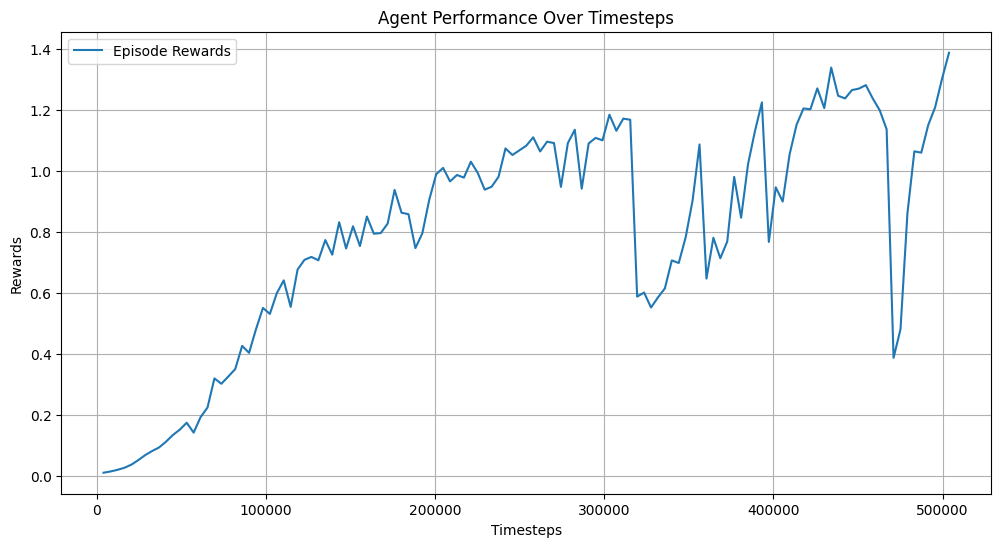

Performance for medium difficulty:


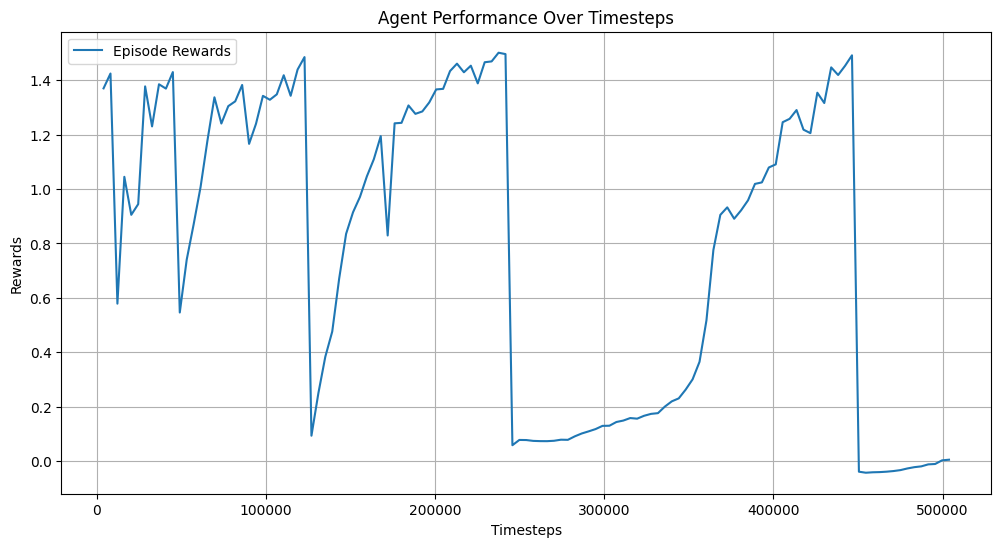

Performance for hard difficulty:


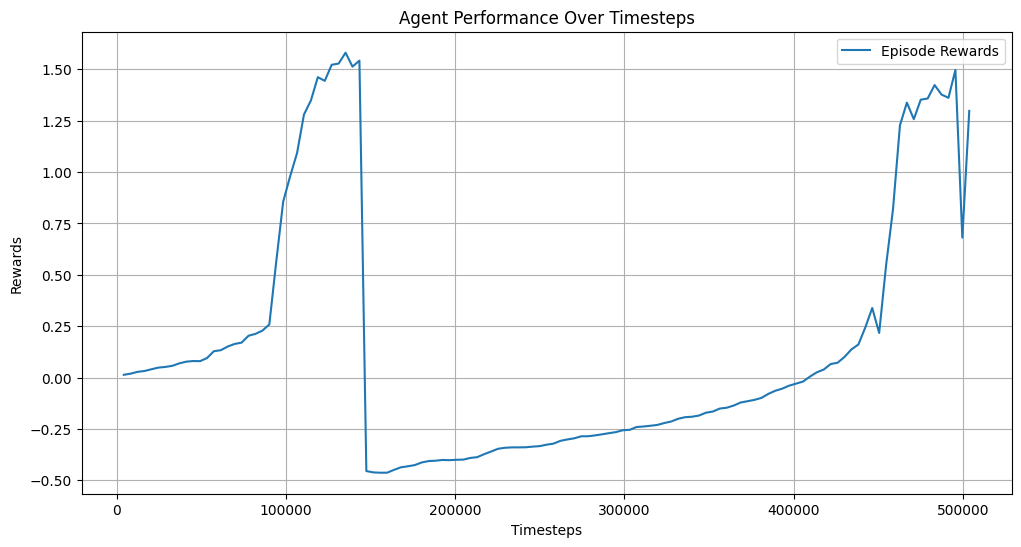

In [15]:
difficulty_order = ["easy", "medium", "hard"]
results, models = curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500_000)


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


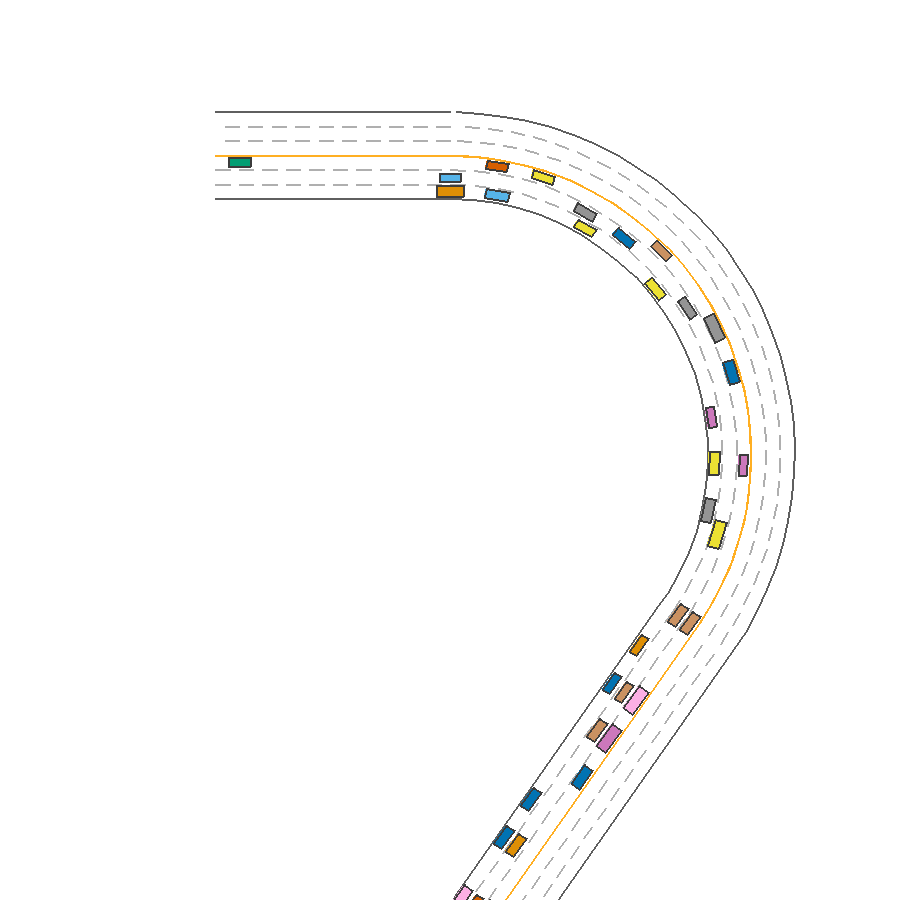

In [25]:
model = models[2][1]

env = create_environment('hard', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, -55))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

In [ ]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 2, "traffic_density": 0.1, "random_lane_width": False, "use_render": render,
                            #  "out_of_road_penalty": 30.0,  # Increased penalty
                #  "out_of_road_cost":


                 },
        "medium": {"map": 3, "traffic_density": 0.3, "random_lane_width": True, "use_render": render,
                              #  "out_of_road_penalty": 30.0,  # Increased penalty

                   },
        "hard": {"map": 4, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
        "extremhard": {"map": 5, "traffic_density": 0.5, "random_lane_width": True, "use_render": render}
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


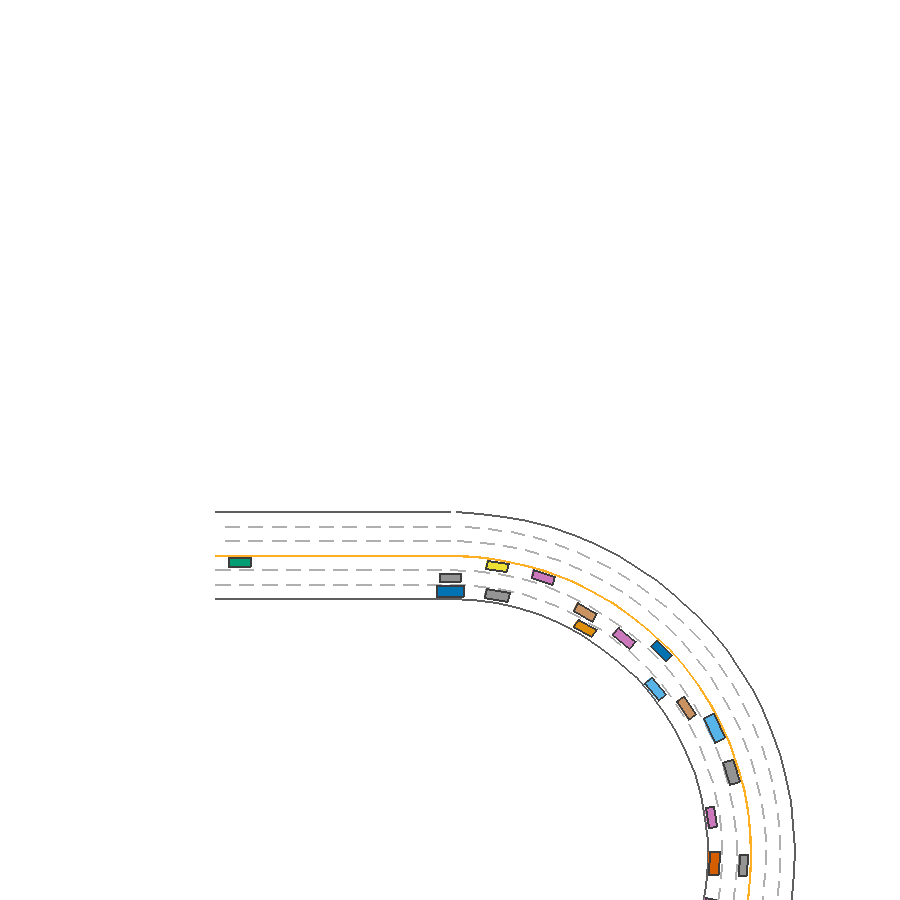

In [ ]:
model = models[2][1]

env = create_environment('extremhard', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

# Dynamic Curriculum Learning

In [ ]:
def dynamic_curriculum_experiment(
    difficulty_order,
    initial_timesteps=50_000,   # initial training steps per increment
    increment_factor=1.2,       # factor to increase timesteps if needed
    performance_window=50,      # number of episodes to average over for performance
    improvement_margin=0.1,     # how much improvement is needed over previous difficulty
    max_increments_per_difficulty=5,
    max_timesteps=300_000
):
    """
    Dynamic curriculum learning experiment with:
    - Rolling performance metric over a stable window
    - Dynamic threshold based on previous difficulty's performance
    - Incremental training and early exit if improvement stalls
    """
    model = None  # Start with no pretrained model
    results = []
    models = []
    total_used_timesteps = 0

    # Baseline performance for the next difficulty. Start low so first difficulty just needs to exceed this.
    previous_difficulty_performance = -float("inf")

    for difficulty_idx, difficulty in enumerate(difficulty_order):
        print(f"Starting dynamic curriculum training on {difficulty} difficulty...")
        env = create_environment(difficulty, render=False)
        logger = PerformanceLogger()

        required_performance = previous_difficulty_performance + improvement_margin
        print(f"Required performance for {difficulty}: > {required_performance:.2f}")

        increment_timesteps = initial_timesteps
        increments_used = 0
        difficulty_mastered = False

        try:
            while increments_used < max_increments_per_difficulty and not difficulty_mastered:
                print(f"Training on {difficulty} for {increment_timesteps} timesteps...")
                model, logger = train_agent_with_transfer(env, model=model, timesteps=increment_timesteps)
                total_used_timesteps += increment_timesteps

                # Compute stable performance: mean of last 'performance_window' episodes
                if len(logger.rewards) >= performance_window:
                    recent_performance = np.mean(logger.rewards[-performance_window:])
                else:
                    recent_performance = np.mean(logger.rewards) if logger.rewards else -float("inf")

                print(f"Recent performance on {difficulty}: {recent_performance:.2f}")

                # Check if we met the required performance
                if recent_performance > required_performance:
                    print(f"Performance requirement met on {difficulty}: {recent_performance:.2f} > {required_performance:.2f}")
                    difficulty_mastered = True
                else:
                    increments_used += 1
                    # Increase training steps for next increment to give more time
                    increment_timesteps = int(increment_timesteps * increment_factor)

                # Stop if we hit the global max timestep budget
                if total_used_timesteps > max_timesteps:
                    print("Reached the maximum total timesteps budget.")
                    break

            # If it's the last difficulty level, continue training up to max_timesteps
            if difficulty_idx == len(difficulty_order) - 1:
                remaining_timesteps = max_timesteps - total_used_timesteps
                if remaining_timesteps > 0:
                    print(f"Continuing training on {difficulty} for remaining timesteps: {remaining_timesteps}")
                    model, logger = train_agent_with_transfer(env, model=model, timesteps=remaining_timesteps)
                    total_used_timesteps += remaining_timesteps

            # If we didn't meet the requirement but ran out of increments, we still move on
            # This prevents getting stuck indefinitely.
            if not difficulty_mastered:
                print(f"Moving on from {difficulty} without fully meeting performance requirement.")
                # Just take whatever best performance we had for baseline update
                if len(logger.rewards) > 0:
                    recent_performance = np.mean(logger.rewards[-performance_window:])
                else:
                    recent_performance = -float("inf")

            # Update baseline performance for next difficulty
            previous_difficulty_performance = max(previous_difficulty_performance, recent_performance)

            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        plot_performance(logger, f"Performance on {difficulty} (Dynamic Curriculum)")

    return results, models

# Dynamic currculum learning finish all 300_000 time steps

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Starting dynamic curriculum training on easy difficulty...
Required performance for easy: > -inf
Training on easy for 50000 timesteps...
Using cuda device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 689      |
|    ep_rew_mean     | 4.54     |
| time/              |          |
|    fps             | 292      |
|    iterations      | 1        |
|    time_elapsed    | 14       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.5e+03     |
|    ep_rew_mean          | 16          |
| time/                   |             |
|    fps                  | 270         |
|    iterations           | 2           |
|    time_elapsed         | 30          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010810348 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.000275    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.173       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0115     |
|    std                  | 0.996       |
|    value_loss           | 0.119       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.36e+03    |
|    ep_rew_mean          | 19.9        |
| time/                   |             |
|    fps                  | 252         |
|    iterations           | 3           |
|    time_elapsed         | 48          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.018711993 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.0061      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0345     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0153     |
|    std                  | 0.968       |
|    value_loss           | 0.128       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.27e+03   |
|    ep_rew_mean          | 22.5       |
| time/                   |            |
|    fps                  | 250        |
|    iterations           | 4          |
|    time_elapsed         | 65         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01190373 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.75      |
|    explained_variance   | 0.0281     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0769     |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.00563   |
|    std                  | 0.95       |
|    value_loss           | 0.344      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.19e+03    |
|    ep_rew_mean          | 27.3        |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 5           |
|    time_elapsed         | 83          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.020563193 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | 0.0615      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0633      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.016      |
|    std                  | 0.92        |
|    value_loss           | 0.291       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 974        |
|    ep_rew_mean          | 27.4       |
| time/                   |            |
|    fps                  | 240        |
|    iterations           | 6          |
|    time_elapsed         | 102        |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.01452492 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.64      |
|    explained_variance   | 0.063      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.118      |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.00849   |
|    std                  | 0.903      |
|    value_loss           | 0.513      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 607         |
|    ep_rew_mean          | 19.6        |
| time/                   |             |
|    fps                  | 233         |
|    iterations           | 7           |
|    time_elapsed         | 122         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.012208416 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.0777      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.227       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00781    |
|    std                  | 0.876       |
|    value_loss           | 0.911       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 472         |
|    ep_rew_mean          | 16.7        |
| time/                   |             |
|    fps                  | 224         |
|    iterations           | 8           |
|    time_elapsed         | 146         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008596322 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | 0.0948      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.22        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00594    |
|    std                  | 0.865       |
|    value_loss           | 2.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 397         |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 217         |
|    iterations           | 9           |
|    time_elapsed         | 169         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.010675734 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.517       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.256       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00471    |
|    std                  | 0.858       |
|    value_loss           | 1.14        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 256          |
|    ep_rew_mean          | 15.8         |
| time/                   |              |
|    fps                  | 214          |
|    iterations           | 10           |
|    time_elapsed         | 191          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0064747776 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.51        |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.421        |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00319     |
|    std                  | 0.847        |
|    value_loss           | 1.58         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 14.1        |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 11          |
|    time_elapsed         | 216         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.006216539 |
|    clip_fraction        | 0.0745      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.416       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.991       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00201    |
|    std                  | 0.839       |
|    value_loss           | 2.85        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 176         |
|    ep_rew_mean          | 17.3        |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 12          |
|    time_elapsed         | 241         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.009102751 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.634       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0094     |
|    std                  | 0.829       |
|    value_loss           | 2.17        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 133          |
|    ep_rew_mean          | 14.9         |
| time/                   |              |
|    fps                  | 199          |
|    iterations           | 13           |
|    time_elapsed         | 267          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0073821787 |
|    clip_fraction        | 0.0853       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.557        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.72         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00163     |
|    std                  | 0.818        |
|    value_loss           | 3.5          |
------------------------------------------
Recent performance on easy: 0.06
Performance requireme

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Starting dynamic curriculum training on medium difficulty...
Required performance for medium: > 0.16
Training on medium for 50000 timesteps...
Continuing training with transfer learning...


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | 20       |
| time/              |          |
|    fps             | 182      |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 145         |
|    ep_rew_mean          | 22.2        |
| time/                   |             |
|    fps                  | 176         |
|    iterations           | 2           |
|    time_elapsed         | 46          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011186628 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.578       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.91        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0136     |
|    std                  | 0.798       |
|    value_loss           | 6.79        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 149        |
|    ep_rew_mean          | 24.2       |
| time/                   |            |
|    fps                  | 174        |
|    iterations           | 3          |
|    time_elapsed         | 70         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.00846204 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.36      |
|    explained_variance   | 0.653      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.67       |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.00218   |
|    std                  | 0.784      |
|    value_loss           | 5.32       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 158         |
|    ep_rew_mean          | 27.6        |
| time/                   |             |
|    fps                  | 175         |
|    iterations           | 4           |
|    time_elapsed         | 93          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.017939033 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.32       |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.31        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0025     |
|    std                  | 0.771       |
|    value_loss           | 6.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 171        |
|    ep_rew_mean          | 32.8       |
| time/                   |            |
|    fps                  | 175        |
|    iterations           | 5          |
|    time_elapsed         | 116        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.00829416 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.29      |
|    explained_variance   | 0.671      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.1        |
|    n_updates            | 170        |
|    policy_gradient_loss | 0.00155    |
|    std                  | 0.759      |
|    value_loss           | 6.55       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 182         |
|    ep_rew_mean          | 37.1        |
| time/                   |             |
|    fps                  | 174         |
|    iterations           | 6           |
|    time_elapsed         | 140         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.012200374 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.76        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.000831   |
|    std                  | 0.736       |
|    value_loss           | 5.76        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 179        |
|    ep_rew_mean          | 41.3       |
| time/                   |            |
|    fps                  | 174        |
|    iterations           | 7          |
|    time_elapsed         | 164        |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.02218841 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.2       |
|    explained_variance   | 0.678      |
|    learning_rate        | 0.0003     |
|    loss                 | 4.66       |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.00559   |
|    std                  | 0.722      |
|    value_loss           | 8.07       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 192         |
|    ep_rew_mean          | 47.6        |
| time/                   |             |
|    fps                  | 176         |
|    iterations           | 8           |
|    time_elapsed         | 185         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.006106931 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.244       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.44        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00255    |
|    std                  | 0.712       |
|    value_loss           | 15.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 210         |
|    ep_rew_mean          | 57.2        |
| time/                   |             |
|    fps                  | 177         |
|    iterations           | 9           |
|    time_elapsed         | 208         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.009297801 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.13        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.000794   |
|    std                  | 0.693       |
|    value_loss           | 9.63        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 212         |
|    ep_rew_mean          | 64          |
| time/                   |             |
|    fps                  | 176         |
|    iterations           | 10          |
|    time_elapsed         | 232         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.024789281 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.09       |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0038     |
|    std                  | 0.687       |
|    value_loss           | 14.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 215         |
|    ep_rew_mean          | 71.1        |
| time/                   |             |
|    fps                  | 176         |
|    iterations           | 11          |
|    time_elapsed         | 254         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.014652139 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.81        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00174    |
|    std                  | 0.678       |
|    value_loss           | 18.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | 46.1        |
| time/                   |             |
|    fps                  | 174         |
|    iterations           | 12          |
|    time_elapsed         | 280         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.019102797 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0.284       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.18        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.000457   |
|    std                  | 0.659       |
|    value_loss           | 24          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | 36.2        |
| time/                   |             |
|    fps                  | 174         |
|    iterations           | 13          |
|    time_elapsed         | 305         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.016186964 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.296       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.7        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00757    |
|    std                  | 0.656       |
|    value_loss           | 43.4        |
-----------------------------------------
Recent performance on medium: 0.26
Performance requirement met on medium: 0.

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Starting dynamic curriculum training on hard difficulty...
Required performance for hard: > 0.36
Training on hard for 50000 timesteps...
Continuing training with transfer learning...


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 186      |
|    ep_rew_mean     | 73.2     |
| time/              |          |
|    fps             | 193      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 197        |
|    ep_rew_mean          | 78.8       |
| time/                   |            |
|    fps                  | 182        |
|    iterations           | 2          |
|    time_elapsed         | 44         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.02084703 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | 0.356      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.2       |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.00147   |
|    std                  | 0.636      |
|    value_loss           | 27.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 206         |
|    ep_rew_mean          | 88.6        |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 3           |
|    time_elapsed         | 68          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.010461861 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.07        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0038     |
|    std                  | 0.621       |
|    value_loss           | 28.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 186         |
|    ep_rew_mean          | 78.6        |
| time/                   |             |
|    fps                  | 174         |
|    iterations           | 4           |
|    time_elapsed         | 93          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012763493 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.3        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.00047     |
|    std                  | 0.612       |
|    value_loss           | 38.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 105        |
|    ep_rew_mean          | 37.8       |
| time/                   |            |
|    fps                  | 169        |
|    iterations           | 5          |
|    time_elapsed         | 120        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.16514438 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.86      |
|    explained_variance   | 0.336      |
|    learning_rate        | 0.0003     |
|    loss                 | 29.3       |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.00612    |
|    std                  | 0.612      |
|    value_loss           | 41.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.3        |
|    ep_rew_mean          | 25.9        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 6           |
|    time_elapsed         | 147         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.043843914 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.359       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.2        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0118     |
|    std                  | 0.617       |
|    value_loss           | 55.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 93.9       |
|    ep_rew_mean          | 36.8       |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 7          |
|    time_elapsed         | 175        |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.06025649 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.84      |
|    explained_variance   | 0.35       |
|    learning_rate        | 0.0003     |
|    loss                 | 19.8       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.00136   |
|    std                  | 0.601      |
|    value_loss           | 43.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 84.9       |
|    ep_rew_mean          | 31.8       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 8          |
|    time_elapsed         | 202        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.03240195 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.8       |
|    explained_variance   | 0.363      |
|    learning_rate        | 0.0003     |
|    loss                 | 31.8       |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.00774   |
|    std                  | 0.591      |
|    value_loss           | 51         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 98.9      |
|    ep_rew_mean          | 43.9      |
| time/                   |           |
|    fps                  | 161       |
|    iterations           | 9         |
|    time_elapsed         | 228       |
|    total_timesteps      | 36864     |
| train/                  |           |
|    approx_kl            | 0.0350091 |
|    clip_fraction        | 0.236     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.78     |
|    explained_variance   | 0.384     |
|    learning_rate        | 0.0003    |
|    loss                 | 23.3      |
|    n_updates            | 340       |
|    policy_gradient_loss | -0.00334  |
|    std                  | 0.584     |
|    value_loss           | 46.8      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 62.2        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 10          |
|    time_elapsed         | 252         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010396349 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.268       |
|    learning_rate        | 0.0003      |
|    loss                 | 21          |
|    n_updates            | 350         |
|    policy_gradient_loss | 0.00425     |
|    std                  | 0.574       |
|    value_loss           | 49.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 79.7        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 11          |
|    time_elapsed         | 278         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.011602383 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.7        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.000431    |
|    std                  | 0.566       |
|    value_loss           | 60.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 155        |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 12         |
|    time_elapsed         | 302        |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.01108787 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.68      |
|    explained_variance   | 0.305      |
|    learning_rate        | 0.0003     |
|    loss                 | 43.2       |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.00174   |
|    std                  | 0.557      |
|    value_loss           | 79.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 13          |
|    time_elapsed         | 327         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.009577366 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 37.6        |
|    n_updates            | 380         |
|    policy_gradient_loss | 0.00763     |
|    std                  | 0.548       |
|    value_loss           | 68.9        |
-----------------------------------------
Recent performance on hard: 0.49
Performance requirement met on hard: 0.49 >

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 138      |
|    ep_rew_mean     | 90.4     |
| time/              |          |
|    fps             | 176      |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 157         |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 2           |
|    time_elapsed         | 48          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.020836873 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.6        |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.0041      |
|    std                  | 0.539       |
|    value_loss           | 105         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 166        |
|    ep_rew_mean          | 126        |
| time/                   |            |
|    fps                  | 168        |
|    iterations           | 3          |
|    time_elapsed         | 73         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.03602542 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.58      |
|    explained_variance   | 0.329      |
|    learning_rate        | 0.0003     |
|    loss                 | 47         |
|    n_updates            | 410        |
|    policy_gradient_loss | 0.0203     |
|    std                  | 0.535      |
|    value_loss           | 90.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 133         |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 4           |
|    time_elapsed         | 99          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.019934816 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.384       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.9        |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.00513     |
|    std                  | 0.527       |
|    value_loss           | 91.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 5           |
|    time_elapsed         | 124         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.025299488 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.396       |
|    learning_rate        | 0.0003      |
|    loss                 | 57          |
|    n_updates            | 430         |
|    policy_gradient_loss | 0.0215      |
|    std                  | 0.524       |
|    value_loss           | 96.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 176         |
|    ep_rew_mean          | 146         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 6           |
|    time_elapsed         | 150         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.018723063 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.459       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.2        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00523     |
|    std                  | 0.517       |
|    value_loss           | 108         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 146         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 7           |
|    time_elapsed         | 174         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.036430694 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.1        |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.0238      |
|    std                  | 0.514       |
|    value_loss           | 88.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 149         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 8           |
|    time_elapsed         | 199         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008236406 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.0003      |
|    loss                 | 42          |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.00405     |
|    std                  | 0.515       |
|    value_loss           | 104         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 171          |
|    ep_rew_mean          | 154          |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 9            |
|    time_elapsed         | 224          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0072685317 |
|    clip_fraction        | 0.184        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.46        |
|    explained_variance   | 0.395        |
|    learning_rate        | 0.0003       |
|    loss                 | 45.4         |
|    n_updates            | 470          |
|    policy_gradient_loss | 0.00907      |
|    std                  | 0.505        |
|    value_loss           | 120          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 160         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 10          |
|    time_elapsed         | 249         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.012254548 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.8        |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.0161      |
|    std                  | 0.499       |
|    value_loss           | 118         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 168         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 11          |
|    time_elapsed         | 273         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.013406424 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.394       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.9        |
|    n_updates            | 490         |
|    policy_gradient_loss | 0.0226      |
|    std                  | 0.486       |
|    value_loss           | 115         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 174        |
|    ep_rew_mean          | 166        |
| time/                   |            |
|    fps                  | 164        |
|    iterations           | 12         |
|    time_elapsed         | 299        |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.13894957 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.37      |
|    explained_variance   | 0.525      |
|    learning_rate        | 0.0003     |
|    loss                 | 44.1       |
|    n_updates            | 500        |
|    policy_gradient_loss | 0.0846     |
|    std                  | 0.488      |
|    value_loss           | 89.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 166         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 13          |
|    time_elapsed         | 324         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.011346814 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.459       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.8        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.012       |
|    std                  | 0.485       |
|    value_loss           | 127         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 175         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 14          |
|    time_elapsed         | 348         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.016451564 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.0003      |
|    loss                 | 55.7        |
|    n_updates            | 520         |
|    policy_gradient_loss | 0.015       |
|    std                  | 0.484       |
|    value_loss           | 128         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 15          |
|    time_elapsed         | 374         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.020316202 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.7        |
|    n_updates            | 530         |
|    policy_gradient_loss | 0.00641     |
|    std                  | 0.484       |
|    value_loss           | 91.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 178         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 16          |
|    time_elapsed         | 399         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.021946542 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | 17          |
|    n_updates            | 540         |
|    policy_gradient_loss | 0.0255      |
|    std                  | 0.477       |
|    value_loss           | 59.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 184         |
|    ep_rew_mean          | 191         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 17          |
|    time_elapsed         | 423         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.010759603 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.2        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.0161      |
|    std                  | 0.472       |
|    value_loss           | 108         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 181         |
|    ep_rew_mean          | 189         |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 18          |
|    time_elapsed         | 448         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.010444079 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.0003      |
|    loss                 | 94          |
|    n_updates            | 560         |
|    policy_gradient_loss | 0.0117      |
|    std                  | 0.468       |
|    value_loss           | 75.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 175         |
|    ep_rew_mean          | 179         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 19          |
|    time_elapsed         | 474         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.030906292 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.0003      |
|    loss                 | 98.9        |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.00912     |
|    std                  | 0.464       |
|    value_loss           | 123         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 20          |
|    time_elapsed         | 500         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.029823717 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.657       |
|    learning_rate        | 0.0003      |
|    loss                 | 96.7        |
|    n_updates            | 580         |
|    policy_gradient_loss | 0.00953     |
|    std                  | 0.467       |
|    value_loss           | 106         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 176         |
|    ep_rew_mean          | 182         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 21          |
|    time_elapsed         | 526         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.008480959 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.0003      |
|    loss                 | 46          |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.00534     |
|    std                  | 0.462       |
|    value_loss           | 101         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 22          |
|    time_elapsed         | 551         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.041427232 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.3        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.0174      |
|    std                  | 0.46        |
|    value_loss           | 79.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 178          |
|    ep_rew_mean          | 186          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 23           |
|    time_elapsed         | 576          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0096904915 |
|    clip_fraction        | 0.389        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.596        |
|    learning_rate        | 0.0003       |
|    loss                 | 57.2         |
|    n_updates            | 610          |
|    policy_gradient_loss | 0.0655       |
|    std                  | 0.459        |
|    value_loss           | 123          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 183        |
|    ep_rew_mean          | 194        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 24         |
|    time_elapsed         | 601        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.01031466 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.39       |
|    n_updates            | 620        |
|    policy_gradient_loss | 0.023      |
|    std                  | 0.459      |
|    value_loss           | 59.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 180         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 25          |
|    time_elapsed         | 627         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.030281734 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.5        |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.0336      |
|    std                  | 0.458       |
|    value_loss           | 53.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 182        |
|    ep_rew_mean          | 198        |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 26         |
|    time_elapsed         | 653        |
|    total_timesteps      | 106496     |
| train/                  |            |
|    approx_kl            | 0.04061111 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.19      |
|    explained_variance   | 0.721      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.4       |
|    n_updates            | 640        |
|    policy_gradient_loss | 0.00775    |
|    std                  | 0.454      |
|    value_loss           | 99         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 182        |
|    ep_rew_mean          | 202        |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 27         |
|    time_elapsed         | 679        |
|    total_timesteps      | 110592     |
| train/                  |            |
|    approx_kl            | 0.06685415 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.18      |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.0003     |
|    loss                 | 20.6       |
|    n_updates            | 650        |
|    policy_gradient_loss | 0.0224     |
|    std                  | 0.453      |
|    value_loss           | 78.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 28          |
|    time_elapsed         | 705         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.027693722 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.1        |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.0468      |
|    std                  | 0.458       |
|    value_loss           | 86.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 167          |
|    ep_rew_mean          | 180          |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 29           |
|    time_elapsed         | 730          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0056163594 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.616        |
|    learning_rate        | 0.0003       |
|    loss                 | 73.8         |
|    n_updates            | 670          |
|    policy_gradient_loss | 0.000763     |
|    std                  | 0.457        |
|    value_loss           | 164          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 166        |
|    ep_rew_mean          | 180        |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 30         |
|    time_elapsed         | 755        |
|    total_timesteps      | 122880     |
| train/                  |            |
|    approx_kl            | 0.07775331 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.15      |
|    explained_variance   | 0.726      |
|    learning_rate        | 0.0003     |
|    loss                 | 196        |
|    n_updates            | 680        |
|    policy_gradient_loss | 0.0261     |
|    std                  | 0.452      |
|    value_loss           | 122        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 31          |
|    time_elapsed         | 780         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.011819776 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.5        |
|    n_updates            | 690         |
|    policy_gradient_loss | 0.00335     |
|    std                  | 0.445       |
|    value_loss           | 93.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 32          |
|    time_elapsed         | 806         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.031579074 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.9        |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.0365      |
|    std                  | 0.441       |
|    value_loss           | 42.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | 192         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 33          |
|    time_elapsed         | 832         |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.027409874 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.2        |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.0105      |
|    std                  | 0.434       |
|    value_loss           | 73.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 166         |
|    ep_rew_mean          | 192         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 34          |
|    time_elapsed         | 857         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.039942328 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.8        |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.00431     |
|    std                  | 0.43        |
|    value_loss           | 171         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 173         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 35          |
|    time_elapsed         | 884         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.012842614 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 46          |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.0253      |
|    std                  | 0.43        |
|    value_loss           | 119         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 155        |
|    ep_rew_mean          | 176        |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 36         |
|    time_elapsed         | 909        |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.07541695 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.62       |
|    learning_rate        | 0.0003     |
|    loss                 | 90.7       |
|    n_updates            | 740        |
|    policy_gradient_loss | 0.00345    |
|    std                  | 0.428      |
|    value_loss           | 166        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 37          |
|    time_elapsed         | 934         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.050671205 |
|    clip_fraction        | 0.319       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.4        |
|    n_updates            | 750         |
|    policy_gradient_loss | 0.0264      |
|    std                  | 0.433       |
|    value_loss           | 82          |
-----------------------------------------


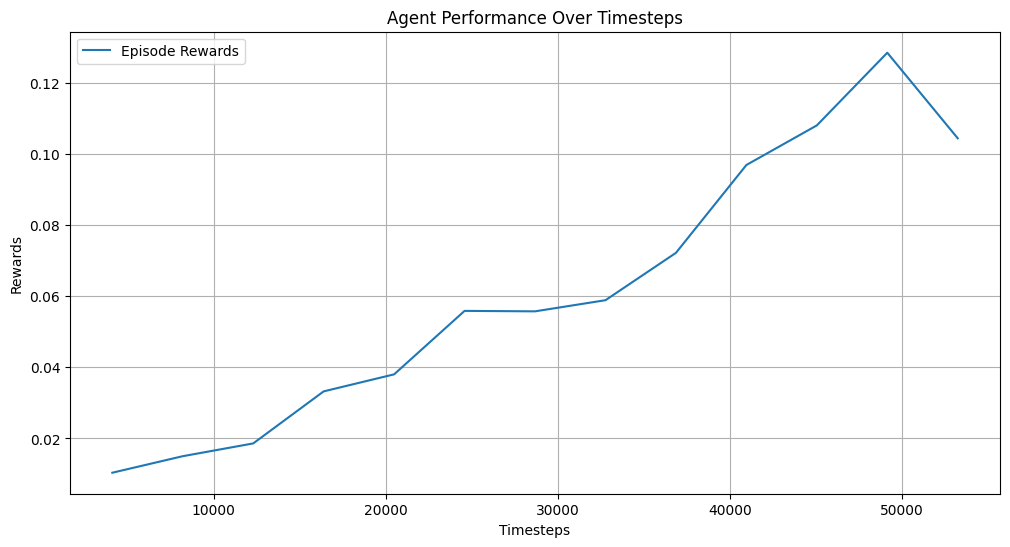

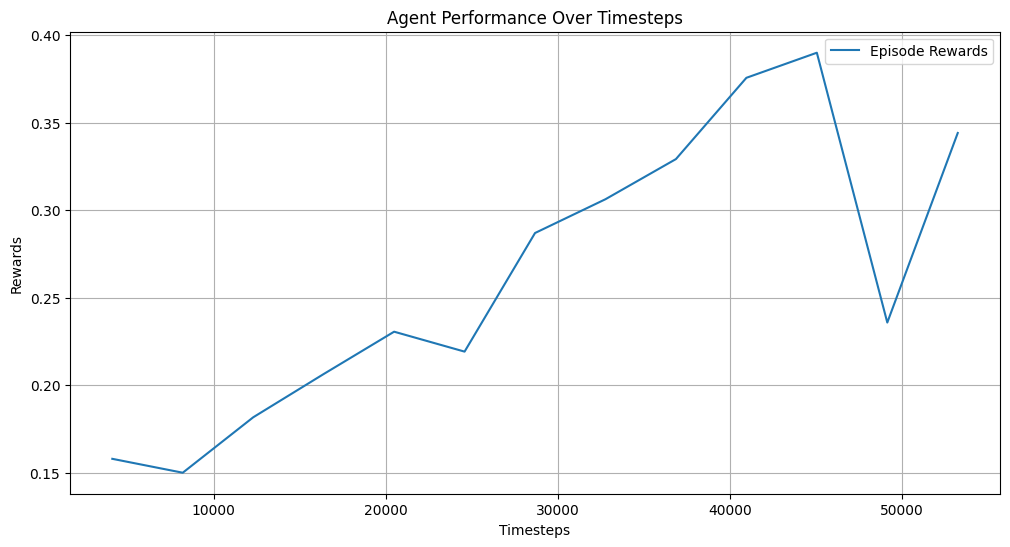

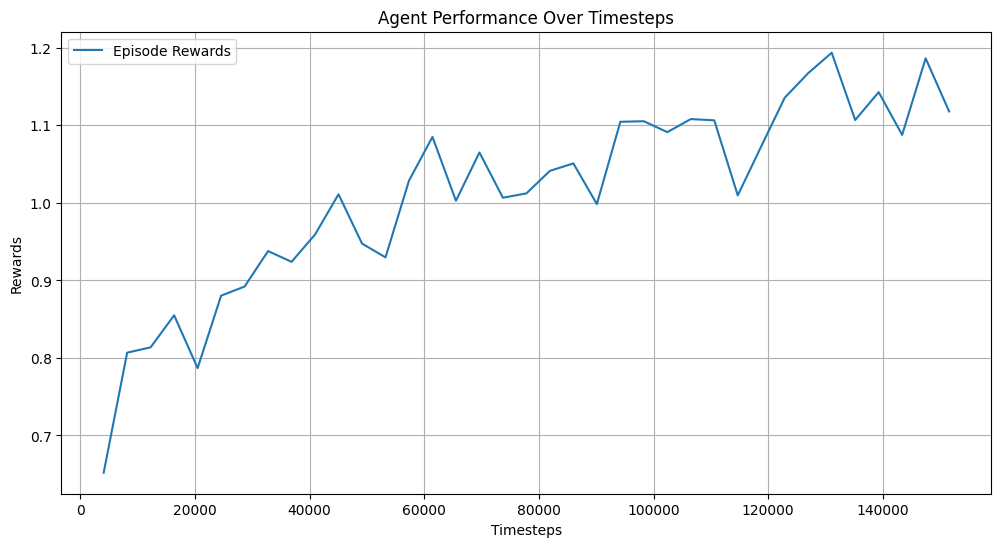

In [ ]:
difficulty_order = ["easy", "medium", "hard"]
results, models = dynamic_curriculum_experiment(difficulty_order)

# On hard mode Non Transfer Learning

In [ ]:
difficulty_order = ["hard"]#"medium"#, "hard"]

In [ ]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=200_000)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 211  |
|    iterations      | 1    |
|    time_elapsed    | 19   |
|    total_timesteps | 4096 |
-----------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.72e+03    |
|    ep_rew_mean          | 39.1        |
| time/                   |             |
|    fps                  | 183         |
|    iterations           | 2           |
|    time_elapsed         | 44          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018315848 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.0419      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0267     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0283     |
|    std                  | 0.966       |
|    value_loss           | 0.0117      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.64e+03    |
|    ep_rew_mean          | 26.3        |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 3           |
|    time_elapsed         | 94          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.011609415 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.0195     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00874    |
|    std                  | 0.96        |
|    value_loss           | 0.196       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.26e+03   |
|    ep_rew_mean          | 23.2       |
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 4          |
|    time_elapsed         | 147        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01273953 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.74      |
|    explained_variance   | -0.00965   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.285      |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.0102    |
|    std                  | 0.944      |
|    value_loss           | 0.317      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 957         |
|    ep_rew_mean          | 19.8        |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5           |
|    time_elapsed         | 216         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.016143542 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.0297      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0104     |
|    std                  | 0.935       |
|    value_loss           | 0.47        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 633         |
|    ep_rew_mean          | 15          |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 6           |
|    time_elapsed         | 293         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.010370689 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.185       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.262       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00866    |
|    std                  | 0.914       |
|    value_loss           | 0.685       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 499         |
|    ep_rew_mean          | 13.2        |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 7           |
|    time_elapsed         | 377         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.007869551 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.633       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.004      |
|    std                  | 0.904       |
|    value_loss           | 1.49        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 412          |
|    ep_rew_mean          | 12.5         |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 8            |
|    time_elapsed         | 466          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0055234893 |
|    clip_fraction        | 0.0864       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.61        |
|    explained_variance   | 0.355        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.284        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00504     |
|    std                  | 0.887        |
|    value_loss           | 1.48         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 277          |
|    ep_rew_mean          | 10.9         |
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 9            |
|    time_elapsed         | 551          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0073201545 |
|    clip_fraction        | 0.0976       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.58        |
|    explained_variance   | 0.419        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.08         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00396     |
|    std                  | 0.879        |
|    value_loss           | 1.95         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 11.9        |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 10          |
|    time_elapsed         | 633         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.004565303 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.79        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00356    |
|    std                  | 0.87        |
|    value_loss           | 2.9         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 198         |
|    ep_rew_mean          | 13.9        |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 11          |
|    time_elapsed         | 729         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.007267322 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.504       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.257       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00459    |
|    std                  | 0.853       |
|    value_loss           | 1.92        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 195          |
|    ep_rew_mean          | 16.5         |
| time/                   |              |
|    fps                  | 59           |
|    iterations           | 12           |
|    time_elapsed         | 822          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0052680187 |
|    clip_fraction        | 0.139        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.51        |
|    explained_variance   | 0.564        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.96         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00363     |
|    std                  | 0.845        |
|    value_loss           | 2.79         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 155         |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 13          |
|    time_elapsed         | 918         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.011626381 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.34        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.3         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00497    |
|    std                  | 0.831       |
|    value_loss           | 3.68        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 13.7        |
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 14          |
|    time_elapsed         | 1017        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013047557 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.7         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.012      |
|    std                  | 0.822       |
|    value_loss           | 2.81        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 116         |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 15          |
|    time_elapsed         | 1119        |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.010620439 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.688       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.98        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0107     |
|    std                  | 0.802       |
|    value_loss           | 4.02        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 23          |
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 16          |
|    time_elapsed         | 1197        |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.006576111 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.7         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00331    |
|    std                  | 0.79        |
|    value_loss           | 6.99        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 164        |
|    ep_rew_mean          | 29.6       |
| time/                   |            |
|    fps                  | 53         |
|    iterations           | 17         |
|    time_elapsed         | 1299       |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.00960225 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.33      |
|    explained_variance   | 0.36       |
|    learning_rate        | 0.0003     |
|    loss                 | 2.42       |
|    n_updates            | 160        |
|    policy_gradient_loss | 0.00188    |
|    std                  | 0.77       |
|    value_loss           | 6.28       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 34.4        |
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 18          |
|    time_elapsed         | 1401        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.008023556 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.361       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.29        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.754       |
|    value_loss           | 10.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 195        |
|    ep_rew_mean          | 44.4       |
| time/                   |            |
|    fps                  | 52         |
|    iterations           | 19         |
|    time_elapsed         | 1486       |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.01069008 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.25      |
|    explained_variance   | 0.273      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.54       |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.00762   |
|    std                  | 0.742      |
|    value_loss           | 12.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 196         |
|    ep_rew_mean          | 50.8        |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 20          |
|    time_elapsed         | 1599        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.014778899 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.48        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.000976   |
|    std                  | 0.725       |
|    value_loss           | 11.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 186         |
|    ep_rew_mean          | 55          |
| time/                   |             |
|    fps                  | 50          |
|    iterations           | 21          |
|    time_elapsed         | 1716        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.016245604 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.547       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00249    |
|    std                  | 0.707       |
|    value_loss           | 8.79        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 195         |
|    ep_rew_mean          | 63          |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 22          |
|    time_elapsed         | 1840        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.007232776 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.621       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.48        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0015     |
|    std                  | 0.702       |
|    value_loss           | 11.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 63.5        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 23          |
|    time_elapsed         | 1955        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.018619943 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.02        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.000273   |
|    std                  | 0.686       |
|    value_loss           | 14.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 62.3        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 24          |
|    time_elapsed         | 2068        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.020269647 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.559       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.64        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00469    |
|    std                  | 0.678       |
|    value_loss           | 22.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 57.4        |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 25          |
|    time_elapsed         | 2183        |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.017915282 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.04       |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00136    |
|    std                  | 0.665       |
|    value_loss           | 21.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 59.5        |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 26          |
|    time_elapsed         | 2296        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.011647269 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.01       |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.67        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00934    |
|    std                  | 0.658       |
|    value_loss           | 26.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 62          |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 27          |
|    time_elapsed         | 2414        |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.020886635 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.3        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0063     |
|    std                  | 0.649       |
|    value_loss           | 27.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 145         |
|    ep_rew_mean          | 66.7        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 28          |
|    time_elapsed         | 2538        |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.017082322 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 270         |
|    policy_gradient_loss | 0.00409     |
|    std                  | 0.635       |
|    value_loss           | 20          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 70.8        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 29          |
|    time_elapsed         | 2659        |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.025052233 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.37        |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.0024      |
|    std                  | 0.628       |
|    value_loss           | 9.29        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 71.8        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 30          |
|    time_elapsed         | 2784        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.010386584 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.3         |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00162    |
|    std                  | 0.621       |
|    value_loss           | 21.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

In [ ]:
models

[('easy', <stable_baselines3.ppo.ppo.PPO at 0x7b53673a1c60>)]

In [ ]:
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

In [ ]:
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')